In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 151706 images
Dataset type val label type: species


Loaded 37931 images
Dataset type test label type: species


Loaded 78017 images
Dataset type test label type: species


Loaded 81589 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

2:3 oo98862g


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-oo98862g:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                      | 0/1186 [00:00<?, ?it/s]

  0%|                                                                                              | 1/1186 [00:00<14:38,  1.35it/s]

  0%|▏                                                                                             | 2/1186 [00:00<08:35,  2.30it/s]

  0%|▏                                                                                             | 3/1186 [00:01<06:38,  2.97it/s]

  0%|▎                                                                                             | 4/1186 [00:01<05:43,  3.44it/s]

  0%|▍                                                                                             | 5/1186 [00:01<05:13,  3.77it/s]

  1%|▍                                                                                             | 6/1186 [00:01<04:55,  4.00it/s]

  1%|▌                                                                                             | 7/1186 [00:02<04:43,  4.16it/s]

  1%|▋                                                                                             | 8/1186 [00:02<04:35,  4.28it/s]

  1%|▋                                                                                             | 9/1186 [00:02<04:30,  4.36it/s]

  1%|▊                                                                                            | 10/1186 [00:02<04:26,  4.41it/s]

  1%|▊                                                                                            | 11/1186 [00:02<04:23,  4.45it/s]

  1%|▉                                                                                            | 12/1186 [00:03<04:22,  4.48it/s]

  1%|█                                                                                            | 13/1186 [00:03<04:20,  4.50it/s]

  1%|█                                                                                            | 14/1186 [00:03<04:19,  4.51it/s]

  1%|█▏                                                                                           | 15/1186 [00:03<04:19,  4.52it/s]

  1%|█▎                                                                                           | 16/1186 [00:04<04:18,  4.53it/s]

  1%|█▎                                                                                           | 17/1186 [00:04<04:17,  4.53it/s]

  2%|█▍                                                                                           | 18/1186 [00:04<04:17,  4.54it/s]

  2%|█▍                                                                                           | 19/1186 [00:04<04:17,  4.54it/s]

  2%|█▌                                                                                           | 20/1186 [00:04<04:16,  4.54it/s]

  2%|█▋                                                                                           | 21/1186 [00:05<04:16,  4.54it/s]

  2%|█▋                                                                                           | 22/1186 [00:05<04:16,  4.54it/s]

  2%|█▊                                                                                           | 23/1186 [00:05<04:16,  4.54it/s]

  2%|█▉                                                                                           | 24/1186 [00:05<04:15,  4.54it/s]

  2%|█▉                                                                                           | 25/1186 [00:06<04:15,  4.54it/s]

  2%|██                                                                                           | 26/1186 [00:06<04:15,  4.54it/s]

  2%|██                                                                                           | 27/1186 [00:06<04:15,  4.54it/s]

  2%|██▏                                                                                          | 28/1186 [00:06<04:14,  4.54it/s]

  2%|██▎                                                                                          | 29/1186 [00:06<04:14,  4.54it/s]

  3%|██▎                                                                                          | 30/1186 [00:07<04:14,  4.54it/s]

  3%|██▍                                                                                          | 31/1186 [00:07<04:14,  4.54it/s]

  3%|██▌                                                                                          | 32/1186 [00:07<04:14,  4.54it/s]

  3%|██▌                                                                                          | 33/1186 [00:07<04:13,  4.54it/s]

  3%|██▋                                                                                          | 34/1186 [00:08<04:13,  4.54it/s]

  3%|██▋                                                                                          | 35/1186 [00:08<04:13,  4.54it/s]

  3%|██▊                                                                                          | 36/1186 [00:08<04:13,  4.54it/s]

  3%|██▉                                                                                          | 37/1186 [00:08<04:13,  4.54it/s]

  3%|██▉                                                                                          | 38/1186 [00:08<04:12,  4.54it/s]

  3%|███                                                                                          | 39/1186 [00:09<04:12,  4.54it/s]

  3%|███▏                                                                                         | 40/1186 [00:09<04:12,  4.54it/s]

  3%|███▏                                                                                         | 41/1186 [00:09<04:12,  4.54it/s]

  4%|███▎                                                                                         | 42/1186 [00:09<04:12,  4.54it/s]

  4%|███▎                                                                                         | 43/1186 [00:09<04:11,  4.54it/s]

  4%|███▍                                                                                         | 44/1186 [00:10<04:11,  4.54it/s]

  4%|███▌                                                                                         | 45/1186 [00:10<04:11,  4.54it/s]

  4%|███▌                                                                                         | 46/1186 [00:10<04:11,  4.54it/s]

  4%|███▋                                                                                         | 47/1186 [00:10<04:10,  4.54it/s]

  4%|███▊                                                                                         | 48/1186 [00:11<04:10,  4.54it/s]

  4%|███▊                                                                                         | 49/1186 [00:11<04:10,  4.54it/s]

  4%|███▉                                                                                         | 50/1186 [00:11<04:10,  4.54it/s]

  4%|███▉                                                                                         | 51/1186 [00:11<04:09,  4.54it/s]

  4%|████                                                                                         | 52/1186 [00:11<04:09,  4.54it/s]

  4%|████▏                                                                                        | 53/1186 [00:12<04:09,  4.54it/s]

  5%|████▏                                                                                        | 54/1186 [00:12<04:09,  4.54it/s]

  5%|████▎                                                                                        | 55/1186 [00:12<04:09,  4.54it/s]

  5%|████▍                                                                                        | 56/1186 [00:12<04:08,  4.54it/s]

  5%|████▍                                                                                        | 57/1186 [00:13<04:08,  4.54it/s]

  5%|████▌                                                                                        | 58/1186 [00:13<04:08,  4.54it/s]

  5%|████▋                                                                                        | 59/1186 [00:13<04:08,  4.54it/s]

  5%|████▋                                                                                        | 60/1186 [00:13<04:08,  4.54it/s]

  5%|████▊                                                                                        | 61/1186 [00:13<04:07,  4.54it/s]

  5%|████▊                                                                                        | 62/1186 [00:14<04:07,  4.54it/s]

  5%|████▉                                                                                        | 63/1186 [00:14<04:07,  4.54it/s]

  5%|█████                                                                                        | 64/1186 [00:14<04:07,  4.54it/s]

  5%|█████                                                                                        | 65/1186 [00:14<04:07,  4.54it/s]

  6%|█████▏                                                                                       | 66/1186 [00:15<04:06,  4.54it/s]

  6%|█████▎                                                                                       | 67/1186 [00:15<04:06,  4.54it/s]

  6%|█████▎                                                                                       | 68/1186 [00:15<04:06,  4.54it/s]

  6%|█████▍                                                                                       | 69/1186 [00:15<04:06,  4.54it/s]

  6%|█████▍                                                                                       | 70/1186 [00:15<04:05,  4.54it/s]

  6%|█████▌                                                                                       | 71/1186 [00:16<04:05,  4.54it/s]

  6%|█████▋                                                                                       | 72/1186 [00:16<04:05,  4.54it/s]

  6%|█████▋                                                                                       | 73/1186 [00:16<04:05,  4.54it/s]

  6%|█████▊                                                                                       | 74/1186 [00:16<04:04,  4.54it/s]

  6%|█████▉                                                                                       | 75/1186 [00:17<04:04,  4.54it/s]

  6%|█████▉                                                                                       | 76/1186 [00:17<04:04,  4.54it/s]

  6%|██████                                                                                       | 77/1186 [00:17<04:04,  4.54it/s]

  7%|██████                                                                                       | 78/1186 [00:17<04:03,  4.54it/s]

  7%|██████▏                                                                                      | 79/1186 [00:17<04:03,  4.54it/s]

  7%|██████▎                                                                                      | 80/1186 [00:18<04:03,  4.54it/s]

  7%|██████▎                                                                                      | 81/1186 [00:18<04:03,  4.54it/s]

  7%|██████▍                                                                                      | 82/1186 [00:18<04:03,  4.54it/s]

  7%|██████▌                                                                                      | 83/1186 [00:18<04:02,  4.54it/s]

  7%|██████▌                                                                                      | 84/1186 [00:19<04:02,  4.54it/s]

  7%|██████▋                                                                                      | 85/1186 [00:19<04:02,  4.54it/s]

  7%|██████▋                                                                                      | 86/1186 [00:19<04:02,  4.54it/s]

  7%|██████▊                                                                                      | 87/1186 [00:19<04:02,  4.54it/s]

  7%|██████▉                                                                                      | 88/1186 [00:19<04:01,  4.54it/s]

  8%|██████▉                                                                                      | 89/1186 [00:20<04:01,  4.54it/s]

  8%|███████                                                                                      | 90/1186 [00:20<04:01,  4.54it/s]

  8%|███████▏                                                                                     | 91/1186 [00:20<04:01,  4.54it/s]

  8%|███████▏                                                                                     | 92/1186 [00:20<04:00,  4.54it/s]

  8%|███████▎                                                                                     | 93/1186 [00:21<04:00,  4.54it/s]

  8%|███████▎                                                                                     | 94/1186 [00:21<04:00,  4.54it/s]

  8%|███████▍                                                                                     | 95/1186 [00:21<04:00,  4.54it/s]

  8%|███████▌                                                                                     | 96/1186 [00:21<03:59,  4.54it/s]

  8%|███████▌                                                                                     | 97/1186 [00:21<03:59,  4.54it/s]

  8%|███████▋                                                                                     | 98/1186 [00:22<03:59,  4.54it/s]

  8%|███████▊                                                                                     | 99/1186 [00:22<03:59,  4.54it/s]

  8%|███████▊                                                                                    | 100/1186 [00:22<03:59,  4.54it/s]

  9%|███████▊                                                                                    | 101/1186 [00:22<03:58,  4.54it/s]

  9%|███████▉                                                                                    | 102/1186 [00:22<03:58,  4.54it/s]

  9%|███████▉                                                                                    | 103/1186 [00:23<03:58,  4.54it/s]

  9%|████████                                                                                    | 104/1186 [00:23<03:58,  4.54it/s]

  9%|████████▏                                                                                   | 105/1186 [00:23<03:57,  4.54it/s]

  9%|████████▏                                                                                   | 106/1186 [00:23<03:57,  4.54it/s]

  9%|████████▎                                                                                   | 107/1186 [00:24<03:57,  4.54it/s]

  9%|████████▍                                                                                   | 108/1186 [00:24<03:57,  4.54it/s]

  9%|████████▍                                                                                   | 109/1186 [00:24<03:57,  4.54it/s]

  9%|████████▌                                                                                   | 110/1186 [00:24<03:56,  4.54it/s]

  9%|████████▌                                                                                   | 111/1186 [00:24<03:56,  4.54it/s]

  9%|████████▋                                                                                   | 112/1186 [00:25<03:56,  4.54it/s]

 10%|████████▊                                                                                   | 113/1186 [00:25<03:56,  4.54it/s]

 10%|████████▊                                                                                   | 114/1186 [00:25<03:56,  4.54it/s]

 10%|████████▉                                                                                   | 115/1186 [00:25<03:55,  4.54it/s]

 10%|████████▉                                                                                   | 116/1186 [00:26<03:55,  4.54it/s]

 10%|█████████                                                                                   | 117/1186 [00:26<03:55,  4.54it/s]

 10%|█████████▏                                                                                  | 118/1186 [00:26<03:55,  4.54it/s]

 10%|█████████▏                                                                                  | 119/1186 [00:26<03:54,  4.54it/s]

 10%|█████████▎                                                                                  | 120/1186 [00:26<03:54,  4.54it/s]

 10%|█████████▍                                                                                  | 121/1186 [00:27<03:54,  4.54it/s]

 10%|█████████▍                                                                                  | 122/1186 [00:27<03:54,  4.54it/s]

 10%|█████████▌                                                                                  | 123/1186 [00:27<03:54,  4.54it/s]

 10%|█████████▌                                                                                  | 124/1186 [00:27<03:53,  4.54it/s]

 11%|█████████▋                                                                                  | 125/1186 [00:28<03:53,  4.54it/s]

 11%|█████████▊                                                                                  | 126/1186 [00:28<03:53,  4.54it/s]

 11%|█████████▊                                                                                  | 127/1186 [00:28<03:53,  4.54it/s]

 11%|█████████▉                                                                                  | 128/1186 [00:28<03:53,  4.54it/s]

 11%|██████████                                                                                  | 129/1186 [00:28<03:52,  4.54it/s]

 11%|██████████                                                                                  | 130/1186 [00:29<03:52,  4.54it/s]

 11%|██████████▏                                                                                 | 131/1186 [00:29<03:52,  4.54it/s]

 11%|██████████▏                                                                                 | 132/1186 [00:29<03:52,  4.54it/s]

 11%|██████████▎                                                                                 | 133/1186 [00:29<03:52,  4.54it/s]

 11%|██████████▍                                                                                 | 134/1186 [00:30<03:51,  4.54it/s]

 11%|██████████▍                                                                                 | 135/1186 [00:30<03:51,  4.54it/s]

 11%|██████████▌                                                                                 | 136/1186 [00:30<03:51,  4.54it/s]

 12%|██████████▋                                                                                 | 137/1186 [00:30<03:51,  4.54it/s]

 12%|██████████▋                                                                                 | 138/1186 [00:30<03:50,  4.54it/s]

 12%|██████████▊                                                                                 | 139/1186 [00:31<03:50,  4.54it/s]

 12%|██████████▊                                                                                 | 140/1186 [00:31<03:50,  4.54it/s]

 12%|██████████▉                                                                                 | 141/1186 [00:31<03:50,  4.54it/s]

 12%|███████████                                                                                 | 142/1186 [00:31<03:50,  4.54it/s]

 12%|███████████                                                                                 | 143/1186 [00:32<03:49,  4.54it/s]

 12%|███████████▏                                                                                | 144/1186 [00:32<03:49,  4.54it/s]

 12%|███████████▏                                                                                | 145/1186 [00:32<03:49,  4.54it/s]

 12%|███████████▎                                                                                | 146/1186 [00:32<03:49,  4.54it/s]

 12%|███████████▍                                                                                | 147/1186 [00:32<03:48,  4.54it/s]

 12%|███████████▍                                                                                | 148/1186 [00:33<03:48,  4.54it/s]

 13%|███████████▌                                                                                | 149/1186 [00:33<03:48,  4.54it/s]

 13%|███████████▋                                                                                | 150/1186 [00:33<03:48,  4.54it/s]

 13%|███████████▋                                                                                | 151/1186 [00:33<03:47,  4.54it/s]

 13%|███████████▊                                                                                | 152/1186 [00:33<03:47,  4.54it/s]

 13%|███████████▊                                                                                | 153/1186 [00:34<03:47,  4.54it/s]

 13%|███████████▉                                                                                | 154/1186 [00:34<03:47,  4.54it/s]

 13%|████████████                                                                                | 155/1186 [00:34<03:47,  4.54it/s]

 13%|████████████                                                                                | 156/1186 [00:34<03:46,  4.54it/s]

 13%|████████████▏                                                                               | 157/1186 [00:35<03:46,  4.54it/s]

 13%|████████████▎                                                                               | 158/1186 [00:35<03:46,  4.54it/s]

 13%|████████████▎                                                                               | 159/1186 [00:35<03:46,  4.54it/s]

 13%|████████████▍                                                                               | 160/1186 [00:35<03:46,  4.54it/s]

 14%|████████████▍                                                                               | 161/1186 [00:35<03:45,  4.54it/s]

 14%|████████████▌                                                                               | 162/1186 [00:36<03:45,  4.54it/s]

 14%|████████████▋                                                                               | 163/1186 [00:36<03:45,  4.54it/s]

 14%|████████████▋                                                                               | 164/1186 [00:36<03:45,  4.54it/s]

 14%|████████████▊                                                                               | 165/1186 [00:36<03:45,  4.54it/s]

 14%|████████████▉                                                                               | 166/1186 [00:37<03:44,  4.54it/s]

 14%|████████████▉                                                                               | 167/1186 [00:37<03:44,  4.54it/s]

 14%|█████████████                                                                               | 168/1186 [00:37<03:44,  4.54it/s]

 14%|█████████████                                                                               | 169/1186 [00:37<03:44,  4.54it/s]

 14%|█████████████▏                                                                              | 170/1186 [00:37<03:43,  4.54it/s]

 14%|█████████████▎                                                                              | 171/1186 [00:38<03:43,  4.54it/s]

 15%|█████████████▎                                                                              | 172/1186 [00:38<03:43,  4.54it/s]

 15%|█████████████▍                                                                              | 173/1186 [00:38<03:43,  4.54it/s]

 15%|█████████████▍                                                                              | 174/1186 [00:38<03:43,  4.54it/s]

 15%|█████████████▌                                                                              | 175/1186 [00:39<03:42,  4.54it/s]

 15%|█████████████▋                                                                              | 176/1186 [00:39<03:42,  4.54it/s]

 15%|█████████████▋                                                                              | 177/1186 [00:39<03:42,  4.54it/s]

 15%|█████████████▊                                                                              | 178/1186 [00:39<03:42,  4.54it/s]

 15%|█████████████▉                                                                              | 179/1186 [00:39<03:41,  4.54it/s]

 15%|█████████████▉                                                                              | 180/1186 [00:40<03:41,  4.54it/s]

 15%|██████████████                                                                              | 181/1186 [00:40<03:41,  4.54it/s]

 15%|██████████████                                                                              | 182/1186 [00:40<03:41,  4.54it/s]

 15%|██████████████▏                                                                             | 183/1186 [00:40<03:40,  4.54it/s]

 16%|██████████████▎                                                                             | 184/1186 [00:41<03:40,  4.54it/s]

 16%|██████████████▎                                                                             | 185/1186 [00:41<03:40,  4.54it/s]

 16%|██████████████▍                                                                             | 186/1186 [00:41<03:40,  4.54it/s]

 16%|██████████████▌                                                                             | 187/1186 [00:41<03:40,  4.54it/s]

 16%|██████████████▌                                                                             | 188/1186 [00:41<03:40,  4.53it/s]

 16%|██████████████▋                                                                             | 189/1186 [00:42<03:39,  4.53it/s]

 16%|██████████████▋                                                                             | 190/1186 [00:42<03:39,  4.53it/s]

 16%|██████████████▊                                                                             | 191/1186 [00:42<03:39,  4.53it/s]

 16%|██████████████▉                                                                             | 192/1186 [00:42<03:39,  4.53it/s]

 16%|██████████████▉                                                                             | 193/1186 [00:43<03:39,  4.53it/s]

 16%|███████████████                                                                             | 194/1186 [00:43<03:38,  4.53it/s]

 16%|███████████████▏                                                                            | 195/1186 [00:43<03:38,  4.53it/s]

 17%|███████████████▏                                                                            | 196/1186 [00:43<03:38,  4.53it/s]

 17%|███████████████▎                                                                            | 197/1186 [00:43<03:38,  4.53it/s]

 17%|███████████████▎                                                                            | 198/1186 [00:44<03:38,  4.53it/s]

 17%|███████████████▍                                                                            | 199/1186 [00:44<03:37,  4.53it/s]

 17%|███████████████▌                                                                            | 200/1186 [00:44<03:37,  4.53it/s]

 17%|███████████████▌                                                                            | 201/1186 [00:44<03:37,  4.53it/s]

 17%|███████████████▋                                                                            | 202/1186 [00:45<03:37,  4.53it/s]

 17%|███████████████▋                                                                            | 203/1186 [00:45<03:37,  4.53it/s]

 17%|███████████████▊                                                                            | 204/1186 [00:45<03:36,  4.53it/s]

 17%|███████████████▉                                                                            | 205/1186 [00:45<03:36,  4.53it/s]

 17%|███████████████▉                                                                            | 206/1186 [00:45<03:36,  4.53it/s]

 17%|████████████████                                                                            | 207/1186 [00:46<03:36,  4.53it/s]

 18%|████████████████▏                                                                           | 208/1186 [00:46<03:35,  4.53it/s]

 18%|████████████████▏                                                                           | 209/1186 [00:46<03:35,  4.53it/s]

 18%|████████████████▎                                                                           | 210/1186 [00:46<03:35,  4.53it/s]

 18%|████████████████▎                                                                           | 211/1186 [00:47<03:35,  4.53it/s]

 18%|████████████████▍                                                                           | 212/1186 [00:47<03:34,  4.53it/s]

 18%|████████████████▌                                                                           | 213/1186 [00:47<03:34,  4.53it/s]

 18%|████████████████▌                                                                           | 214/1186 [00:47<03:34,  4.53it/s]

 18%|████████████████▋                                                                           | 215/1186 [00:47<03:34,  4.53it/s]

 18%|████████████████▊                                                                           | 216/1186 [00:48<03:34,  4.53it/s]

 18%|████████████████▊                                                                           | 217/1186 [00:48<03:33,  4.53it/s]

 18%|████████████████▉                                                                           | 218/1186 [00:48<03:33,  4.53it/s]

 18%|████████████████▉                                                                           | 219/1186 [00:48<03:33,  4.53it/s]

 19%|█████████████████                                                                           | 220/1186 [00:48<03:33,  4.53it/s]

 19%|█████████████████▏                                                                          | 221/1186 [00:49<03:33,  4.53it/s]

 19%|█████████████████▏                                                                          | 222/1186 [00:49<03:33,  4.53it/s]

 19%|█████████████████▎                                                                          | 223/1186 [00:49<03:32,  4.53it/s]

 19%|█████████████████▍                                                                          | 224/1186 [00:49<03:32,  4.53it/s]

 19%|█████████████████▍                                                                          | 225/1186 [00:50<03:32,  4.53it/s]

 19%|█████████████████▌                                                                          | 226/1186 [00:50<03:31,  4.53it/s]

 19%|█████████████████▌                                                                          | 227/1186 [00:50<03:31,  4.53it/s]

 19%|█████████████████▋                                                                          | 228/1186 [00:50<03:31,  4.53it/s]

 19%|█████████████████▊                                                                          | 229/1186 [00:50<03:31,  4.53it/s]

 19%|█████████████████▊                                                                          | 230/1186 [00:51<03:31,  4.53it/s]

 19%|█████████████████▉                                                                          | 231/1186 [00:51<03:30,  4.53it/s]

 20%|█████████████████▉                                                                          | 232/1186 [00:51<03:30,  4.53it/s]

 20%|██████████████████                                                                          | 233/1186 [00:51<03:30,  4.53it/s]

 20%|██████████████████▏                                                                         | 234/1186 [00:52<03:30,  4.53it/s]

 20%|██████████████████▏                                                                         | 235/1186 [00:52<03:30,  4.53it/s]

 20%|██████████████████▎                                                                         | 236/1186 [00:52<03:29,  4.53it/s]

 20%|██████████████████▍                                                                         | 237/1186 [00:52<03:29,  4.53it/s]

 20%|██████████████████▍                                                                         | 238/1186 [00:52<03:29,  4.53it/s]

 20%|██████████████████▌                                                                         | 239/1186 [00:53<03:29,  4.53it/s]

 20%|██████████████████▌                                                                         | 240/1186 [00:53<03:29,  4.53it/s]

 20%|██████████████████▋                                                                         | 241/1186 [00:53<03:28,  4.53it/s]

 20%|██████████████████▊                                                                         | 242/1186 [00:53<03:28,  4.53it/s]

 20%|██████████████████▊                                                                         | 243/1186 [00:54<03:28,  4.53it/s]

 21%|██████████████████▉                                                                         | 244/1186 [00:54<03:28,  4.53it/s]

 21%|███████████████████                                                                         | 245/1186 [00:54<03:27,  4.52it/s]

 21%|███████████████████                                                                         | 246/1186 [00:54<03:27,  4.53it/s]

 21%|███████████████████▏                                                                        | 247/1186 [00:54<03:27,  4.53it/s]

 21%|███████████████████▏                                                                        | 248/1186 [00:55<03:27,  4.53it/s]

 21%|███████████████████▎                                                                        | 249/1186 [00:55<03:27,  4.52it/s]

 21%|███████████████████▍                                                                        | 250/1186 [00:55<03:27,  4.52it/s]

 21%|███████████████████▍                                                                        | 251/1186 [00:55<03:26,  4.52it/s]

 21%|███████████████████▌                                                                        | 252/1186 [00:56<03:26,  4.53it/s]

 21%|███████████████████▋                                                                        | 253/1186 [00:56<03:26,  4.53it/s]

 21%|███████████████████▋                                                                        | 254/1186 [00:56<03:25,  4.52it/s]

 22%|███████████████████▊                                                                        | 255/1186 [00:56<03:25,  4.52it/s]

 22%|███████████████████▊                                                                        | 256/1186 [00:56<03:25,  4.53it/s]

 22%|███████████████████▉                                                                        | 257/1186 [00:57<03:25,  4.53it/s]

 22%|████████████████████                                                                        | 258/1186 [00:57<03:25,  4.53it/s]

 22%|████████████████████                                                                        | 259/1186 [00:57<03:24,  4.53it/s]

 22%|████████████████████▏                                                                       | 260/1186 [00:57<03:24,  4.52it/s]

 22%|████████████████████▏                                                                       | 261/1186 [00:58<03:24,  4.53it/s]

 22%|████████████████████▎                                                                       | 262/1186 [00:58<03:24,  4.53it/s]

 22%|████████████████████▍                                                                       | 263/1186 [00:58<03:23,  4.53it/s]

 22%|████████████████████▍                                                                       | 264/1186 [00:58<03:23,  4.53it/s]

 22%|████████████████████▌                                                                       | 265/1186 [00:58<03:23,  4.53it/s]

 22%|████████████████████▋                                                                       | 266/1186 [00:59<03:23,  4.53it/s]

 23%|████████████████████▋                                                                       | 267/1186 [00:59<03:22,  4.53it/s]

 23%|████████████████████▊                                                                       | 268/1186 [00:59<03:22,  4.53it/s]

 23%|████████████████████▊                                                                       | 269/1186 [00:59<03:22,  4.53it/s]

 23%|████████████████████▉                                                                       | 270/1186 [01:00<03:22,  4.53it/s]

 23%|█████████████████████                                                                       | 271/1186 [01:00<03:22,  4.53it/s]

 23%|█████████████████████                                                                       | 272/1186 [01:00<03:21,  4.53it/s]

 23%|█████████████████████▏                                                                      | 273/1186 [01:00<03:21,  4.53it/s]

 23%|█████████████████████▎                                                                      | 274/1186 [01:00<03:21,  4.53it/s]

 23%|█████████████████████▎                                                                      | 275/1186 [01:01<03:21,  4.53it/s]

 23%|█████████████████████▍                                                                      | 276/1186 [01:01<03:21,  4.53it/s]

 23%|█████████████████████▍                                                                      | 277/1186 [01:01<03:20,  4.53it/s]

 23%|█████████████████████▌                                                                      | 278/1186 [01:01<03:20,  4.53it/s]

 24%|█████████████████████▋                                                                      | 279/1186 [01:02<03:20,  4.53it/s]

 24%|█████████████████████▋                                                                      | 280/1186 [01:02<03:20,  4.53it/s]

 24%|█████████████████████▊                                                                      | 281/1186 [01:02<03:20,  4.52it/s]

 24%|█████████████████████▉                                                                      | 282/1186 [01:02<03:19,  4.53it/s]

 24%|█████████████████████▉                                                                      | 283/1186 [01:02<03:19,  4.53it/s]

 24%|██████████████████████                                                                      | 284/1186 [01:03<03:19,  4.53it/s]

 24%|██████████████████████                                                                      | 285/1186 [01:03<03:18,  4.53it/s]

 24%|██████████████████████▏                                                                     | 286/1186 [01:03<03:18,  4.53it/s]

 24%|██████████████████████▎                                                                     | 287/1186 [01:03<03:18,  4.53it/s]

 24%|██████████████████████▎                                                                     | 288/1186 [01:04<03:18,  4.53it/s]

 24%|██████████████████████▍                                                                     | 289/1186 [01:04<03:18,  4.53it/s]

 24%|██████████████████████▍                                                                     | 290/1186 [01:04<03:17,  4.53it/s]

 25%|██████████████████████▌                                                                     | 291/1186 [01:04<03:17,  4.53it/s]

 25%|██████████████████████▋                                                                     | 292/1186 [01:04<03:17,  4.53it/s]

 25%|██████████████████████▋                                                                     | 293/1186 [01:05<03:17,  4.53it/s]

 25%|██████████████████████▊                                                                     | 294/1186 [01:05<03:16,  4.53it/s]

 25%|██████████████████████▉                                                                     | 295/1186 [01:05<03:16,  4.53it/s]

 25%|██████████████████████▉                                                                     | 296/1186 [01:05<03:16,  4.53it/s]

 25%|███████████████████████                                                                     | 297/1186 [01:06<03:16,  4.53it/s]

 25%|███████████████████████                                                                     | 298/1186 [01:06<03:16,  4.53it/s]

 25%|███████████████████████▏                                                                    | 299/1186 [01:06<03:15,  4.53it/s]

 25%|███████████████████████▎                                                                    | 300/1186 [01:06<03:15,  4.53it/s]

 25%|███████████████████████▎                                                                    | 301/1186 [01:06<03:15,  4.53it/s]

 25%|███████████████████████▍                                                                    | 302/1186 [01:07<03:15,  4.53it/s]

 26%|███████████████████████▌                                                                    | 303/1186 [01:07<03:14,  4.53it/s]

 26%|███████████████████████▌                                                                    | 304/1186 [01:07<03:14,  4.53it/s]

 26%|███████████████████████▋                                                                    | 305/1186 [01:07<03:14,  4.53it/s]

 26%|███████████████████████▋                                                                    | 306/1186 [01:07<03:14,  4.53it/s]

 26%|███████████████████████▊                                                                    | 307/1186 [01:08<03:14,  4.53it/s]

 26%|███████████████████████▉                                                                    | 308/1186 [01:08<03:13,  4.53it/s]

 26%|███████████████████████▉                                                                    | 309/1186 [01:08<03:13,  4.53it/s]

 26%|████████████████████████                                                                    | 310/1186 [01:08<03:13,  4.53it/s]

 26%|████████████████████████                                                                    | 311/1186 [01:09<03:13,  4.53it/s]

 26%|████████████████████████▏                                                                   | 312/1186 [01:09<03:13,  4.53it/s]

 26%|████████████████████████▎                                                                   | 313/1186 [01:09<03:12,  4.53it/s]

 26%|████████████████████████▎                                                                   | 314/1186 [01:09<03:12,  4.53it/s]

 27%|████████████████████████▍                                                                   | 315/1186 [01:09<03:12,  4.53it/s]

 27%|████████████████████████▌                                                                   | 316/1186 [01:10<03:12,  4.53it/s]

 27%|████████████████████████▌                                                                   | 317/1186 [01:10<03:12,  4.52it/s]

 27%|████████████████████████▋                                                                   | 318/1186 [01:10<03:11,  4.52it/s]

 27%|████████████████████████▋                                                                   | 319/1186 [01:10<03:11,  4.53it/s]

 27%|████████████████████████▊                                                                   | 320/1186 [01:11<03:11,  4.53it/s]

 27%|████████████████████████▉                                                                   | 321/1186 [01:11<03:11,  4.53it/s]

 27%|████████████████████████▉                                                                   | 322/1186 [01:11<03:10,  4.53it/s]

 27%|█████████████████████████                                                                   | 323/1186 [01:11<03:10,  4.53it/s]

 27%|█████████████████████████▏                                                                  | 324/1186 [01:11<03:10,  4.53it/s]

 27%|█████████████████████████▏                                                                  | 325/1186 [01:12<03:10,  4.53it/s]

 27%|█████████████████████████▎                                                                  | 326/1186 [01:12<03:09,  4.53it/s]

 28%|█████████████████████████▎                                                                  | 327/1186 [01:12<03:09,  4.53it/s]

 28%|█████████████████████████▍                                                                  | 328/1186 [01:12<03:09,  4.53it/s]

 28%|█████████████████████████▌                                                                  | 329/1186 [01:13<03:09,  4.53it/s]

 28%|█████████████████████████▌                                                                  | 330/1186 [01:13<03:08,  4.53it/s]

 28%|█████████████████████████▋                                                                  | 331/1186 [01:13<03:08,  4.53it/s]

 28%|█████████████████████████▊                                                                  | 332/1186 [01:13<03:08,  4.53it/s]

 28%|█████████████████████████▊                                                                  | 333/1186 [01:13<03:08,  4.53it/s]

 28%|█████████████████████████▉                                                                  | 334/1186 [01:14<03:08,  4.53it/s]

 28%|█████████████████████████▉                                                                  | 335/1186 [01:14<03:07,  4.53it/s]

 28%|██████████████████████████                                                                  | 336/1186 [01:14<03:07,  4.53it/s]

 28%|██████████████████████████▏                                                                 | 337/1186 [01:14<03:07,  4.53it/s]

 28%|██████████████████████████▏                                                                 | 338/1186 [01:15<03:07,  4.53it/s]

 29%|██████████████████████████▎                                                                 | 339/1186 [01:15<03:07,  4.53it/s]

 29%|██████████████████████████▎                                                                 | 340/1186 [01:15<03:06,  4.53it/s]

 29%|██████████████████████████▍                                                                 | 341/1186 [01:15<03:06,  4.53it/s]

 29%|██████████████████████████▌                                                                 | 342/1186 [01:15<03:06,  4.53it/s]

 29%|██████████████████████████▌                                                                 | 343/1186 [01:16<03:06,  4.53it/s]

 29%|██████████████████████████▋                                                                 | 344/1186 [01:16<03:05,  4.53it/s]

 29%|██████████████████████████▊                                                                 | 345/1186 [01:16<03:05,  4.53it/s]

 29%|██████████████████████████▊                                                                 | 346/1186 [01:16<03:05,  4.53it/s]

 29%|██████████████████████████▉                                                                 | 347/1186 [01:17<03:05,  4.53it/s]

 29%|██████████████████████████▉                                                                 | 348/1186 [01:17<03:05,  4.53it/s]

 29%|███████████████████████████                                                                 | 349/1186 [01:17<03:04,  4.53it/s]

 30%|███████████████████████████▏                                                                | 350/1186 [01:17<03:04,  4.53it/s]

 30%|███████████████████████████▏                                                                | 351/1186 [01:17<03:04,  4.53it/s]

 30%|███████████████████████████▎                                                                | 352/1186 [01:18<03:04,  4.53it/s]

 30%|███████████████████████████▍                                                                | 353/1186 [01:18<03:03,  4.53it/s]

 30%|███████████████████████████▍                                                                | 354/1186 [01:18<03:03,  4.53it/s]

 30%|███████████████████████████▌                                                                | 355/1186 [01:18<03:03,  4.53it/s]

 30%|███████████████████████████▌                                                                | 356/1186 [01:19<03:03,  4.53it/s]

 30%|███████████████████████████▋                                                                | 357/1186 [01:19<03:03,  4.52it/s]

 30%|███████████████████████████▊                                                                | 358/1186 [01:19<03:02,  4.53it/s]

 30%|███████████████████████████▊                                                                | 359/1186 [01:19<03:02,  4.53it/s]

 30%|███████████████████████████▉                                                                | 360/1186 [01:19<03:02,  4.53it/s]

 30%|████████████████████████████                                                                | 361/1186 [01:20<03:02,  4.53it/s]

 31%|████████████████████████████                                                                | 362/1186 [01:20<03:02,  4.53it/s]

 31%|████████████████████████████▏                                                               | 363/1186 [01:20<03:01,  4.53it/s]

 31%|████████████████████████████▏                                                               | 364/1186 [01:20<03:01,  4.53it/s]

 31%|████████████████████████████▎                                                               | 365/1186 [01:21<03:01,  4.53it/s]

 31%|████████████████████████████▍                                                               | 366/1186 [01:21<03:01,  4.53it/s]

 31%|████████████████████████████▍                                                               | 367/1186 [01:21<03:00,  4.53it/s]

 31%|████████████████████████████▌                                                               | 368/1186 [01:21<03:00,  4.53it/s]

 31%|████████████████████████████▌                                                               | 369/1186 [01:21<03:00,  4.53it/s]

 31%|████████████████████████████▋                                                               | 370/1186 [01:22<03:00,  4.53it/s]

 31%|████████████████████████████▊                                                               | 371/1186 [01:22<02:59,  4.53it/s]

 31%|████████████████████████████▊                                                               | 372/1186 [01:22<02:59,  4.53it/s]

 31%|████████████████████████████▉                                                               | 373/1186 [01:22<02:59,  4.53it/s]

 32%|█████████████████████████████                                                               | 374/1186 [01:23<02:59,  4.53it/s]

 32%|█████████████████████████████                                                               | 375/1186 [01:23<02:59,  4.53it/s]

 32%|█████████████████████████████▏                                                              | 376/1186 [01:23<02:58,  4.53it/s]

 32%|█████████████████████████████▏                                                              | 377/1186 [01:23<02:58,  4.53it/s]

 32%|█████████████████████████████▎                                                              | 378/1186 [01:23<02:58,  4.53it/s]

 32%|█████████████████████████████▍                                                              | 379/1186 [01:24<02:58,  4.53it/s]

 32%|█████████████████████████████▍                                                              | 380/1186 [01:24<02:58,  4.53it/s]

 32%|█████████████████████████████▌                                                              | 381/1186 [01:24<02:57,  4.53it/s]

 32%|█████████████████████████████▋                                                              | 382/1186 [01:24<02:57,  4.53it/s]

 32%|█████████████████████████████▋                                                              | 383/1186 [01:24<02:57,  4.53it/s]

 32%|█████████████████████████████▊                                                              | 384/1186 [01:25<02:57,  4.52it/s]

 32%|█████████████████████████████▊                                                              | 385/1186 [01:25<02:57,  4.52it/s]

 33%|█████████████████████████████▉                                                              | 386/1186 [01:25<02:56,  4.52it/s]

 33%|██████████████████████████████                                                              | 387/1186 [01:25<02:56,  4.53it/s]

 33%|██████████████████████████████                                                              | 388/1186 [01:26<02:56,  4.52it/s]

 33%|██████████████████████████████▏                                                             | 389/1186 [01:26<02:56,  4.52it/s]

 33%|██████████████████████████████▎                                                             | 390/1186 [01:26<02:55,  4.53it/s]

 33%|██████████████████████████████▎                                                             | 391/1186 [01:26<02:55,  4.53it/s]

 33%|██████████████████████████████▍                                                             | 392/1186 [01:26<02:55,  4.53it/s]

 33%|██████████████████████████████▍                                                             | 393/1186 [01:27<02:55,  4.53it/s]

 33%|██████████████████████████████▌                                                             | 394/1186 [01:27<02:55,  4.53it/s]

 33%|██████████████████████████████▋                                                             | 395/1186 [01:27<02:54,  4.52it/s]

 33%|██████████████████████████████▋                                                             | 396/1186 [01:27<02:54,  4.53it/s]

 33%|██████████████████████████████▊                                                             | 397/1186 [01:28<02:54,  4.53it/s]

 34%|██████████████████████████████▊                                                             | 398/1186 [01:28<02:54,  4.53it/s]

 34%|██████████████████████████████▉                                                             | 399/1186 [01:28<02:53,  4.52it/s]

 34%|███████████████████████████████                                                             | 400/1186 [01:28<02:53,  4.52it/s]

 34%|███████████████████████████████                                                             | 401/1186 [01:28<02:53,  4.52it/s]

 34%|███████████████████████████████▏                                                            | 402/1186 [01:29<02:53,  4.52it/s]

 34%|███████████████████████████████▎                                                            | 403/1186 [01:29<02:53,  4.52it/s]

 34%|███████████████████████████████▎                                                            | 404/1186 [01:29<02:52,  4.52it/s]

 34%|███████████████████████████████▍                                                            | 405/1186 [01:29<02:52,  4.52it/s]

 34%|███████████████████████████████▍                                                            | 406/1186 [01:30<02:52,  4.52it/s]

 34%|███████████████████████████████▌                                                            | 407/1186 [01:30<02:52,  4.53it/s]

 34%|███████████████████████████████▋                                                            | 408/1186 [01:30<02:51,  4.52it/s]

 34%|███████████████████████████████▋                                                            | 409/1186 [01:30<02:51,  4.52it/s]

 35%|███████████████████████████████▊                                                            | 410/1186 [01:30<02:51,  4.52it/s]

 35%|███████████████████████████████▉                                                            | 411/1186 [01:31<02:51,  4.52it/s]

 35%|███████████████████████████████▉                                                            | 412/1186 [01:31<02:51,  4.53it/s]

 35%|████████████████████████████████                                                            | 413/1186 [01:31<02:50,  4.53it/s]

 35%|████████████████████████████████                                                            | 414/1186 [01:31<02:50,  4.52it/s]

 35%|████████████████████████████████▏                                                           | 415/1186 [01:32<02:50,  4.52it/s]

 35%|████████████████████████████████▎                                                           | 416/1186 [01:32<02:50,  4.52it/s]

 35%|████████████████████████████████▎                                                           | 417/1186 [01:32<02:49,  4.53it/s]

 35%|████████████████████████████████▍                                                           | 418/1186 [01:32<02:49,  4.53it/s]

 35%|████████████████████████████████▌                                                           | 419/1186 [01:32<02:49,  4.53it/s]

 35%|████████████████████████████████▌                                                           | 420/1186 [01:33<02:49,  4.52it/s]

 35%|████████████████████████████████▋                                                           | 421/1186 [01:33<02:49,  4.52it/s]

 36%|████████████████████████████████▋                                                           | 422/1186 [01:33<02:48,  4.53it/s]

 36%|████████████████████████████████▊                                                           | 423/1186 [01:33<02:48,  4.53it/s]

 36%|████████████████████████████████▉                                                           | 424/1186 [01:34<02:48,  4.53it/s]

 36%|████████████████████████████████▉                                                           | 425/1186 [01:34<02:48,  4.53it/s]

 36%|█████████████████████████████████                                                           | 426/1186 [01:34<02:47,  4.53it/s]

 36%|█████████████████████████████████                                                           | 427/1186 [01:34<02:47,  4.53it/s]

 36%|█████████████████████████████████▏                                                          | 428/1186 [01:34<02:47,  4.53it/s]

 36%|█████████████████████████████████▎                                                          | 429/1186 [01:35<02:47,  4.53it/s]

 36%|█████████████████████████████████▎                                                          | 430/1186 [01:35<02:47,  4.53it/s]

 36%|█████████████████████████████████▍                                                          | 431/1186 [01:35<02:46,  4.53it/s]

 36%|█████████████████████████████████▌                                                          | 432/1186 [01:35<02:46,  4.53it/s]

 37%|█████████████████████████████████▌                                                          | 433/1186 [01:36<02:46,  4.53it/s]

 37%|█████████████████████████████████▋                                                          | 434/1186 [01:36<02:46,  4.53it/s]

 37%|█████████████████████████████████▋                                                          | 435/1186 [01:36<02:45,  4.53it/s]

 37%|█████████████████████████████████▊                                                          | 436/1186 [01:36<02:45,  4.53it/s]

 37%|█████████████████████████████████▉                                                          | 437/1186 [01:36<02:45,  4.53it/s]

 37%|█████████████████████████████████▉                                                          | 438/1186 [01:37<02:45,  4.53it/s]

 37%|██████████████████████████████████                                                          | 439/1186 [01:37<02:44,  4.53it/s]

 37%|██████████████████████████████████▏                                                         | 440/1186 [01:37<02:44,  4.53it/s]

 37%|██████████████████████████████████▏                                                         | 441/1186 [01:37<02:44,  4.53it/s]

 37%|██████████████████████████████████▎                                                         | 442/1186 [01:38<02:44,  4.53it/s]

 37%|██████████████████████████████████▎                                                         | 443/1186 [01:38<02:44,  4.53it/s]

 37%|██████████████████████████████████▍                                                         | 444/1186 [01:38<02:43,  4.53it/s]

 38%|██████████████████████████████████▌                                                         | 445/1186 [01:38<02:43,  4.53it/s]

 38%|██████████████████████████████████▌                                                         | 446/1186 [01:38<02:43,  4.53it/s]

 38%|██████████████████████████████████▋                                                         | 447/1186 [01:39<02:43,  4.53it/s]

 38%|██████████████████████████████████▊                                                         | 448/1186 [01:39<02:42,  4.53it/s]

 38%|██████████████████████████████████▊                                                         | 449/1186 [01:39<02:42,  4.53it/s]

 38%|██████████████████████████████████▉                                                         | 450/1186 [01:39<02:42,  4.53it/s]

 38%|██████████████████████████████████▉                                                         | 451/1186 [01:40<02:42,  4.53it/s]

 38%|███████████████████████████████████                                                         | 452/1186 [01:40<02:42,  4.53it/s]

 38%|███████████████████████████████████▏                                                        | 453/1186 [01:40<02:42,  4.52it/s]

 38%|███████████████████████████████████▏                                                        | 454/1186 [01:40<02:41,  4.52it/s]

 38%|███████████████████████████████████▎                                                        | 455/1186 [01:40<02:41,  4.52it/s]

 38%|███████████████████████████████████▎                                                        | 456/1186 [01:41<02:41,  4.52it/s]

 39%|███████████████████████████████████▍                                                        | 457/1186 [01:41<02:41,  4.52it/s]

 39%|███████████████████████████████████▌                                                        | 458/1186 [01:41<02:40,  4.53it/s]

 39%|███████████████████████████████████▌                                                        | 459/1186 [01:41<02:40,  4.53it/s]

 39%|███████████████████████████████████▋                                                        | 460/1186 [01:42<02:40,  4.53it/s]

 39%|███████████████████████████████████▊                                                        | 461/1186 [01:42<02:40,  4.53it/s]

 39%|███████████████████████████████████▊                                                        | 462/1186 [01:42<02:39,  4.53it/s]

 39%|███████████████████████████████████▉                                                        | 463/1186 [01:42<02:39,  4.53it/s]

 39%|███████████████████████████████████▉                                                        | 464/1186 [01:42<02:39,  4.53it/s]

 39%|████████████████████████████████████                                                        | 465/1186 [01:43<02:39,  4.53it/s]

 39%|████████████████████████████████████▏                                                       | 466/1186 [01:43<02:39,  4.53it/s]

 39%|████████████████████████████████████▏                                                       | 467/1186 [01:43<02:38,  4.52it/s]

 39%|████████████████████████████████████▎                                                       | 468/1186 [01:43<02:38,  4.52it/s]

 40%|████████████████████████████████████▍                                                       | 469/1186 [01:43<02:38,  4.53it/s]

 40%|████████████████████████████████████▍                                                       | 470/1186 [01:44<02:38,  4.53it/s]

 40%|████████████████████████████████████▌                                                       | 471/1186 [01:44<02:37,  4.53it/s]

 40%|████████████████████████████████████▌                                                       | 472/1186 [01:44<02:37,  4.53it/s]

 40%|████████████████████████████████████▋                                                       | 473/1186 [01:44<02:37,  4.53it/s]

 40%|████████████████████████████████████▊                                                       | 474/1186 [01:45<02:37,  4.53it/s]

 40%|████████████████████████████████████▊                                                       | 475/1186 [01:45<02:36,  4.53it/s]

 40%|████████████████████████████████████▉                                                       | 476/1186 [01:45<02:36,  4.53it/s]

 40%|█████████████████████████████████████                                                       | 477/1186 [01:45<02:36,  4.53it/s]

 40%|█████████████████████████████████████                                                       | 478/1186 [01:45<02:36,  4.53it/s]

 40%|█████████████████████████████████████▏                                                      | 479/1186 [01:46<02:36,  4.53it/s]

 40%|█████████████████████████████████████▏                                                      | 480/1186 [01:46<02:35,  4.53it/s]

 41%|█████████████████████████████████████▎                                                      | 481/1186 [01:46<02:35,  4.53it/s]

 41%|█████████████████████████████████████▍                                                      | 482/1186 [01:46<02:35,  4.53it/s]

 41%|█████████████████████████████████████▍                                                      | 483/1186 [01:47<02:35,  4.53it/s]

 41%|█████████████████████████████████████▌                                                      | 484/1186 [01:47<02:35,  4.53it/s]

 41%|█████████████████████████████████████▌                                                      | 485/1186 [01:47<02:34,  4.53it/s]

 41%|█████████████████████████████████████▋                                                      | 486/1186 [01:47<02:34,  4.53it/s]

 41%|█████████████████████████████████████▊                                                      | 487/1186 [01:47<02:34,  4.53it/s]

 41%|█████████████████████████████████████▊                                                      | 488/1186 [01:48<02:34,  4.53it/s]

 41%|█████████████████████████████████████▉                                                      | 489/1186 [01:48<02:33,  4.53it/s]

 41%|██████████████████████████████████████                                                      | 490/1186 [01:48<02:33,  4.53it/s]

 41%|██████████████████████████████████████                                                      | 491/1186 [01:48<02:33,  4.53it/s]

 41%|██████████████████████████████████████▏                                                     | 492/1186 [01:49<02:33,  4.53it/s]

 42%|██████████████████████████████████████▏                                                     | 493/1186 [01:49<02:33,  4.53it/s]

 42%|██████████████████████████████████████▎                                                     | 494/1186 [01:49<02:32,  4.53it/s]

 42%|██████████████████████████████████████▍                                                     | 495/1186 [01:49<02:32,  4.53it/s]

 42%|██████████████████████████████████████▍                                                     | 496/1186 [01:49<02:32,  4.53it/s]

 42%|██████████████████████████████████████▌                                                     | 497/1186 [01:50<02:32,  4.53it/s]

 42%|██████████████████████████████████████▋                                                     | 498/1186 [01:50<02:31,  4.53it/s]

 42%|██████████████████████████████████████▋                                                     | 499/1186 [01:50<02:31,  4.53it/s]

 42%|██████████████████████████████████████▊                                                     | 500/1186 [01:50<02:31,  4.53it/s]

 42%|██████████████████████████████████████▊                                                     | 501/1186 [01:51<02:31,  4.53it/s]

 42%|██████████████████████████████████████▉                                                     | 502/1186 [01:51<02:31,  4.53it/s]

 42%|███████████████████████████████████████                                                     | 503/1186 [01:51<02:30,  4.53it/s]

 42%|███████████████████████████████████████                                                     | 504/1186 [01:51<02:30,  4.53it/s]

 43%|███████████████████████████████████████▏                                                    | 505/1186 [01:51<02:30,  4.53it/s]

 43%|███████████████████████████████████████▎                                                    | 506/1186 [01:52<02:30,  4.53it/s]

 43%|███████████████████████████████████████▎                                                    | 507/1186 [01:52<02:29,  4.53it/s]

 43%|███████████████████████████████████████▍                                                    | 508/1186 [01:52<02:29,  4.53it/s]

 43%|███████████████████████████████████████▍                                                    | 509/1186 [01:52<02:29,  4.53it/s]

 43%|███████████████████████████████████████▌                                                    | 510/1186 [01:53<02:29,  4.52it/s]

 43%|███████████████████████████████████████▋                                                    | 511/1186 [01:53<02:29,  4.53it/s]

 43%|███████████████████████████████████████▋                                                    | 512/1186 [01:53<02:28,  4.53it/s]

 43%|███████████████████████████████████████▊                                                    | 513/1186 [01:53<02:28,  4.53it/s]

 43%|███████████████████████████████████████▊                                                    | 514/1186 [01:53<02:28,  4.53it/s]

 43%|███████████████████████████████████████▉                                                    | 515/1186 [01:54<02:28,  4.53it/s]

 44%|████████████████████████████████████████                                                    | 516/1186 [01:54<02:27,  4.53it/s]

 44%|████████████████████████████████████████                                                    | 517/1186 [01:54<02:27,  4.53it/s]

 44%|████████████████████████████████████████▏                                                   | 518/1186 [01:54<02:27,  4.53it/s]

 44%|████████████████████████████████████████▎                                                   | 519/1186 [01:55<02:27,  4.53it/s]

 44%|████████████████████████████████████████▎                                                   | 520/1186 [01:55<02:27,  4.53it/s]

 44%|████████████████████████████████████████▍                                                   | 521/1186 [01:55<02:26,  4.53it/s]

 44%|████████████████████████████████████████▍                                                   | 522/1186 [01:55<02:26,  4.53it/s]

 44%|████████████████████████████████████████▌                                                   | 523/1186 [01:55<02:26,  4.53it/s]

 44%|████████████████████████████████████████▋                                                   | 524/1186 [01:56<02:26,  4.53it/s]

 44%|████████████████████████████████████████▋                                                   | 525/1186 [01:56<02:25,  4.53it/s]

 44%|████████████████████████████████████████▊                                                   | 526/1186 [01:56<02:25,  4.53it/s]

 44%|████████████████████████████████████████▉                                                   | 527/1186 [01:56<02:25,  4.53it/s]

 45%|████████████████████████████████████████▉                                                   | 528/1186 [01:57<02:25,  4.53it/s]

 45%|█████████████████████████████████████████                                                   | 529/1186 [01:57<02:25,  4.53it/s]

 45%|█████████████████████████████████████████                                                   | 530/1186 [01:57<02:24,  4.53it/s]

 45%|█████████████████████████████████████████▏                                                  | 531/1186 [01:57<02:24,  4.53it/s]

 45%|█████████████████████████████████████████▎                                                  | 532/1186 [01:57<02:24,  4.53it/s]

 45%|█████████████████████████████████████████▎                                                  | 533/1186 [01:58<02:24,  4.53it/s]

 45%|█████████████████████████████████████████▍                                                  | 534/1186 [01:58<02:23,  4.53it/s]

 45%|█████████████████████████████████████████▌                                                  | 535/1186 [01:58<02:23,  4.53it/s]

 45%|█████████████████████████████████████████▌                                                  | 536/1186 [01:58<02:23,  4.53it/s]

 45%|█████████████████████████████████████████▋                                                  | 537/1186 [01:59<02:23,  4.53it/s]

 45%|█████████████████████████████████████████▋                                                  | 538/1186 [01:59<02:23,  4.53it/s]

 45%|█████████████████████████████████████████▊                                                  | 539/1186 [01:59<02:22,  4.53it/s]

 46%|█████████████████████████████████████████▉                                                  | 540/1186 [01:59<02:22,  4.53it/s]

 46%|█████████████████████████████████████████▉                                                  | 541/1186 [01:59<02:22,  4.53it/s]

 46%|██████████████████████████████████████████                                                  | 542/1186 [02:00<02:22,  4.53it/s]

 46%|██████████████████████████████████████████                                                  | 543/1186 [02:00<02:21,  4.53it/s]

 46%|██████████████████████████████████████████▏                                                 | 544/1186 [02:00<02:21,  4.53it/s]

 46%|██████████████████████████████████████████▎                                                 | 545/1186 [02:00<02:21,  4.53it/s]

 46%|██████████████████████████████████████████▎                                                 | 546/1186 [02:01<02:21,  4.53it/s]

 46%|██████████████████████████████████████████▍                                                 | 547/1186 [02:01<02:21,  4.53it/s]

 46%|██████████████████████████████████████████▌                                                 | 548/1186 [02:01<02:20,  4.53it/s]

 46%|██████████████████████████████████████████▌                                                 | 549/1186 [02:01<02:20,  4.53it/s]

 46%|██████████████████████████████████████████▋                                                 | 550/1186 [02:01<02:20,  4.53it/s]

 46%|██████████████████████████████████████████▋                                                 | 551/1186 [02:02<02:20,  4.53it/s]

 47%|██████████████████████████████████████████▊                                                 | 552/1186 [02:02<02:19,  4.53it/s]

 47%|██████████████████████████████████████████▉                                                 | 553/1186 [02:02<02:19,  4.53it/s]

 47%|██████████████████████████████████████████▉                                                 | 554/1186 [02:02<02:19,  4.53it/s]

 47%|███████████████████████████████████████████                                                 | 555/1186 [02:02<02:19,  4.53it/s]

 47%|███████████████████████████████████████████▏                                                | 556/1186 [02:03<02:19,  4.53it/s]

 47%|███████████████████████████████████████████▏                                                | 557/1186 [02:03<02:18,  4.53it/s]

 47%|███████████████████████████████████████████▎                                                | 558/1186 [02:03<02:18,  4.53it/s]

 47%|███████████████████████████████████████████▎                                                | 559/1186 [02:03<02:18,  4.53it/s]

 47%|███████████████████████████████████████████▍                                                | 560/1186 [02:04<02:18,  4.53it/s]

 47%|███████████████████████████████████████████▌                                                | 561/1186 [02:04<02:17,  4.53it/s]

 47%|███████████████████████████████████████████▌                                                | 562/1186 [02:04<02:17,  4.53it/s]

 47%|███████████████████████████████████████████▋                                                | 563/1186 [02:04<02:17,  4.53it/s]

 48%|███████████████████████████████████████████▊                                                | 564/1186 [02:04<02:17,  4.53it/s]

 48%|███████████████████████████████████████████▊                                                | 565/1186 [02:05<02:17,  4.53it/s]

 48%|███████████████████████████████████████████▉                                                | 566/1186 [02:05<02:16,  4.53it/s]

 48%|███████████████████████████████████████████▉                                                | 567/1186 [02:05<02:16,  4.53it/s]

 48%|████████████████████████████████████████████                                                | 568/1186 [02:05<02:16,  4.53it/s]

 48%|████████████████████████████████████████████▏                                               | 569/1186 [02:06<02:16,  4.53it/s]

 48%|████████████████████████████████████████████▏                                               | 570/1186 [02:06<02:16,  4.53it/s]

 48%|████████████████████████████████████████████▎                                               | 571/1186 [02:06<02:15,  4.53it/s]

 48%|████████████████████████████████████████████▎                                               | 572/1186 [02:06<02:15,  4.53it/s]

 48%|████████████████████████████████████████████▍                                               | 573/1186 [02:06<02:15,  4.53it/s]

 48%|████████████████████████████████████████████▌                                               | 574/1186 [02:07<02:15,  4.52it/s]

 48%|████████████████████████████████████████████▌                                               | 575/1186 [02:07<02:15,  4.52it/s]

 49%|████████████████████████████████████████████▋                                               | 576/1186 [02:07<02:14,  4.52it/s]

 49%|████████████████████████████████████████████▊                                               | 577/1186 [02:07<02:14,  4.53it/s]

 49%|████████████████████████████████████████████▊                                               | 578/1186 [02:08<02:14,  4.53it/s]

 49%|████████████████████████████████████████████▉                                               | 579/1186 [02:08<02:14,  4.53it/s]

 49%|████████████████████████████████████████████▉                                               | 580/1186 [02:08<02:13,  4.53it/s]

 49%|█████████████████████████████████████████████                                               | 581/1186 [02:08<02:13,  4.53it/s]

 49%|█████████████████████████████████████████████▏                                              | 582/1186 [02:08<02:13,  4.53it/s]

 49%|█████████████████████████████████████████████▏                                              | 583/1186 [02:09<02:13,  4.53it/s]

 49%|█████████████████████████████████████████████▎                                              | 584/1186 [02:09<02:12,  4.53it/s]

 49%|█████████████████████████████████████████████▍                                              | 585/1186 [02:09<02:12,  4.53it/s]

 49%|█████████████████████████████████████████████▍                                              | 586/1186 [02:09<02:12,  4.53it/s]

 49%|█████████████████████████████████████████████▌                                              | 587/1186 [02:10<02:12,  4.53it/s]

 50%|█████████████████████████████████████████████▌                                              | 588/1186 [02:10<02:12,  4.53it/s]

 50%|█████████████████████████████████████████████▋                                              | 589/1186 [02:10<02:11,  4.53it/s]

 50%|█████████████████████████████████████████████▊                                              | 590/1186 [02:10<02:11,  4.53it/s]

 50%|█████████████████████████████████████████████▊                                              | 591/1186 [02:10<02:11,  4.53it/s]

 50%|█████████████████████████████████████████████▉                                              | 592/1186 [02:11<02:11,  4.53it/s]

 50%|██████████████████████████████████████████████                                              | 593/1186 [02:11<02:10,  4.53it/s]

 50%|██████████████████████████████████████████████                                              | 594/1186 [02:11<02:10,  4.53it/s]

 50%|██████████████████████████████████████████████▏                                             | 595/1186 [02:11<02:10,  4.54it/s]

 50%|██████████████████████████████████████████████▏                                             | 596/1186 [02:12<02:10,  4.53it/s]

 50%|██████████████████████████████████████████████▎                                             | 597/1186 [02:12<02:10,  4.53it/s]

 50%|██████████████████████████████████████████████▍                                             | 598/1186 [02:12<02:09,  4.53it/s]

 51%|██████████████████████████████████████████████▍                                             | 599/1186 [02:12<02:09,  4.53it/s]

 51%|██████████████████████████████████████████████▌                                             | 600/1186 [02:12<02:09,  4.53it/s]

 51%|██████████████████████████████████████████████▌                                             | 601/1186 [02:13<02:09,  4.53it/s]

 51%|██████████████████████████████████████████████▋                                             | 602/1186 [02:13<02:09,  4.53it/s]

 51%|██████████████████████████████████████████████▊                                             | 603/1186 [02:13<02:08,  4.52it/s]

 51%|██████████████████████████████████████████████▊                                             | 604/1186 [02:13<02:08,  4.53it/s]

 51%|██████████████████████████████████████████████▉                                             | 605/1186 [02:14<02:08,  4.53it/s]

 51%|███████████████████████████████████████████████                                             | 606/1186 [02:14<02:08,  4.52it/s]

 51%|███████████████████████████████████████████████                                             | 607/1186 [02:14<02:07,  4.52it/s]

 51%|███████████████████████████████████████████████▏                                            | 608/1186 [02:14<02:07,  4.52it/s]

 51%|███████████████████████████████████████████████▏                                            | 609/1186 [02:14<02:07,  4.53it/s]

 51%|███████████████████████████████████████████████▎                                            | 610/1186 [02:15<02:07,  4.53it/s]

 52%|███████████████████████████████████████████████▍                                            | 611/1186 [02:15<02:07,  4.52it/s]

 52%|███████████████████████████████████████████████▍                                            | 612/1186 [02:15<02:06,  4.52it/s]

 52%|███████████████████████████████████████████████▌                                            | 613/1186 [02:15<02:06,  4.52it/s]

 52%|███████████████████████████████████████████████▋                                            | 614/1186 [02:16<02:06,  4.53it/s]

 52%|███████████████████████████████████████████████▋                                            | 615/1186 [02:16<02:06,  4.53it/s]

 52%|███████████████████████████████████████████████▊                                            | 616/1186 [02:16<02:05,  4.53it/s]

 52%|███████████████████████████████████████████████▊                                            | 617/1186 [02:16<02:05,  4.53it/s]

 52%|███████████████████████████████████████████████▉                                            | 618/1186 [02:16<02:05,  4.53it/s]

 52%|████████████████████████████████████████████████                                            | 619/1186 [02:17<02:05,  4.53it/s]

 52%|████████████████████████████████████████████████                                            | 620/1186 [02:17<02:05,  4.53it/s]

 52%|████████████████████████████████████████████████▏                                           | 621/1186 [02:17<02:04,  4.53it/s]

 52%|████████████████████████████████████████████████▏                                           | 622/1186 [02:17<02:04,  4.53it/s]

 53%|████████████████████████████████████████████████▎                                           | 623/1186 [02:18<02:04,  4.53it/s]

 53%|████████████████████████████████████████████████▍                                           | 624/1186 [02:18<02:04,  4.53it/s]

 53%|████████████████████████████████████████████████▍                                           | 625/1186 [02:18<02:03,  4.53it/s]

 53%|████████████████████████████████████████████████▌                                           | 626/1186 [02:18<02:03,  4.53it/s]

 53%|████████████████████████████████████████████████▋                                           | 627/1186 [02:18<02:03,  4.53it/s]

 53%|████████████████████████████████████████████████▋                                           | 628/1186 [02:19<02:03,  4.53it/s]

 53%|████████████████████████████████████████████████▊                                           | 629/1186 [02:19<02:03,  4.52it/s]

 53%|████████████████████████████████████████████████▊                                           | 630/1186 [02:19<02:02,  4.53it/s]

 53%|████████████████████████████████████████████████▉                                           | 631/1186 [02:19<02:02,  4.53it/s]

 53%|█████████████████████████████████████████████████                                           | 632/1186 [02:19<02:02,  4.53it/s]

 53%|█████████████████████████████████████████████████                                           | 633/1186 [02:20<02:02,  4.53it/s]

 53%|█████████████████████████████████████████████████▏                                          | 634/1186 [02:20<02:01,  4.53it/s]

 54%|█████████████████████████████████████████████████▎                                          | 635/1186 [02:20<02:01,  4.53it/s]

 54%|█████████████████████████████████████████████████▎                                          | 636/1186 [02:20<02:01,  4.53it/s]

 54%|█████████████████████████████████████████████████▍                                          | 637/1186 [02:21<02:01,  4.53it/s]

 54%|█████████████████████████████████████████████████▍                                          | 638/1186 [02:21<02:01,  4.53it/s]

 54%|█████████████████████████████████████████████████▌                                          | 639/1186 [02:21<02:00,  4.53it/s]

 54%|█████████████████████████████████████████████████▋                                          | 640/1186 [02:21<02:00,  4.53it/s]

 54%|█████████████████████████████████████████████████▋                                          | 641/1186 [02:21<02:00,  4.53it/s]

 54%|█████████████████████████████████████████████████▊                                          | 642/1186 [02:22<02:00,  4.53it/s]

 54%|█████████████████████████████████████████████████▉                                          | 643/1186 [02:22<01:59,  4.53it/s]

 54%|█████████████████████████████████████████████████▉                                          | 644/1186 [02:22<01:59,  4.53it/s]

 54%|██████████████████████████████████████████████████                                          | 645/1186 [02:22<01:59,  4.53it/s]

 54%|██████████████████████████████████████████████████                                          | 646/1186 [02:23<01:59,  4.52it/s]

 55%|██████████████████████████████████████████████████▏                                         | 647/1186 [02:23<01:59,  4.52it/s]

 55%|██████████████████████████████████████████████████▎                                         | 648/1186 [02:23<01:58,  4.52it/s]

 55%|██████████████████████████████████████████████████▎                                         | 649/1186 [02:23<01:58,  4.53it/s]

 55%|██████████████████████████████████████████████████▍                                         | 650/1186 [02:23<01:58,  4.53it/s]

 55%|██████████████████████████████████████████████████▍                                         | 651/1186 [02:24<01:58,  4.53it/s]

 55%|██████████████████████████████████████████████████▌                                         | 652/1186 [02:24<01:57,  4.53it/s]

 55%|██████████████████████████████████████████████████▋                                         | 653/1186 [02:24<01:57,  4.53it/s]

 55%|██████████████████████████████████████████████████▋                                         | 654/1186 [02:24<01:57,  4.53it/s]

 55%|██████████████████████████████████████████████████▊                                         | 655/1186 [02:25<01:57,  4.53it/s]

 55%|██████████████████████████████████████████████████▉                                         | 656/1186 [02:25<01:56,  4.53it/s]

 55%|██████████████████████████████████████████████████▉                                         | 657/1186 [02:25<01:56,  4.53it/s]

 55%|███████████████████████████████████████████████████                                         | 658/1186 [02:25<01:56,  4.53it/s]

 56%|███████████████████████████████████████████████████                                         | 659/1186 [02:25<01:56,  4.53it/s]

 56%|███████████████████████████████████████████████████▏                                        | 660/1186 [02:26<01:56,  4.53it/s]

 56%|███████████████████████████████████████████████████▎                                        | 661/1186 [02:26<01:55,  4.53it/s]

 56%|███████████████████████████████████████████████████▎                                        | 662/1186 [02:26<01:55,  4.53it/s]

 56%|███████████████████████████████████████████████████▍                                        | 663/1186 [02:26<01:55,  4.53it/s]

 56%|███████████████████████████████████████████████████▌                                        | 664/1186 [02:27<01:55,  4.53it/s]

 56%|███████████████████████████████████████████████████▌                                        | 665/1186 [02:27<01:55,  4.53it/s]

 56%|███████████████████████████████████████████████████▋                                        | 666/1186 [02:27<01:54,  4.53it/s]

 56%|███████████████████████████████████████████████████▋                                        | 667/1186 [02:27<01:54,  4.53it/s]

 56%|███████████████████████████████████████████████████▊                                        | 668/1186 [02:27<01:54,  4.53it/s]

 56%|███████████████████████████████████████████████████▉                                        | 669/1186 [02:28<01:54,  4.53it/s]

 56%|███████████████████████████████████████████████████▉                                        | 670/1186 [02:28<01:53,  4.53it/s]

 57%|████████████████████████████████████████████████████                                        | 671/1186 [02:28<01:53,  4.53it/s]

 57%|████████████████████████████████████████████████████▏                                       | 672/1186 [02:28<01:53,  4.53it/s]

 57%|████████████████████████████████████████████████████▏                                       | 673/1186 [02:29<01:53,  4.53it/s]

 57%|████████████████████████████████████████████████████▎                                       | 674/1186 [02:29<01:53,  4.52it/s]

 57%|████████████████████████████████████████████████████▎                                       | 675/1186 [02:29<01:52,  4.53it/s]

 57%|████████████████████████████████████████████████████▍                                       | 676/1186 [02:29<01:52,  4.53it/s]

 57%|████████████████████████████████████████████████████▌                                       | 677/1186 [02:29<01:52,  4.53it/s]

 57%|████████████████████████████████████████████████████▌                                       | 678/1186 [02:30<01:52,  4.53it/s]

 57%|████████████████████████████████████████████████████▋                                       | 679/1186 [02:30<01:51,  4.53it/s]

 57%|████████████████████████████████████████████████████▋                                       | 680/1186 [02:30<01:51,  4.53it/s]

 57%|████████████████████████████████████████████████████▊                                       | 681/1186 [02:30<01:51,  4.53it/s]

 58%|████████████████████████████████████████████████████▉                                       | 682/1186 [02:31<01:51,  4.53it/s]

 58%|████████████████████████████████████████████████████▉                                       | 683/1186 [02:31<01:51,  4.53it/s]

 58%|█████████████████████████████████████████████████████                                       | 684/1186 [02:31<01:50,  4.53it/s]

 58%|█████████████████████████████████████████████████████▏                                      | 685/1186 [02:31<01:50,  4.53it/s]

 58%|█████████████████████████████████████████████████████▏                                      | 686/1186 [02:31<01:50,  4.53it/s]

 58%|█████████████████████████████████████████████████████▎                                      | 687/1186 [02:32<01:50,  4.53it/s]

 58%|█████████████████████████████████████████████████████▎                                      | 688/1186 [02:32<01:49,  4.53it/s]

 58%|█████████████████████████████████████████████████████▍                                      | 689/1186 [02:32<01:49,  4.53it/s]

 58%|█████████████████████████████████████████████████████▌                                      | 690/1186 [02:32<01:49,  4.53it/s]

 58%|█████████████████████████████████████████████████████▌                                      | 691/1186 [02:33<01:49,  4.53it/s]

 58%|█████████████████████████████████████████████████████▋                                      | 692/1186 [02:33<01:49,  4.53it/s]

 58%|█████████████████████████████████████████████████████▊                                      | 693/1186 [02:33<01:48,  4.53it/s]

 59%|█████████████████████████████████████████████████████▊                                      | 694/1186 [02:33<01:48,  4.53it/s]

 59%|█████████████████████████████████████████████████████▉                                      | 695/1186 [02:33<01:48,  4.52it/s]

 59%|█████████████████████████████████████████████████████▉                                      | 696/1186 [02:34<01:48,  4.52it/s]

 59%|██████████████████████████████████████████████████████                                      | 697/1186 [02:34<01:48,  4.53it/s]

 59%|██████████████████████████████████████████████████████▏                                     | 698/1186 [02:34<01:47,  4.53it/s]

 59%|██████████████████████████████████████████████████████▏                                     | 699/1186 [02:34<01:47,  4.53it/s]

 59%|██████████████████████████████████████████████████████▎                                     | 700/1186 [02:35<01:47,  4.53it/s]

 59%|██████████████████████████████████████████████████████▍                                     | 701/1186 [02:35<01:47,  4.53it/s]

 59%|██████████████████████████████████████████████████████▍                                     | 702/1186 [02:35<01:46,  4.53it/s]

 59%|██████████████████████████████████████████████████████▌                                     | 703/1186 [02:35<01:46,  4.53it/s]

 59%|██████████████████████████████████████████████████████▌                                     | 704/1186 [02:35<01:46,  4.53it/s]

 59%|██████████████████████████████████████████████████████▋                                     | 705/1186 [02:36<01:46,  4.53it/s]

 60%|██████████████████████████████████████████████████████▊                                     | 706/1186 [02:36<01:46,  4.53it/s]

 60%|██████████████████████████████████████████████████████▊                                     | 707/1186 [02:36<01:45,  4.53it/s]

 60%|██████████████████████████████████████████████████████▉                                     | 708/1186 [02:36<01:45,  4.53it/s]

 60%|██████████████████████████████████████████████████████▉                                     | 709/1186 [02:37<01:45,  4.53it/s]

 60%|███████████████████████████████████████████████████████                                     | 710/1186 [02:37<01:45,  4.53it/s]

 60%|███████████████████████████████████████████████████████▏                                    | 711/1186 [02:37<01:44,  4.53it/s]

 60%|███████████████████████████████████████████████████████▏                                    | 712/1186 [02:37<01:44,  4.53it/s]

 60%|███████████████████████████████████████████████████████▎                                    | 713/1186 [02:37<01:44,  4.53it/s]

 60%|███████████████████████████████████████████████████████▍                                    | 714/1186 [02:38<01:44,  4.53it/s]

 60%|███████████████████████████████████████████████████████▍                                    | 715/1186 [02:38<01:44,  4.53it/s]

 60%|███████████████████████████████████████████████████████▌                                    | 716/1186 [02:38<01:43,  4.53it/s]

 60%|███████████████████████████████████████████████████████▌                                    | 717/1186 [02:38<01:43,  4.53it/s]

 61%|███████████████████████████████████████████████████████▋                                    | 718/1186 [02:38<01:43,  4.53it/s]

 61%|███████████████████████████████████████████████████████▊                                    | 719/1186 [02:39<01:43,  4.53it/s]

 61%|███████████████████████████████████████████████████████▊                                    | 720/1186 [02:39<01:42,  4.53it/s]

 61%|███████████████████████████████████████████████████████▉                                    | 721/1186 [02:39<01:42,  4.53it/s]

 61%|████████████████████████████████████████████████████████                                    | 722/1186 [02:39<01:42,  4.53it/s]

 61%|████████████████████████████████████████████████████████                                    | 723/1186 [02:40<01:42,  4.53it/s]

 61%|████████████████████████████████████████████████████████▏                                   | 724/1186 [02:40<01:41,  4.53it/s]

 61%|████████████████████████████████████████████████████████▏                                   | 725/1186 [02:40<01:41,  4.53it/s]

 61%|████████████████████████████████████████████████████████▎                                   | 726/1186 [02:40<01:41,  4.53it/s]

 61%|████████████████████████████████████████████████████████▍                                   | 727/1186 [02:40<01:41,  4.52it/s]

 61%|████████████████████████████████████████████████████████▍                                   | 728/1186 [02:41<01:41,  4.52it/s]

 61%|████████████████████████████████████████████████████████▌                                   | 729/1186 [02:41<01:40,  4.53it/s]

 62%|████████████████████████████████████████████████████████▋                                   | 730/1186 [02:41<01:40,  4.53it/s]

 62%|████████████████████████████████████████████████████████▋                                   | 731/1186 [02:41<01:40,  4.53it/s]

 62%|████████████████████████████████████████████████████████▊                                   | 732/1186 [02:42<01:40,  4.53it/s]

 62%|████████████████████████████████████████████████████████▊                                   | 733/1186 [02:42<01:39,  4.53it/s]

 62%|████████████████████████████████████████████████████████▉                                   | 734/1186 [02:42<01:39,  4.53it/s]

 62%|█████████████████████████████████████████████████████████                                   | 735/1186 [02:42<01:39,  4.53it/s]

 62%|█████████████████████████████████████████████████████████                                   | 736/1186 [02:42<01:39,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▏                                  | 737/1186 [02:43<01:39,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▏                                  | 738/1186 [02:43<01:38,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▎                                  | 739/1186 [02:43<01:38,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▍                                  | 740/1186 [02:43<01:38,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▍                                  | 741/1186 [02:44<01:38,  4.53it/s]

 63%|█████████████████████████████████████████████████████████▌                                  | 742/1186 [02:44<01:38,  4.53it/s]

 63%|█████████████████████████████████████████████████████████▋                                  | 743/1186 [02:44<01:37,  4.53it/s]

 63%|█████████████████████████████████████████████████████████▋                                  | 744/1186 [02:44<01:37,  4.53it/s]

 63%|█████████████████████████████████████████████████████████▊                                  | 745/1186 [02:44<01:37,  4.53it/s]

 63%|█████████████████████████████████████████████████████████▊                                  | 746/1186 [02:45<01:37,  4.53it/s]

 63%|█████████████████████████████████████████████████████████▉                                  | 747/1186 [02:45<01:36,  4.53it/s]

 63%|██████████████████████████████████████████████████████████                                  | 748/1186 [02:45<01:36,  4.53it/s]

 63%|██████████████████████████████████████████████████████████                                  | 749/1186 [02:45<01:36,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▏                                 | 750/1186 [02:46<01:36,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▎                                 | 751/1186 [02:46<01:36,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▎                                 | 752/1186 [02:46<01:35,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▍                                 | 753/1186 [02:46<01:35,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▍                                 | 754/1186 [02:46<01:35,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▌                                 | 755/1186 [02:47<01:35,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▋                                 | 756/1186 [02:47<01:34,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▋                                 | 757/1186 [02:47<01:34,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▊                                 | 758/1186 [02:47<01:34,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▉                                 | 759/1186 [02:48<01:34,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▉                                 | 760/1186 [02:48<01:34,  4.53it/s]

 64%|███████████████████████████████████████████████████████████                                 | 761/1186 [02:48<01:33,  4.53it/s]

 64%|███████████████████████████████████████████████████████████                                 | 762/1186 [02:48<01:33,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▏                                | 763/1186 [02:48<01:33,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▎                                | 764/1186 [02:49<01:33,  4.53it/s]

 65%|███████████████████████████████████████████████████████████▎                                | 765/1186 [02:49<01:32,  4.53it/s]

 65%|███████████████████████████████████████████████████████████▍                                | 766/1186 [02:49<01:32,  4.53it/s]

 65%|███████████████████████████████████████████████████████████▍                                | 767/1186 [02:49<01:32,  4.53it/s]

 65%|███████████████████████████████████████████████████████████▌                                | 768/1186 [02:50<01:32,  4.53it/s]

 65%|███████████████████████████████████████████████████████████▋                                | 769/1186 [02:50<01:32,  4.53it/s]

 65%|███████████████████████████████████████████████████████████▋                                | 770/1186 [02:50<01:31,  4.53it/s]

 65%|███████████████████████████████████████████████████████████▊                                | 771/1186 [02:50<01:31,  4.53it/s]

 65%|███████████████████████████████████████████████████████████▉                                | 772/1186 [02:50<01:31,  4.53it/s]

 65%|███████████████████████████████████████████████████████████▉                                | 773/1186 [02:51<01:31,  4.53it/s]

 65%|████████████████████████████████████████████████████████████                                | 774/1186 [02:51<01:30,  4.53it/s]

 65%|████████████████████████████████████████████████████████████                                | 775/1186 [02:51<01:30,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▏                               | 776/1186 [02:51<01:30,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▎                               | 777/1186 [02:52<01:30,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▎                               | 778/1186 [02:52<01:30,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▍                               | 779/1186 [02:52<01:29,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▌                               | 780/1186 [02:52<01:29,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▌                               | 781/1186 [02:52<01:29,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▋                               | 782/1186 [02:53<01:29,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▋                               | 783/1186 [02:53<01:28,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▊                               | 784/1186 [02:53<01:28,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▉                               | 785/1186 [02:53<01:28,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▉                               | 786/1186 [02:54<01:28,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████                               | 787/1186 [02:54<01:28,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▏                              | 788/1186 [02:54<01:27,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████▏                              | 789/1186 [02:54<01:27,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████▎                              | 790/1186 [02:54<01:27,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████▎                              | 791/1186 [02:55<01:27,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████▍                              | 792/1186 [02:55<01:26,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████▌                              | 793/1186 [02:55<01:26,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████▌                              | 794/1186 [02:55<01:26,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████▋                              | 795/1186 [02:55<01:26,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████▋                              | 796/1186 [02:56<01:26,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████▊                              | 797/1186 [02:56<01:25,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████▉                              | 798/1186 [02:56<01:25,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████▉                              | 799/1186 [02:56<01:25,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████                              | 800/1186 [02:57<01:25,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▏                             | 801/1186 [02:57<01:24,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▏                             | 802/1186 [02:57<01:24,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▎                             | 803/1186 [02:57<01:24,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▎                             | 804/1186 [02:57<01:24,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▍                             | 805/1186 [02:58<01:24,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▌                             | 806/1186 [02:58<01:23,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▌                             | 807/1186 [02:58<01:23,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▋                             | 808/1186 [02:58<01:23,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▊                             | 809/1186 [02:59<01:23,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▊                             | 810/1186 [02:59<01:23,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▉                             | 811/1186 [02:59<01:22,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▉                             | 812/1186 [02:59<01:22,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████                             | 813/1186 [02:59<01:22,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████▏                            | 814/1186 [03:00<01:22,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████▏                            | 815/1186 [03:00<01:21,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████▎                            | 816/1186 [03:00<01:21,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████▍                            | 817/1186 [03:00<01:21,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████▍                            | 818/1186 [03:01<01:21,  4.52it/s]

 69%|███████████████████████████████████████████████████████████████▌                            | 819/1186 [03:01<01:21,  4.52it/s]

 69%|███████████████████████████████████████████████████████████████▌                            | 820/1186 [03:01<01:20,  4.52it/s]

 69%|███████████████████████████████████████████████████████████████▋                            | 821/1186 [03:01<01:20,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████▊                            | 822/1186 [03:01<01:20,  4.52it/s]

 69%|███████████████████████████████████████████████████████████████▊                            | 823/1186 [03:02<01:20,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████▉                            | 824/1186 [03:02<01:20,  4.52it/s]

 70%|███████████████████████████████████████████████████████████████▉                            | 825/1186 [03:02<01:19,  4.52it/s]

 70%|████████████████████████████████████████████████████████████████                            | 826/1186 [03:02<01:19,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████▏                           | 827/1186 [03:03<01:19,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████▏                           | 828/1186 [03:03<01:19,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████▎                           | 829/1186 [03:03<01:18,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████▍                           | 830/1186 [03:03<01:18,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████▍                           | 831/1186 [03:03<01:18,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████▌                           | 832/1186 [03:04<01:18,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████▌                           | 833/1186 [03:04<01:17,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████▋                           | 834/1186 [03:04<01:17,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████▊                           | 835/1186 [03:04<01:17,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████▊                           | 836/1186 [03:05<01:17,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▉                           | 837/1186 [03:05<01:16,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████                           | 838/1186 [03:05<01:16,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████                           | 839/1186 [03:05<01:16,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▏                          | 840/1186 [03:05<01:16,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▏                          | 841/1186 [03:06<01:15,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▎                          | 842/1186 [03:06<01:15,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▍                          | 843/1186 [03:06<01:15,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▍                          | 844/1186 [03:06<01:15,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▌                          | 845/1186 [03:07<01:15,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▋                          | 846/1186 [03:07<01:14,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▋                          | 847/1186 [03:07<01:14,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████▊                          | 848/1186 [03:07<01:14,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████▊                          | 849/1186 [03:07<01:14,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████▉                          | 850/1186 [03:08<01:13,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████                          | 851/1186 [03:08<01:13,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████                          | 852/1186 [03:08<01:13,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▏                         | 853/1186 [03:08<01:13,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▏                         | 854/1186 [03:09<01:13,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▎                         | 855/1186 [03:09<01:12,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▍                         | 856/1186 [03:09<01:12,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▍                         | 857/1186 [03:09<01:12,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▌                         | 858/1186 [03:09<01:12,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▋                         | 859/1186 [03:10<01:12,  4.54it/s]

 73%|██████████████████████████████████████████████████████████████████▋                         | 860/1186 [03:10<01:11,  4.54it/s]

 73%|██████████████████████████████████████████████████████████████████▊                         | 861/1186 [03:10<01:11,  4.54it/s]

 73%|██████████████████████████████████████████████████████████████████▊                         | 862/1186 [03:10<01:11,  4.54it/s]

 73%|██████████████████████████████████████████████████████████████████▉                         | 863/1186 [03:10<01:11,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████                         | 864/1186 [03:11<01:10,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████                         | 865/1186 [03:11<01:10,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▏                        | 866/1186 [03:11<01:10,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▎                        | 867/1186 [03:11<01:10,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▎                        | 868/1186 [03:12<01:10,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▍                        | 869/1186 [03:12<01:09,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▍                        | 870/1186 [03:12<01:09,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▌                        | 871/1186 [03:12<01:09,  4.54it/s]

 74%|███████████████████████████████████████████████████████████████████▋                        | 872/1186 [03:12<01:09,  4.54it/s]

 74%|███████████████████████████████████████████████████████████████████▋                        | 873/1186 [03:13<01:08,  4.54it/s]

 74%|███████████████████████████████████████████████████████████████████▊                        | 874/1186 [03:13<01:08,  4.54it/s]

 74%|███████████████████████████████████████████████████████████████████▉                        | 875/1186 [03:13<01:08,  4.54it/s]

 74%|███████████████████████████████████████████████████████████████████▉                        | 876/1186 [03:13<01:08,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████                        | 877/1186 [03:14<01:08,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████                        | 878/1186 [03:14<01:07,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████▏                       | 879/1186 [03:14<01:07,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████▎                       | 880/1186 [03:14<01:07,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████▎                       | 881/1186 [03:14<01:07,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████▍                       | 882/1186 [03:15<01:06,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████▍                       | 883/1186 [03:15<01:06,  4.54it/s]

 75%|████████████████████████████████████████████████████████████████████▌                       | 884/1186 [03:15<01:06,  4.54it/s]

 75%|████████████████████████████████████████████████████████████████████▋                       | 885/1186 [03:15<01:06,  4.54it/s]

 75%|████████████████████████████████████████████████████████████████████▋                       | 886/1186 [03:16<01:06,  4.54it/s]

 75%|████████████████████████████████████████████████████████████████████▊                       | 887/1186 [03:16<01:05,  4.54it/s]

 75%|████████████████████████████████████████████████████████████████████▉                       | 888/1186 [03:16<01:05,  4.54it/s]

 75%|████████████████████████████████████████████████████████████████████▉                       | 889/1186 [03:16<01:05,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████                       | 890/1186 [03:16<01:05,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████                       | 891/1186 [03:17<01:04,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▏                      | 892/1186 [03:17<01:04,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▎                      | 893/1186 [03:17<01:04,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▎                      | 894/1186 [03:17<01:04,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                      | 895/1186 [03:18<01:04,  4.54it/s]

 76%|█████████████████████████████████████████████████████████████████████▌                      | 896/1186 [03:18<01:03,  4.54it/s]

 76%|█████████████████████████████████████████████████████████████████████▌                      | 897/1186 [03:18<01:03,  4.54it/s]

 76%|█████████████████████████████████████████████████████████████████████▋                      | 898/1186 [03:18<01:03,  4.54it/s]

 76%|█████████████████████████████████████████████████████████████████████▋                      | 899/1186 [03:18<01:03,  4.54it/s]

 76%|█████████████████████████████████████████████████████████████████████▊                      | 900/1186 [03:19<01:03,  4.54it/s]

 76%|█████████████████████████████████████████████████████████████████████▉                      | 901/1186 [03:19<01:02,  4.54it/s]

 76%|█████████████████████████████████████████████████████████████████████▉                      | 902/1186 [03:19<01:02,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████                      | 903/1186 [03:19<01:02,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████                      | 904/1186 [03:20<01:02,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▏                     | 905/1186 [03:20<01:01,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                     | 906/1186 [03:20<01:01,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                     | 907/1186 [03:20<01:01,  4.54it/s]

 77%|██████████████████████████████████████████████████████████████████████▍                     | 908/1186 [03:20<01:01,  4.54it/s]

 77%|██████████████████████████████████████████████████████████████████████▌                     | 909/1186 [03:21<01:01,  4.54it/s]

 77%|██████████████████████████████████████████████████████████████████████▌                     | 910/1186 [03:21<01:00,  4.54it/s]

 77%|██████████████████████████████████████████████████████████████████████▋                     | 911/1186 [03:21<01:00,  4.54it/s]

 77%|██████████████████████████████████████████████████████████████████████▋                     | 912/1186 [03:21<01:00,  4.54it/s]

 77%|██████████████████████████████████████████████████████████████████████▊                     | 913/1186 [03:22<01:00,  4.54it/s]

 77%|██████████████████████████████████████████████████████████████████████▉                     | 914/1186 [03:22<00:59,  4.54it/s]

 77%|██████████████████████████████████████████████████████████████████████▉                     | 915/1186 [03:22<00:59,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████                     | 916/1186 [03:22<00:59,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▏                    | 917/1186 [03:22<00:59,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▏                    | 918/1186 [03:23<00:59,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                    | 919/1186 [03:23<00:58,  4.54it/s]

 78%|███████████████████████████████████████████████████████████████████████▎                    | 920/1186 [03:23<00:58,  4.54it/s]

 78%|███████████████████████████████████████████████████████████████████████▍                    | 921/1186 [03:23<00:58,  4.53it/s]

 78%|███████████████████████████████████████████████████████████████████████▌                    | 922/1186 [03:23<00:58,  4.53it/s]

 78%|███████████████████████████████████████████████████████████████████████▌                    | 923/1186 [03:24<00:58,  4.53it/s]

 78%|███████████████████████████████████████████████████████████████████████▋                    | 924/1186 [03:24<00:57,  4.54it/s]

 78%|███████████████████████████████████████████████████████████████████████▊                    | 925/1186 [03:24<00:57,  4.54it/s]

 78%|███████████████████████████████████████████████████████████████████████▊                    | 926/1186 [03:24<00:57,  4.54it/s]

 78%|███████████████████████████████████████████████████████████████████████▉                    | 927/1186 [03:25<00:57,  4.54it/s]

 78%|███████████████████████████████████████████████████████████████████████▉                    | 928/1186 [03:25<00:56,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████                    | 929/1186 [03:25<00:56,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                   | 930/1186 [03:25<00:56,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                   | 931/1186 [03:25<00:56,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████▎                   | 932/1186 [03:26<00:55,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████▎                   | 933/1186 [03:26<00:55,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████▍                   | 934/1186 [03:26<00:55,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████▌                   | 935/1186 [03:26<00:55,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████▌                   | 936/1186 [03:27<00:55,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████▋                   | 937/1186 [03:27<00:54,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████▊                   | 938/1186 [03:27<00:54,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████▊                   | 939/1186 [03:27<00:54,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████▉                   | 940/1186 [03:27<00:54,  4.54it/s]

 79%|████████████████████████████████████████████████████████████████████████▉                   | 941/1186 [03:28<00:53,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████                   | 942/1186 [03:28<00:53,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                  | 943/1186 [03:28<00:53,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                  | 944/1186 [03:28<00:53,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████▎                  | 945/1186 [03:29<00:53,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████▍                  | 946/1186 [03:29<00:52,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████▍                  | 947/1186 [03:29<00:52,  4.52it/s]

 80%|█████████████████████████████████████████████████████████████████████████▌                  | 948/1186 [03:29<00:52,  4.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████▌                  | 949/1186 [03:29<00:52,  4.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████▋                  | 950/1186 [03:30<00:52,  4.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████▊                  | 951/1186 [03:30<00:51,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████▊                  | 952/1186 [03:30<00:51,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████▉                  | 953/1186 [03:30<00:51,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████                  | 954/1186 [03:31<00:51,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████                  | 955/1186 [03:31<00:50,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▏                 | 956/1186 [03:31<00:50,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▏                 | 957/1186 [03:31<00:50,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▎                 | 958/1186 [03:31<00:50,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▍                 | 959/1186 [03:32<00:49,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▍                 | 960/1186 [03:32<00:49,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▌                 | 961/1186 [03:32<00:49,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▌                 | 962/1186 [03:32<00:49,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▋                 | 963/1186 [03:33<00:49,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▊                 | 964/1186 [03:33<00:48,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▊                 | 965/1186 [03:33<00:48,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                 | 966/1186 [03:33<00:48,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████                 | 967/1186 [03:33<00:48,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████                 | 968/1186 [03:34<00:48,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▏                | 969/1186 [03:34<00:47,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▏                | 970/1186 [03:34<00:47,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▎                | 971/1186 [03:34<00:47,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▍                | 972/1186 [03:35<00:47,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▍                | 973/1186 [03:35<00:46,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▌                | 974/1186 [03:35<00:46,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▋                | 975/1186 [03:35<00:46,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▋                | 976/1186 [03:35<00:46,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                | 977/1186 [03:36<00:46,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                | 978/1186 [03:36<00:45,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▉                | 979/1186 [03:36<00:45,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████                | 980/1186 [03:36<00:45,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████                | 981/1186 [03:36<00:45,  4.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████▏               | 982/1186 [03:37<00:44,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▎               | 983/1186 [03:37<00:44,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▎               | 984/1186 [03:37<00:44,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▍               | 985/1186 [03:37<00:44,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▍               | 986/1186 [03:38<00:44,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▌               | 987/1186 [03:38<00:43,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▋               | 988/1186 [03:38<00:43,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▋               | 989/1186 [03:38<00:43,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊               | 990/1186 [03:38<00:43,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊               | 991/1186 [03:39<00:42,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▉               | 992/1186 [03:39<00:42,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████               | 993/1186 [03:39<00:42,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████               | 994/1186 [03:39<00:42,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▏              | 995/1186 [03:40<00:42,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▎              | 996/1186 [03:40<00:41,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▎              | 997/1186 [03:40<00:41,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▍              | 998/1186 [03:40<00:41,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▍              | 999/1186 [03:40<00:41,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▋              | 1000/1186 [03:41<00:40,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 1001/1186 [03:41<00:40,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▉              | 1002/1186 [03:41<00:40,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 1003/1186 [03:41<00:40,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 1004/1186 [03:42<00:40,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 1005/1186 [03:42<00:39,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 1006/1186 [03:42<00:39,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 1007/1186 [03:42<00:39,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 1008/1186 [03:42<00:39,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 1009/1186 [03:43<00:38,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 1010/1186 [03:43<00:38,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▌             | 1011/1186 [03:43<00:38,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▋             | 1012/1186 [03:43<00:38,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▋             | 1013/1186 [03:44<00:38,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▊             | 1014/1186 [03:44<00:37,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 1015/1186 [03:44<00:37,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 1016/1186 [03:44<00:37,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 1017/1186 [03:44<00:37,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 1018/1186 [03:45<00:36,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 1019/1186 [03:45<00:36,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 1020/1186 [03:45<00:36,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 1021/1186 [03:45<00:36,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 1022/1186 [03:46<00:36,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 1023/1186 [03:46<00:35,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 1024/1186 [03:46<00:35,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▋            | 1025/1186 [03:46<00:35,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋            | 1026/1186 [03:46<00:35,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▊            | 1027/1186 [03:47<00:35,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▉            | 1028/1186 [03:47<00:34,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▉            | 1029/1186 [03:47<00:34,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████            | 1030/1186 [03:47<00:34,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████            | 1031/1186 [03:47<00:34,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▏           | 1032/1186 [03:48<00:33,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▎           | 1033/1186 [03:48<00:33,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▎           | 1034/1186 [03:48<00:33,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▍           | 1035/1186 [03:48<00:33,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▍           | 1036/1186 [03:49<00:33,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▌           | 1037/1186 [03:49<00:32,  4.52it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋           | 1038/1186 [03:49<00:32,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋           | 1039/1186 [03:49<00:32,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▊           | 1040/1186 [03:49<00:32,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▊           | 1041/1186 [03:50<00:31,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▉           | 1042/1186 [03:50<00:31,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 1043/1186 [03:50<00:31,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 1044/1186 [03:50<00:31,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 1045/1186 [03:51<00:31,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▎          | 1046/1186 [03:51<00:30,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▎          | 1047/1186 [03:51<00:30,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▍          | 1048/1186 [03:51<00:30,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▍          | 1049/1186 [03:51<00:30,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌          | 1050/1186 [03:52<00:29,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▋          | 1051/1186 [03:52<00:29,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▋          | 1052/1186 [03:52<00:29,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 1053/1186 [03:52<00:29,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 1054/1186 [03:53<00:29,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 1055/1186 [03:53<00:28,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 1056/1186 [03:53<00:28,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 1057/1186 [03:53<00:28,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 1058/1186 [03:53<00:28,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▎         | 1059/1186 [03:54<00:27,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▎         | 1060/1186 [03:54<00:27,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▍         | 1061/1186 [03:54<00:27,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍         | 1062/1186 [03:54<00:27,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 1063/1186 [03:55<00:27,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 1064/1186 [03:55<00:26,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 1065/1186 [03:55<00:26,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 1066/1186 [03:55<00:26,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 1067/1186 [03:55<00:26,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 1068/1186 [03:56<00:25,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 1069/1186 [03:56<00:25,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 1070/1186 [03:56<00:25,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▏        | 1071/1186 [03:56<00:25,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▎        | 1072/1186 [03:57<00:25,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▎        | 1073/1186 [03:57<00:24,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 1074/1186 [03:57<00:24,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 1075/1186 [03:57<00:24,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▌        | 1076/1186 [03:57<00:24,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 1077/1186 [03:58<00:24,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 1078/1186 [03:58<00:23,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 1079/1186 [03:58<00:23,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 1080/1186 [03:58<00:23,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 1081/1186 [03:59<00:23,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████        | 1082/1186 [03:59<00:22,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████        | 1083/1186 [03:59<00:22,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 1084/1186 [03:59<00:22,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▎       | 1085/1186 [03:59<00:22,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 1086/1186 [04:00<00:22,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 1087/1186 [04:00<00:21,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 1088/1186 [04:00<00:21,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 1089/1186 [04:00<00:21,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 1090/1186 [04:00<00:21,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 1091/1186 [04:01<00:20,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 1092/1186 [04:01<00:20,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 1093/1186 [04:01<00:20,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 1094/1186 [04:01<00:20,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████       | 1095/1186 [04:02<00:20,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████       | 1096/1186 [04:02<00:19,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▏      | 1097/1186 [04:02<00:19,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏      | 1098/1186 [04:02<00:19,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 1099/1186 [04:02<00:19,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 1100/1186 [04:03<00:18,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 1101/1186 [04:03<00:18,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▌      | 1102/1186 [04:03<00:18,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▋      | 1103/1186 [04:03<00:18,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▋      | 1104/1186 [04:04<00:18,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 1105/1186 [04:04<00:17,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 1106/1186 [04:04<00:17,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 1107/1186 [04:04<00:17,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████      | 1108/1186 [04:04<00:17,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████      | 1109/1186 [04:05<00:16,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 1110/1186 [04:05<00:16,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 1111/1186 [04:05<00:16,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 1112/1186 [04:05<00:16,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▍     | 1113/1186 [04:06<00:16,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▍     | 1114/1186 [04:06<00:15,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 1115/1186 [04:06<00:15,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 1116/1186 [04:06<00:15,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 1117/1186 [04:06<00:15,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 1118/1186 [04:07<00:14,  4.55it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 1119/1186 [04:07<00:14,  4.56it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▉     | 1120/1186 [04:07<00:14,  4.57it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████     | 1121/1186 [04:07<00:14,  4.57it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████     | 1122/1186 [04:08<00:13,  4.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▏    | 1123/1186 [04:08<00:13,  4.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▏    | 1124/1186 [04:08<00:13,  4.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 1125/1186 [04:08<00:13,  4.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 1126/1186 [04:08<00:13,  4.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 1127/1186 [04:09<00:12,  4.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▌    | 1128/1186 [04:09<00:12,  4.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 1129/1186 [04:09<00:12,  4.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 1130/1186 [04:09<00:12,  4.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 1131/1186 [04:09<00:11,  4.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 1132/1186 [04:10<00:11,  4.59it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 1133/1186 [04:10<00:11,  4.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 1134/1186 [04:10<00:11,  4.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 1135/1186 [04:10<00:11,  4.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 1136/1186 [04:11<00:10,  4.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 1137/1186 [04:11<00:10,  4.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 1138/1186 [04:11<00:10,  4.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 1139/1186 [04:11<00:10,  4.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 1140/1186 [04:11<00:10,  4.58it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 1141/1186 [04:12<00:09,  4.58it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 1142/1186 [04:12<00:09,  4.58it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 1143/1186 [04:12<00:09,  4.58it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▊   | 1144/1186 [04:12<00:09,  4.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▊   | 1145/1186 [04:13<00:08,  4.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 1146/1186 [04:13<00:08,  4.58it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 1147/1186 [04:13<00:08,  4.58it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 1148/1186 [04:13<00:08,  4.59it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 1149/1186 [04:13<00:08,  4.59it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 1150/1186 [04:14<00:07,  4.59it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 1151/1186 [04:14<00:07,  4.59it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 1152/1186 [04:14<00:07,  4.59it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 1153/1186 [04:14<00:07,  4.59it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 1154/1186 [04:15<00:06,  4.59it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 1155/1186 [04:15<00:06,  4.59it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▋  | 1156/1186 [04:15<00:06,  4.59it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▊  | 1157/1186 [04:15<00:06,  4.59it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▊  | 1158/1186 [04:15<00:06,  4.59it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▉  | 1159/1186 [04:16<00:05,  4.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████  | 1160/1186 [04:16<00:05,  4.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████  | 1161/1186 [04:16<00:05,  4.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 1162/1186 [04:16<00:05,  4.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 1163/1186 [04:16<00:05,  4.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 1164/1186 [04:17<00:04,  4.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 1165/1186 [04:17<00:04,  4.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 1166/1186 [04:17<00:04,  4.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 1167/1186 [04:17<00:04,  4.57it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 1168/1186 [04:18<00:03,  4.57it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 1169/1186 [04:18<00:03,  4.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 1170/1186 [04:18<00:03,  4.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 1171/1186 [04:18<00:03,  4.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 1172/1186 [04:18<00:03,  4.58it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 1173/1186 [04:19<00:02,  4.59it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 1174/1186 [04:19<00:02,  4.59it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 1175/1186 [04:19<00:02,  4.59it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 1176/1186 [04:19<00:02,  4.59it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 1177/1186 [04:20<00:01,  4.59it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 1178/1186 [04:20<00:01,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 1179/1186 [04:20<00:01,  4.56it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▌| 1180/1186 [04:20<00:01,  4.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▌| 1181/1186 [04:20<00:01,  4.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▋| 1182/1186 [04:21<00:00,  4.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▊| 1183/1186 [04:21<00:00,  4.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▊| 1184/1186 [04:21<00:00,  4.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 1185/1186 [04:21<00:00,  4.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [04:21<00:00,  4.53it/s]

train - OK


  0%|                                                                                                       | 0/297 [00:00<?, ?it/s]

  0%|▎                                                                                              | 1/297 [00:00<02:31,  1.95it/s]

  1%|▋                                                                                              | 2/297 [00:00<01:40,  2.94it/s]

  1%|▉                                                                                              | 3/297 [00:00<01:23,  3.51it/s]

  1%|█▎                                                                                             | 4/297 [00:01<01:15,  3.87it/s]

  2%|█▌                                                                                             | 5/297 [00:01<01:11,  4.10it/s]

  2%|█▉                                                                                             | 6/297 [00:01<01:08,  4.25it/s]

  2%|██▏                                                                                            | 7/297 [00:01<01:06,  4.35it/s]

  3%|██▌                                                                                            | 8/297 [00:02<01:05,  4.42it/s]

  3%|██▉                                                                                            | 9/297 [00:02<01:04,  4.47it/s]

  3%|███▏                                                                                          | 10/297 [00:02<01:03,  4.50it/s]

  4%|███▍                                                                                          | 11/297 [00:02<01:03,  4.53it/s]

  4%|███▊                                                                                          | 12/297 [00:02<01:02,  4.54it/s]

  4%|████                                                                                          | 13/297 [00:03<01:02,  4.55it/s]

  5%|████▍                                                                                         | 14/297 [00:03<01:02,  4.56it/s]

  5%|████▋                                                                                         | 15/297 [00:03<01:01,  4.57it/s]

  5%|█████                                                                                         | 16/297 [00:03<01:01,  4.57it/s]

  6%|█████▍                                                                                        | 17/297 [00:04<01:01,  4.57it/s]

  6%|█████▋                                                                                        | 18/297 [00:04<01:00,  4.58it/s]

  6%|██████                                                                                        | 19/297 [00:04<01:00,  4.58it/s]

  7%|██████▎                                                                                       | 20/297 [00:04<01:00,  4.58it/s]

  7%|██████▋                                                                                       | 21/297 [00:04<01:00,  4.58it/s]

  7%|██████▉                                                                                       | 22/297 [00:05<01:00,  4.58it/s]

  8%|███████▎                                                                                      | 23/297 [00:05<00:59,  4.58it/s]

  8%|███████▌                                                                                      | 24/297 [00:05<00:59,  4.58it/s]

  8%|███████▉                                                                                      | 25/297 [00:05<00:59,  4.58it/s]

  9%|████████▏                                                                                     | 26/297 [00:05<00:59,  4.58it/s]

  9%|████████▌                                                                                     | 27/297 [00:06<00:58,  4.58it/s]

  9%|████████▊                                                                                     | 28/297 [00:06<00:58,  4.58it/s]

 10%|█████████▏                                                                                    | 29/297 [00:06<00:58,  4.58it/s]

 10%|█████████▍                                                                                    | 30/297 [00:06<00:58,  4.58it/s]

 10%|█████████▊                                                                                    | 31/297 [00:07<00:58,  4.58it/s]

 11%|██████████▏                                                                                   | 32/297 [00:07<00:57,  4.57it/s]

 11%|██████████▍                                                                                   | 33/297 [00:07<00:57,  4.57it/s]

 11%|██████████▊                                                                                   | 34/297 [00:07<00:57,  4.57it/s]

 12%|███████████                                                                                   | 35/297 [00:07<00:57,  4.57it/s]

 12%|███████████▍                                                                                  | 36/297 [00:08<00:57,  4.57it/s]

 12%|███████████▋                                                                                  | 37/297 [00:08<00:56,  4.57it/s]

 13%|████████████                                                                                  | 38/297 [00:08<00:56,  4.57it/s]

 13%|████████████▎                                                                                 | 39/297 [00:08<00:56,  4.57it/s]

 13%|████████████▋                                                                                 | 40/297 [00:09<00:56,  4.57it/s]

 14%|████████████▉                                                                                 | 41/297 [00:09<00:55,  4.57it/s]

 14%|█████████████▎                                                                                | 42/297 [00:09<00:55,  4.57it/s]

 14%|█████████████▌                                                                                | 43/297 [00:09<00:55,  4.56it/s]

 15%|█████████████▉                                                                                | 44/297 [00:09<00:55,  4.57it/s]

 15%|██████████████▏                                                                               | 45/297 [00:10<00:55,  4.57it/s]

 15%|██████████████▌                                                                               | 46/297 [00:10<00:54,  4.57it/s]

 16%|██████████████▉                                                                               | 47/297 [00:10<00:54,  4.57it/s]

 16%|███████████████▏                                                                              | 48/297 [00:10<00:54,  4.57it/s]

 16%|███████████████▌                                                                              | 49/297 [00:11<00:54,  4.57it/s]

 17%|███████████████▊                                                                              | 50/297 [00:11<00:54,  4.57it/s]

 17%|████████████████▏                                                                             | 51/297 [00:11<00:53,  4.57it/s]

 18%|████████████████▍                                                                             | 52/297 [00:11<00:53,  4.57it/s]

 18%|████████████████▊                                                                             | 53/297 [00:11<00:53,  4.57it/s]

 18%|█████████████████                                                                             | 54/297 [00:12<00:53,  4.57it/s]

 19%|█████████████████▍                                                                            | 55/297 [00:12<00:52,  4.57it/s]

 19%|█████████████████▋                                                                            | 56/297 [00:12<00:52,  4.57it/s]

 19%|██████████████████                                                                            | 57/297 [00:12<00:52,  4.57it/s]

 20%|██████████████████▎                                                                           | 58/297 [00:12<00:52,  4.57it/s]

 20%|██████████████████▋                                                                           | 59/297 [00:13<00:52,  4.57it/s]

 20%|██████████████████▉                                                                           | 60/297 [00:13<00:51,  4.57it/s]

 21%|███████████████████▎                                                                          | 61/297 [00:13<00:51,  4.57it/s]

 21%|███████████████████▌                                                                          | 62/297 [00:13<00:51,  4.57it/s]

 21%|███████████████████▉                                                                          | 63/297 [00:14<00:51,  4.57it/s]

 22%|████████████████████▎                                                                         | 64/297 [00:14<00:50,  4.57it/s]

 22%|████████████████████▌                                                                         | 65/297 [00:14<00:50,  4.57it/s]

 22%|████████████████████▉                                                                         | 66/297 [00:14<00:50,  4.57it/s]

 23%|█████████████████████▏                                                                        | 67/297 [00:14<00:50,  4.57it/s]

 23%|█████████████████████▌                                                                        | 68/297 [00:15<00:50,  4.57it/s]

 23%|█████████████████████▊                                                                        | 69/297 [00:15<00:49,  4.57it/s]

 24%|██████████████████████▏                                                                       | 70/297 [00:15<00:49,  4.57it/s]

 24%|██████████████████████▍                                                                       | 71/297 [00:15<00:49,  4.57it/s]

 24%|██████████████████████▊                                                                       | 72/297 [00:16<00:49,  4.57it/s]

 25%|███████████████████████                                                                       | 73/297 [00:16<00:49,  4.57it/s]

 25%|███████████████████████▍                                                                      | 74/297 [00:16<00:48,  4.57it/s]

 25%|███████████████████████▋                                                                      | 75/297 [00:16<00:48,  4.57it/s]

 26%|████████████████████████                                                                      | 76/297 [00:16<00:48,  4.57it/s]

 26%|████████████████████████▎                                                                     | 77/297 [00:17<00:48,  4.57it/s]

 26%|████████████████████████▋                                                                     | 78/297 [00:17<00:47,  4.57it/s]

 27%|█████████████████████████                                                                     | 79/297 [00:17<00:47,  4.57it/s]

 27%|█████████████████████████▎                                                                    | 80/297 [00:17<00:47,  4.57it/s]

 27%|█████████████████████████▋                                                                    | 81/297 [00:18<00:47,  4.57it/s]

 28%|█████████████████████████▉                                                                    | 82/297 [00:18<00:47,  4.57it/s]

 28%|██████████████████████████▎                                                                   | 83/297 [00:18<00:46,  4.57it/s]

 28%|██████████████████████████▌                                                                   | 84/297 [00:18<00:46,  4.57it/s]

 29%|██████████████████████████▉                                                                   | 85/297 [00:18<00:46,  4.57it/s]

 29%|███████████████████████████▏                                                                  | 86/297 [00:19<00:46,  4.57it/s]

 29%|███████████████████████████▌                                                                  | 87/297 [00:19<00:45,  4.57it/s]

 30%|███████████████████████████▊                                                                  | 88/297 [00:19<00:45,  4.57it/s]

 30%|████████████████████████████▏                                                                 | 89/297 [00:19<00:45,  4.57it/s]

 30%|████████████████████████████▍                                                                 | 90/297 [00:19<00:45,  4.57it/s]

 31%|████████████████████████████▊                                                                 | 91/297 [00:20<00:45,  4.57it/s]

 31%|█████████████████████████████                                                                 | 92/297 [00:20<00:44,  4.57it/s]

 31%|█████████████████████████████▍                                                                | 93/297 [00:20<00:44,  4.57it/s]

 32%|█████████████████████████████▊                                                                | 94/297 [00:20<00:44,  4.57it/s]

 32%|██████████████████████████████                                                                | 95/297 [00:21<00:44,  4.57it/s]

 32%|██████████████████████████████▍                                                               | 96/297 [00:21<00:44,  4.57it/s]

 33%|██████████████████████████████▋                                                               | 97/297 [00:21<00:43,  4.57it/s]

 33%|███████████████████████████████                                                               | 98/297 [00:21<00:43,  4.57it/s]

 33%|███████████████████████████████▎                                                              | 99/297 [00:21<00:43,  4.57it/s]

 34%|███████████████████████████████▎                                                             | 100/297 [00:22<00:43,  4.57it/s]

 34%|███████████████████████████████▋                                                             | 101/297 [00:22<00:42,  4.57it/s]

 34%|███████████████████████████████▉                                                             | 102/297 [00:22<00:42,  4.57it/s]

 35%|████████████████████████████████▎                                                            | 103/297 [00:22<00:42,  4.57it/s]

 35%|████████████████████████████████▌                                                            | 104/297 [00:23<00:42,  4.57it/s]

 35%|████████████████████████████████▉                                                            | 105/297 [00:23<00:41,  4.57it/s]

 36%|█████████████████████████████████▏                                                           | 106/297 [00:23<00:41,  4.57it/s]

 36%|█████████████████████████████████▌                                                           | 107/297 [00:23<00:41,  4.57it/s]

 36%|█████████████████████████████████▊                                                           | 108/297 [00:23<00:41,  4.57it/s]

 37%|██████████████████████████████████▏                                                          | 109/297 [00:24<00:41,  4.57it/s]

 37%|██████████████████████████████████▍                                                          | 110/297 [00:24<00:40,  4.57it/s]

 37%|██████████████████████████████████▊                                                          | 111/297 [00:24<00:40,  4.57it/s]

 38%|███████████████████████████████████                                                          | 112/297 [00:24<00:40,  4.57it/s]

 38%|███████████████████████████████████▍                                                         | 113/297 [00:25<00:40,  4.57it/s]

 38%|███████████████████████████████████▋                                                         | 114/297 [00:25<00:40,  4.57it/s]

 39%|████████████████████████████████████                                                         | 115/297 [00:25<00:39,  4.57it/s]

 39%|████████████████████████████████████▎                                                        | 116/297 [00:25<00:39,  4.57it/s]

 39%|████████████████████████████████████▋                                                        | 117/297 [00:25<00:39,  4.57it/s]

 40%|████████████████████████████████████▉                                                        | 118/297 [00:26<00:39,  4.57it/s]

 40%|█████████████████████████████████████▎                                                       | 119/297 [00:26<00:38,  4.57it/s]

 40%|█████████████████████████████████████▌                                                       | 120/297 [00:26<00:38,  4.57it/s]

 41%|█████████████████████████████████████▉                                                       | 121/297 [00:26<00:38,  4.57it/s]

 41%|██████████████████████████████████████▏                                                      | 122/297 [00:26<00:38,  4.57it/s]

 41%|██████████████████████████████████████▌                                                      | 123/297 [00:27<00:38,  4.56it/s]

 42%|██████████████████████████████████████▊                                                      | 124/297 [00:27<00:37,  4.56it/s]

 42%|███████████████████████████████████████▏                                                     | 125/297 [00:27<00:37,  4.56it/s]

 42%|███████████████████████████████████████▍                                                     | 126/297 [00:27<00:37,  4.56it/s]

 43%|███████████████████████████████████████▊                                                     | 127/297 [00:28<00:37,  4.57it/s]

 43%|████████████████████████████████████████                                                     | 128/297 [00:28<00:37,  4.57it/s]

 43%|████████████████████████████████████████▍                                                    | 129/297 [00:28<00:36,  4.57it/s]

 44%|████████████████████████████████████████▋                                                    | 130/297 [00:28<00:36,  4.57it/s]

 44%|█████████████████████████████████████████                                                    | 131/297 [00:28<00:36,  4.57it/s]

 44%|█████████████████████████████████████████▎                                                   | 132/297 [00:29<00:36,  4.57it/s]

 45%|█████████████████████████████████████████▋                                                   | 133/297 [00:29<00:35,  4.57it/s]

 45%|█████████████████████████████████████████▉                                                   | 134/297 [00:29<00:35,  4.57it/s]

 45%|██████████████████████████████████████████▎                                                  | 135/297 [00:29<00:35,  4.57it/s]

 46%|██████████████████████████████████████████▌                                                  | 136/297 [00:30<00:35,  4.57it/s]

 46%|██████████████████████████████████████████▉                                                  | 137/297 [00:30<00:35,  4.57it/s]

 46%|███████████████████████████████████████████▏                                                 | 138/297 [00:30<00:34,  4.57it/s]

 47%|███████████████████████████████████████████▌                                                 | 139/297 [00:30<00:34,  4.57it/s]

 47%|███████████████████████████████████████████▊                                                 | 140/297 [00:30<00:34,  4.57it/s]

 47%|████████████████████████████████████████████▏                                                | 141/297 [00:31<00:34,  4.57it/s]

 48%|████████████████████████████████████████████▍                                                | 142/297 [00:31<00:33,  4.57it/s]

 48%|████████████████████████████████████████████▊                                                | 143/297 [00:31<00:33,  4.57it/s]

 48%|█████████████████████████████████████████████                                                | 144/297 [00:31<00:33,  4.57it/s]

 49%|█████████████████████████████████████████████▍                                               | 145/297 [00:32<00:33,  4.57it/s]

 49%|█████████████████████████████████████████████▋                                               | 146/297 [00:32<00:33,  4.57it/s]

 49%|██████████████████████████████████████████████                                               | 147/297 [00:32<00:32,  4.57it/s]

 50%|██████████████████████████████████████████████▎                                              | 148/297 [00:32<00:32,  4.57it/s]

 50%|██████████████████████████████████████████████▋                                              | 149/297 [00:32<00:32,  4.57it/s]

 51%|██████████████████████████████████████████████▉                                              | 150/297 [00:33<00:32,  4.57it/s]

 51%|███████████████████████████████████████████████▎                                             | 151/297 [00:33<00:31,  4.57it/s]

 51%|███████████████████████████████████████████████▌                                             | 152/297 [00:33<00:31,  4.57it/s]

 52%|███████████████████████████████████████████████▉                                             | 153/297 [00:33<00:31,  4.57it/s]

 52%|████████████████████████████████████████████████▏                                            | 154/297 [00:33<00:31,  4.56it/s]

 52%|████████████████████████████████████████████████▌                                            | 155/297 [00:34<00:31,  4.57it/s]

 53%|████████████████████████████████████████████████▊                                            | 156/297 [00:34<00:30,  4.57it/s]

 53%|█████████████████████████████████████████████████▏                                           | 157/297 [00:34<00:30,  4.57it/s]

 53%|█████████████████████████████████████████████████▍                                           | 158/297 [00:34<00:30,  4.57it/s]

 54%|█████████████████████████████████████████████████▊                                           | 159/297 [00:35<00:30,  4.57it/s]

 54%|██████████████████████████████████████████████████                                           | 160/297 [00:35<00:29,  4.57it/s]

 54%|██████████████████████████████████████████████████▍                                          | 161/297 [00:35<00:29,  4.57it/s]

 55%|██████████████████████████████████████████████████▋                                          | 162/297 [00:35<00:29,  4.57it/s]

 55%|███████████████████████████████████████████████████                                          | 163/297 [00:35<00:29,  4.57it/s]

 55%|███████████████████████████████████████████████████▎                                         | 164/297 [00:36<00:29,  4.57it/s]

 56%|███████████████████████████████████████████████████▋                                         | 165/297 [00:36<00:28,  4.57it/s]

 56%|███████████████████████████████████████████████████▉                                         | 166/297 [00:36<00:28,  4.57it/s]

 56%|████████████████████████████████████████████████████▎                                        | 167/297 [00:36<00:28,  4.57it/s]

 57%|████████████████████████████████████████████████████▌                                        | 168/297 [00:37<00:28,  4.57it/s]

 57%|████████████████████████████████████████████████████▉                                        | 169/297 [00:37<00:28,  4.57it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 170/297 [00:37<00:27,  4.57it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 171/297 [00:37<00:27,  4.57it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 172/297 [00:37<00:27,  4.57it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 173/297 [00:38<00:27,  4.57it/s]

 59%|██████████████████████████████████████████████████████▍                                      | 174/297 [00:38<00:26,  4.56it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 175/297 [00:38<00:26,  4.56it/s]

 59%|███████████████████████████████████████████████████████                                      | 176/297 [00:38<00:26,  4.57it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 177/297 [00:39<00:26,  4.57it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 178/297 [00:39<00:26,  4.57it/s]

 60%|████████████████████████████████████████████████████████                                     | 179/297 [00:39<00:25,  4.57it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 180/297 [00:39<00:25,  4.57it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 181/297 [00:39<00:25,  4.57it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 182/297 [00:40<00:25,  4.57it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 183/297 [00:40<00:24,  4.57it/s]

 62%|█████████████████████████████████████████████████████████▌                                   | 184/297 [00:40<00:24,  4.57it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 185/297 [00:40<00:24,  4.57it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 186/297 [00:40<00:24,  4.57it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 187/297 [00:41<00:24,  4.57it/s]

 63%|██████████████████████████████████████████████████████████▊                                  | 188/297 [00:41<00:23,  4.57it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 189/297 [00:41<00:23,  4.57it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 190/297 [00:41<00:23,  4.57it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 191/297 [00:42<00:23,  4.57it/s]

 65%|████████████████████████████████████████████████████████████                                 | 192/297 [00:42<00:22,  4.57it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 193/297 [00:42<00:22,  4.57it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 194/297 [00:42<00:22,  4.57it/s]

 66%|█████████████████████████████████████████████████████████████                                | 195/297 [00:42<00:22,  4.57it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 196/297 [00:43<00:22,  4.56it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 197/297 [00:43<00:21,  4.56it/s]

 67%|██████████████████████████████████████████████████████████████                               | 198/297 [00:43<00:21,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 199/297 [00:43<00:21,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 200/297 [00:44<00:21,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 201/297 [00:44<00:21,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 202/297 [00:44<00:20,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 203/297 [00:44<00:20,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 204/297 [00:44<00:20,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 205/297 [00:45<00:20,  4.52it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 206/297 [00:45<00:20,  4.52it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 207/297 [00:45<00:19,  4.52it/s]

 70%|█████████████████████████████████████████████████████████████████▏                           | 208/297 [00:45<00:19,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 209/297 [00:46<00:19,  4.52it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 210/297 [00:46<00:19,  4.52it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 211/297 [00:46<00:19,  4.52it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 212/297 [00:46<00:18,  4.53it/s]

 72%|██████████████████████████████████████████████████████████████████▋                          | 213/297 [00:46<00:18,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 214/297 [00:47<00:18,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 215/297 [00:47<00:18,  4.52it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 216/297 [00:47<00:17,  4.52it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 217/297 [00:47<00:17,  4.52it/s]

 73%|████████████████████████████████████████████████████████████████████▎                        | 218/297 [00:48<00:17,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 219/297 [00:48<00:17,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 220/297 [00:48<00:17,  4.52it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 221/297 [00:48<00:16,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 222/297 [00:48<00:16,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 223/297 [00:49<00:16,  4.52it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                      | 224/297 [00:49<00:16,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 225/297 [00:49<00:15,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 226/297 [00:49<00:15,  4.52it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 227/297 [00:50<00:15,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 228/297 [00:50<00:15,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 229/297 [00:50<00:15,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████                     | 230/297 [00:50<00:14,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 231/297 [00:50<00:14,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 232/297 [00:51<00:14,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 233/297 [00:51<00:14,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 234/297 [00:51<00:13,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 235/297 [00:51<00:13,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▉                   | 236/297 [00:52<00:13,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 237/297 [00:52<00:13,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 238/297 [00:52<00:13,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 239/297 [00:52<00:12,  4.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 240/297 [00:52<00:12,  4.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 241/297 [00:53<00:12,  4.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                 | 242/297 [00:53<00:12,  4.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 243/297 [00:53<00:11,  4.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 244/297 [00:53<00:11,  4.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 245/297 [00:54<00:11,  4.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████                | 246/297 [00:54<00:11,  4.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 247/297 [00:54<00:11,  4.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋               | 248/297 [00:54<00:10,  4.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 249/297 [00:54<00:10,  4.51it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 250/297 [00:55<00:10,  4.52it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▌              | 251/297 [00:55<00:10,  4.52it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 252/297 [00:55<00:09,  4.52it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 253/297 [00:55<00:09,  4.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 254/297 [00:55<00:09,  4.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 255/297 [00:56<00:09,  4.52it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 256/297 [00:56<00:09,  4.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▍            | 257/297 [00:56<00:08,  4.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 258/297 [00:56<00:08,  4.52it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 259/297 [00:57<00:08,  4.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 260/297 [00:57<00:08,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 261/297 [00:57<00:07,  4.52it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 262/297 [00:57<00:07,  4.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▎          | 263/297 [00:57<00:07,  4.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 264/297 [00:58<00:07,  4.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 265/297 [00:58<00:07,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▎         | 266/297 [00:58<00:06,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 267/297 [00:58<00:06,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 268/297 [00:59<00:06,  4.52it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▏        | 269/297 [00:59<00:06,  4.52it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 270/297 [00:59<00:05,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 271/297 [00:59<00:05,  4.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 272/297 [00:59<00:05,  4.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 273/297 [01:00<00:05,  4.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 274/297 [01:00<00:05,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████       | 275/297 [01:00<00:04,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 276/297 [01:00<00:04,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 277/297 [01:01<00:04,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 278/297 [01:01<00:04,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 279/297 [01:01<00:03,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 280/297 [01:01<00:03,  4.52it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 281/297 [01:01<00:03,  4.51it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 282/297 [01:02<00:03,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 283/297 [01:02<00:03,  4.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 284/297 [01:02<00:02,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 285/297 [01:02<00:02,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 286/297 [01:03<00:02,  4.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 287/297 [01:03<00:02,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 288/297 [01:03<00:01,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 289/297 [01:03<00:01,  4.52it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 290/297 [01:03<00:01,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 291/297 [01:04<00:01,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 292/297 [01:04<00:01,  4.52it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 293/297 [01:04<00:00,  4.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 294/297 [01:04<00:00,  4.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 295/297 [01:05<00:00,  4.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 296/297 [01:05<00:00,  4.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [01:05<00:00,  5.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [01:05<00:00,  4.53it/s]

val - OK


  0%|                                                                                                       | 0/610 [00:00<?, ?it/s]

  0%|▏                                                                                              | 1/610 [00:00<05:31,  1.84it/s]

  0%|▎                                                                                              | 2/610 [00:00<03:35,  2.82it/s]

  0%|▍                                                                                              | 3/610 [00:00<02:58,  3.41it/s]

  1%|▌                                                                                              | 4/610 [00:01<02:40,  3.77it/s]

  1%|▊                                                                                              | 5/610 [00:01<02:30,  4.01it/s]

  1%|▉                                                                                              | 6/610 [00:01<02:24,  4.17it/s]

  1%|█                                                                                              | 7/610 [00:01<02:20,  4.28it/s]

  1%|█▏                                                                                             | 8/610 [00:02<02:18,  4.35it/s]

  1%|█▍                                                                                             | 9/610 [00:02<02:16,  4.40it/s]

  2%|█▌                                                                                            | 10/610 [00:02<02:15,  4.44it/s]

  2%|█▋                                                                                            | 11/610 [00:02<02:14,  4.46it/s]

  2%|█▊                                                                                            | 12/610 [00:02<02:13,  4.48it/s]

  2%|██                                                                                            | 13/610 [00:03<02:12,  4.50it/s]

  2%|██▏                                                                                           | 14/610 [00:03<02:12,  4.50it/s]

  2%|██▎                                                                                           | 15/610 [00:03<02:12,  4.51it/s]

  3%|██▍                                                                                           | 16/610 [00:03<02:11,  4.51it/s]

  3%|██▌                                                                                           | 17/610 [00:04<02:11,  4.51it/s]

  3%|██▊                                                                                           | 18/610 [00:04<02:10,  4.52it/s]

  3%|██▉                                                                                           | 19/610 [00:04<02:10,  4.52it/s]

  3%|███                                                                                           | 20/610 [00:04<02:10,  4.52it/s]

  3%|███▏                                                                                          | 21/610 [00:04<02:10,  4.52it/s]

  4%|███▍                                                                                          | 22/610 [00:05<02:10,  4.52it/s]

  4%|███▌                                                                                          | 23/610 [00:05<02:09,  4.52it/s]

  4%|███▋                                                                                          | 24/610 [00:05<02:09,  4.52it/s]

  4%|███▊                                                                                          | 25/610 [00:05<02:09,  4.52it/s]

  4%|████                                                                                          | 26/610 [00:06<02:09,  4.52it/s]

  4%|████▏                                                                                         | 27/610 [00:06<02:08,  4.52it/s]

  5%|████▎                                                                                         | 28/610 [00:06<02:08,  4.52it/s]

  5%|████▍                                                                                         | 29/610 [00:06<02:08,  4.52it/s]

  5%|████▌                                                                                         | 30/610 [00:06<02:08,  4.52it/s]

  5%|████▊                                                                                         | 31/610 [00:07<02:08,  4.52it/s]

  5%|████▉                                                                                         | 32/610 [00:07<02:07,  4.52it/s]

  5%|█████                                                                                         | 33/610 [00:07<02:07,  4.52it/s]

  6%|█████▏                                                                                        | 34/610 [00:07<02:07,  4.53it/s]

  6%|█████▍                                                                                        | 35/610 [00:08<02:07,  4.52it/s]

  6%|█████▌                                                                                        | 36/610 [00:08<02:06,  4.52it/s]

  6%|█████▋                                                                                        | 37/610 [00:08<02:06,  4.52it/s]

  6%|█████▊                                                                                        | 38/610 [00:08<02:06,  4.52it/s]

  6%|██████                                                                                        | 39/610 [00:08<02:06,  4.52it/s]

  7%|██████▏                                                                                       | 40/610 [00:09<02:06,  4.52it/s]

  7%|██████▎                                                                                       | 41/610 [00:09<02:05,  4.52it/s]

  7%|██████▍                                                                                       | 42/610 [00:09<02:05,  4.52it/s]

  7%|██████▋                                                                                       | 43/610 [00:09<02:05,  4.52it/s]

  7%|██████▊                                                                                       | 44/610 [00:10<02:05,  4.53it/s]

  7%|██████▉                                                                                       | 45/610 [00:10<02:04,  4.52it/s]

  8%|███████                                                                                       | 46/610 [00:10<02:04,  4.52it/s]

  8%|███████▏                                                                                      | 47/610 [00:10<02:04,  4.52it/s]

  8%|███████▍                                                                                      | 48/610 [00:10<02:04,  4.52it/s]

  8%|███████▌                                                                                      | 49/610 [00:11<02:04,  4.52it/s]

  8%|███████▋                                                                                      | 50/610 [00:11<02:03,  4.52it/s]

  8%|███████▊                                                                                      | 51/610 [00:11<02:03,  4.52it/s]

  9%|████████                                                                                      | 52/610 [00:11<02:03,  4.52it/s]

  9%|████████▏                                                                                     | 53/610 [00:12<02:03,  4.52it/s]

  9%|████████▎                                                                                     | 54/610 [00:12<02:02,  4.52it/s]

  9%|████████▍                                                                                     | 55/610 [00:12<02:02,  4.52it/s]

  9%|████████▋                                                                                     | 56/610 [00:12<02:02,  4.52it/s]

  9%|████████▊                                                                                     | 57/610 [00:12<02:02,  4.52it/s]

 10%|████████▉                                                                                     | 58/610 [00:13<02:02,  4.52it/s]

 10%|█████████                                                                                     | 59/610 [00:13<02:01,  4.52it/s]

 10%|█████████▏                                                                                    | 60/610 [00:13<02:01,  4.52it/s]

 10%|█████████▍                                                                                    | 61/610 [00:13<02:01,  4.52it/s]

 10%|█████████▌                                                                                    | 62/610 [00:14<02:01,  4.52it/s]

 10%|█████████▋                                                                                    | 63/610 [00:14<02:01,  4.52it/s]

 10%|█████████▊                                                                                    | 64/610 [00:14<02:00,  4.52it/s]

 11%|██████████                                                                                    | 65/610 [00:14<02:00,  4.52it/s]

 11%|██████████▏                                                                                   | 66/610 [00:14<02:00,  4.52it/s]

 11%|██████████▎                                                                                   | 67/610 [00:15<02:00,  4.52it/s]

 11%|██████████▍                                                                                   | 68/610 [00:15<01:59,  4.52it/s]

 11%|██████████▋                                                                                   | 69/610 [00:15<01:59,  4.52it/s]

 11%|██████████▊                                                                                   | 70/610 [00:15<01:59,  4.53it/s]

 12%|██████████▉                                                                                   | 71/610 [00:16<01:59,  4.52it/s]

 12%|███████████                                                                                   | 72/610 [00:16<01:58,  4.52it/s]

 12%|███████████▏                                                                                  | 73/610 [00:16<01:58,  4.52it/s]

 12%|███████████▍                                                                                  | 74/610 [00:16<01:58,  4.52it/s]

 12%|███████████▌                                                                                  | 75/610 [00:16<01:58,  4.52it/s]

 12%|███████████▋                                                                                  | 76/610 [00:17<01:58,  4.53it/s]

 13%|███████████▊                                                                                  | 77/610 [00:17<01:57,  4.52it/s]

 13%|████████████                                                                                  | 78/610 [00:17<01:57,  4.52it/s]

 13%|████████████▏                                                                                 | 79/610 [00:17<01:57,  4.52it/s]

 13%|████████████▎                                                                                 | 80/610 [00:18<01:57,  4.53it/s]

 13%|████████████▍                                                                                 | 81/610 [00:18<01:56,  4.53it/s]

 13%|████████████▋                                                                                 | 82/610 [00:18<01:56,  4.52it/s]

 14%|████████████▊                                                                                 | 83/610 [00:18<01:56,  4.52it/s]

 14%|████████████▉                                                                                 | 84/610 [00:18<01:56,  4.52it/s]

 14%|█████████████                                                                                 | 85/610 [00:19<01:56,  4.52it/s]

 14%|█████████████▎                                                                                | 86/610 [00:19<01:55,  4.53it/s]

 14%|█████████████▍                                                                                | 87/610 [00:19<01:55,  4.52it/s]

 14%|█████████████▌                                                                                | 88/610 [00:19<01:55,  4.52it/s]

 15%|█████████████▋                                                                                | 89/610 [00:20<01:55,  4.52it/s]

 15%|█████████████▊                                                                                | 90/610 [00:20<01:54,  4.52it/s]

 15%|██████████████                                                                                | 91/610 [00:20<01:54,  4.53it/s]

 15%|██████████████▏                                                                               | 92/610 [00:20<01:54,  4.53it/s]

 15%|██████████████▎                                                                               | 93/610 [00:20<01:54,  4.52it/s]

 15%|██████████████▍                                                                               | 94/610 [00:21<01:54,  4.52it/s]

 16%|██████████████▋                                                                               | 95/610 [00:21<01:53,  4.52it/s]

 16%|██████████████▊                                                                               | 96/610 [00:21<01:53,  4.53it/s]

 16%|██████████████▉                                                                               | 97/610 [00:21<01:53,  4.52it/s]

 16%|███████████████                                                                               | 98/610 [00:21<01:53,  4.52it/s]

 16%|███████████████▎                                                                              | 99/610 [00:22<01:52,  4.52it/s]

 16%|███████████████▏                                                                             | 100/610 [00:22<01:52,  4.52it/s]

 17%|███████████████▍                                                                             | 101/610 [00:22<01:52,  4.53it/s]

 17%|███████████████▌                                                                             | 102/610 [00:22<01:52,  4.53it/s]

 17%|███████████████▋                                                                             | 103/610 [00:23<01:52,  4.53it/s]

 17%|███████████████▊                                                                             | 104/610 [00:23<01:51,  4.52it/s]

 17%|████████████████                                                                             | 105/610 [00:23<01:51,  4.52it/s]

 17%|████████████████▏                                                                            | 106/610 [00:23<01:51,  4.52it/s]

 18%|████████████████▎                                                                            | 107/610 [00:23<01:51,  4.52it/s]

 18%|████████████████▍                                                                            | 108/610 [00:24<01:50,  4.52it/s]

 18%|████████████████▌                                                                            | 109/610 [00:24<01:50,  4.52it/s]

 18%|████████████████▊                                                                            | 110/610 [00:24<01:50,  4.52it/s]

 18%|████████████████▉                                                                            | 111/610 [00:24<01:50,  4.53it/s]

 18%|█████████████████                                                                            | 112/610 [00:25<01:50,  4.53it/s]

 19%|█████████████████▏                                                                           | 113/610 [00:25<01:49,  4.52it/s]

 19%|█████████████████▍                                                                           | 114/610 [00:25<01:49,  4.52it/s]

 19%|█████████████████▌                                                                           | 115/610 [00:25<01:49,  4.52it/s]

 19%|█████████████████▋                                                                           | 116/610 [00:25<01:49,  4.52it/s]

 19%|█████████████████▊                                                                           | 117/610 [00:26<01:48,  4.52it/s]

 19%|█████████████████▉                                                                           | 118/610 [00:26<01:48,  4.52it/s]

 20%|██████████████████▏                                                                          | 119/610 [00:26<01:48,  4.52it/s]

 20%|██████████████████▎                                                                          | 120/610 [00:26<01:48,  4.52it/s]

 20%|██████████████████▍                                                                          | 121/610 [00:27<01:48,  4.52it/s]

 20%|██████████████████▌                                                                          | 122/610 [00:27<01:47,  4.52it/s]

 20%|██████████████████▊                                                                          | 123/610 [00:27<01:47,  4.52it/s]

 20%|██████████████████▉                                                                          | 124/610 [00:27<01:47,  4.52it/s]

 20%|███████████████████                                                                          | 125/610 [00:27<01:47,  4.52it/s]

 21%|███████████████████▏                                                                         | 126/610 [00:28<01:46,  4.52it/s]

 21%|███████████████████▎                                                                         | 127/610 [00:28<01:46,  4.53it/s]

 21%|███████████████████▌                                                                         | 128/610 [00:28<01:46,  4.53it/s]

 21%|███████████████████▋                                                                         | 129/610 [00:28<01:46,  4.52it/s]

 21%|███████████████████▊                                                                         | 130/610 [00:29<01:46,  4.52it/s]

 21%|███████████████████▉                                                                         | 131/610 [00:29<01:45,  4.52it/s]

 22%|████████████████████                                                                         | 132/610 [00:29<01:45,  4.53it/s]

 22%|████████████████████▎                                                                        | 133/610 [00:29<01:45,  4.53it/s]

 22%|████████████████████▍                                                                        | 134/610 [00:29<01:45,  4.52it/s]

 22%|████████████████████▌                                                                        | 135/610 [00:30<01:45,  4.52it/s]

 22%|████████████████████▋                                                                        | 136/610 [00:30<01:44,  4.52it/s]

 22%|████████████████████▉                                                                        | 137/610 [00:30<01:44,  4.52it/s]

 23%|█████████████████████                                                                        | 138/610 [00:30<01:44,  4.52it/s]

 23%|█████████████████████▏                                                                       | 139/610 [00:31<01:44,  4.52it/s]

 23%|█████████████████████▎                                                                       | 140/610 [00:31<01:43,  4.52it/s]

 23%|█████████████████████▍                                                                       | 141/610 [00:31<01:43,  4.52it/s]

 23%|█████████████████████▋                                                                       | 142/610 [00:31<01:43,  4.53it/s]

 23%|█████████████████████▊                                                                       | 143/610 [00:31<01:43,  4.53it/s]

 24%|█████████████████████▉                                                                       | 144/610 [00:32<01:42,  4.52it/s]

 24%|██████████████████████                                                                       | 145/610 [00:32<01:42,  4.52it/s]

 24%|██████████████████████▎                                                                      | 146/610 [00:32<01:42,  4.52it/s]

 24%|██████████████████████▍                                                                      | 147/610 [00:32<01:42,  4.52it/s]

 24%|██████████████████████▌                                                                      | 148/610 [00:33<01:42,  4.53it/s]

 24%|██████████████████████▋                                                                      | 149/610 [00:33<01:41,  4.52it/s]

 25%|██████████████████████▊                                                                      | 150/610 [00:33<01:41,  4.52it/s]

 25%|███████████████████████                                                                      | 151/610 [00:33<01:41,  4.52it/s]

 25%|███████████████████████▏                                                                     | 152/610 [00:33<01:41,  4.52it/s]

 25%|███████████████████████▎                                                                     | 153/610 [00:34<01:40,  4.53it/s]

 25%|███████████████████████▍                                                                     | 154/610 [00:34<01:40,  4.52it/s]

 25%|███████████████████████▋                                                                     | 155/610 [00:34<01:40,  4.52it/s]

 26%|███████████████████████▊                                                                     | 156/610 [00:34<01:40,  4.52it/s]

 26%|███████████████████████▉                                                                     | 157/610 [00:35<01:40,  4.52it/s]

 26%|████████████████████████                                                                     | 158/610 [00:35<01:39,  4.52it/s]

 26%|████████████████████████▏                                                                    | 159/610 [00:35<01:39,  4.52it/s]

 26%|████████████████████████▍                                                                    | 160/610 [00:35<01:39,  4.52it/s]

 26%|████████████████████████▌                                                                    | 161/610 [00:35<01:39,  4.52it/s]

 27%|████████████████████████▋                                                                    | 162/610 [00:36<01:39,  4.52it/s]

 27%|████████████████████████▊                                                                    | 163/610 [00:36<01:38,  4.53it/s]

 27%|█████████████████████████                                                                    | 164/610 [00:36<01:38,  4.53it/s]

 27%|█████████████████████████▏                                                                   | 165/610 [00:36<01:38,  4.52it/s]

 27%|█████████████████████████▎                                                                   | 166/610 [00:37<01:38,  4.52it/s]

 27%|█████████████████████████▍                                                                   | 167/610 [00:37<01:37,  4.52it/s]

 28%|█████████████████████████▌                                                                   | 168/610 [00:37<01:37,  4.53it/s]

 28%|█████████████████████████▊                                                                   | 169/610 [00:37<01:37,  4.53it/s]

 28%|█████████████████████████▉                                                                   | 170/610 [00:37<01:37,  4.52it/s]

 28%|██████████████████████████                                                                   | 171/610 [00:38<01:37,  4.52it/s]

 28%|██████████████████████████▏                                                                  | 172/610 [00:38<01:36,  4.52it/s]

 28%|██████████████████████████▍                                                                  | 173/610 [00:38<01:36,  4.53it/s]

 29%|██████████████████████████▌                                                                  | 174/610 [00:38<01:36,  4.52it/s]

 29%|██████████████████████████▋                                                                  | 175/610 [00:39<01:36,  4.52it/s]

 29%|██████████████████████████▊                                                                  | 176/610 [00:39<01:36,  4.52it/s]

 29%|██████████████████████████▉                                                                  | 177/610 [00:39<01:35,  4.52it/s]

 29%|███████████████████████████▏                                                                 | 178/610 [00:39<01:35,  4.52it/s]

 29%|███████████████████████████▎                                                                 | 179/610 [00:39<01:35,  4.52it/s]

 30%|███████████████████████████▍                                                                 | 180/610 [00:40<01:35,  4.52it/s]

 30%|███████████████████████████▌                                                                 | 181/610 [00:40<01:34,  4.52it/s]

 30%|███████████████████████████▋                                                                 | 182/610 [00:40<01:34,  4.52it/s]

 30%|███████████████████████████▉                                                                 | 183/610 [00:40<01:34,  4.52it/s]

 30%|████████████████████████████                                                                 | 184/610 [00:41<01:34,  4.53it/s]

 30%|████████████████████████████▏                                                                | 185/610 [00:41<01:33,  4.52it/s]

 30%|████████████████████████████▎                                                                | 186/610 [00:41<01:33,  4.52it/s]

 31%|████████████████████████████▌                                                                | 187/610 [00:41<01:33,  4.52it/s]

 31%|████████████████████████████▋                                                                | 188/610 [00:41<01:33,  4.52it/s]

 31%|████████████████████████████▊                                                                | 189/610 [00:42<01:33,  4.53it/s]

 31%|████████████████████████████▉                                                                | 190/610 [00:42<01:32,  4.52it/s]

 31%|█████████████████████████████                                                                | 191/610 [00:42<01:32,  4.52it/s]

 31%|█████████████████████████████▎                                                               | 192/610 [00:42<01:32,  4.52it/s]

 32%|█████████████████████████████▍                                                               | 193/610 [00:42<01:32,  4.52it/s]

 32%|█████████████████████████████▌                                                               | 194/610 [00:43<01:31,  4.52it/s]

 32%|█████████████████████████████▋                                                               | 195/610 [00:43<01:31,  4.52it/s]

 32%|█████████████████████████████▉                                                               | 196/610 [00:43<01:31,  4.51it/s]

 32%|██████████████████████████████                                                               | 197/610 [00:43<01:31,  4.52it/s]

 32%|██████████████████████████████▏                                                              | 198/610 [00:44<01:31,  4.52it/s]

 33%|██████████████████████████████▎                                                              | 199/610 [00:44<01:30,  4.52it/s]

 33%|██████████████████████████████▍                                                              | 200/610 [00:44<01:30,  4.52it/s]

 33%|██████████████████████████████▋                                                              | 201/610 [00:44<01:30,  4.52it/s]

 33%|██████████████████████████████▊                                                              | 202/610 [00:44<01:30,  4.52it/s]

 33%|██████████████████████████████▉                                                              | 203/610 [00:45<01:30,  4.52it/s]

 33%|███████████████████████████████                                                              | 204/610 [00:45<01:29,  4.53it/s]

 34%|███████████████████████████████▎                                                             | 205/610 [00:45<01:29,  4.53it/s]

 34%|███████████████████████████████▍                                                             | 206/610 [00:45<01:29,  4.52it/s]

 34%|███████████████████████████████▌                                                             | 207/610 [00:46<01:29,  4.52it/s]

 34%|███████████████████████████████▋                                                             | 208/610 [00:46<01:28,  4.52it/s]

 34%|███████████████████████████████▊                                                             | 209/610 [00:46<01:28,  4.53it/s]

 34%|████████████████████████████████                                                             | 210/610 [00:46<01:28,  4.53it/s]

 35%|████████████████████████████████▏                                                            | 211/610 [00:46<01:28,  4.52it/s]

 35%|████████████████████████████████▎                                                            | 212/610 [00:47<01:27,  4.52it/s]

 35%|████████████████████████████████▍                                                            | 213/610 [00:47<01:27,  4.52it/s]

 35%|████████████████████████████████▋                                                            | 214/610 [00:47<01:27,  4.52it/s]

 35%|████████████████████████████████▊                                                            | 215/610 [00:47<01:27,  4.52it/s]

 35%|████████████████████████████████▉                                                            | 216/610 [00:48<01:27,  4.52it/s]

 36%|█████████████████████████████████                                                            | 217/610 [00:48<01:26,  4.52it/s]

 36%|█████████████████████████████████▏                                                           | 218/610 [00:48<01:26,  4.52it/s]

 36%|█████████████████████████████████▍                                                           | 219/610 [00:48<01:26,  4.52it/s]

 36%|█████████████████████████████████▌                                                           | 220/610 [00:48<01:26,  4.53it/s]

 36%|█████████████████████████████████▋                                                           | 221/610 [00:49<01:26,  4.52it/s]

 36%|█████████████████████████████████▊                                                           | 222/610 [00:49<01:25,  4.52it/s]

 37%|█████████████████████████████████▉                                                           | 223/610 [00:49<01:25,  4.52it/s]

 37%|██████████████████████████████████▏                                                          | 224/610 [00:49<01:25,  4.52it/s]

 37%|██████████████████████████████████▎                                                          | 225/610 [00:50<01:25,  4.52it/s]

 37%|██████████████████████████████████▍                                                          | 226/610 [00:50<01:24,  4.52it/s]

 37%|██████████████████████████████████▌                                                          | 227/610 [00:50<01:24,  4.52it/s]

 37%|██████████████████████████████████▊                                                          | 228/610 [00:50<01:24,  4.52it/s]

 38%|██████████████████████████████████▉                                                          | 229/610 [00:50<01:24,  4.52it/s]

 38%|███████████████████████████████████                                                          | 230/610 [00:51<01:23,  4.53it/s]

 38%|███████████████████████████████████▏                                                         | 231/610 [00:51<01:23,  4.53it/s]

 38%|███████████████████████████████████▎                                                         | 232/610 [00:51<01:23,  4.52it/s]

 38%|███████████████████████████████████▌                                                         | 233/610 [00:51<01:23,  4.52it/s]

 38%|███████████████████████████████████▋                                                         | 234/610 [00:52<01:23,  4.52it/s]

 39%|███████████████████████████████████▊                                                         | 235/610 [00:52<01:22,  4.53it/s]

 39%|███████████████████████████████████▉                                                         | 236/610 [00:52<01:22,  4.53it/s]

 39%|████████████████████████████████████▏                                                        | 237/610 [00:52<01:22,  4.53it/s]

 39%|████████████████████████████████████▎                                                        | 238/610 [00:52<01:22,  4.52it/s]

 39%|████████████████████████████████████▍                                                        | 239/610 [00:53<01:22,  4.52it/s]

 39%|████████████████████████████████████▌                                                        | 240/610 [00:53<01:21,  4.53it/s]

 40%|████████████████████████████████████▋                                                        | 241/610 [00:53<01:21,  4.53it/s]

 40%|████████████████████████████████████▉                                                        | 242/610 [00:53<01:21,  4.52it/s]

 40%|█████████████████████████████████████                                                        | 243/610 [00:54<01:21,  4.52it/s]

 40%|█████████████████████████████████████▏                                                       | 244/610 [00:54<01:20,  4.52it/s]

 40%|█████████████████████████████████████▎                                                       | 245/610 [00:54<01:20,  4.52it/s]

 40%|█████████████████████████████████████▌                                                       | 246/610 [00:54<01:20,  4.53it/s]

 40%|█████████████████████████████████████▋                                                       | 247/610 [00:54<01:20,  4.52it/s]

 41%|█████████████████████████████████████▊                                                       | 248/610 [00:55<01:20,  4.52it/s]

 41%|█████████████████████████████████████▉                                                       | 249/610 [00:55<01:20,  4.51it/s]

 41%|██████████████████████████████████████                                                       | 250/610 [00:55<01:19,  4.51it/s]

 41%|██████████████████████████████████████▎                                                      | 251/610 [00:55<01:19,  4.52it/s]

 41%|██████████████████████████████████████▍                                                      | 252/610 [00:56<01:19,  4.52it/s]

 41%|██████████████████████████████████████▌                                                      | 253/610 [00:56<01:18,  4.52it/s]

 42%|██████████████████████████████████████▋                                                      | 254/610 [00:56<01:18,  4.52it/s]

 42%|██████████████████████████████████████▉                                                      | 255/610 [00:56<01:18,  4.52it/s]

 42%|███████████████████████████████████████                                                      | 256/610 [00:56<01:18,  4.52it/s]

 42%|███████████████████████████████████████▏                                                     | 257/610 [00:57<01:18,  4.52it/s]

 42%|███████████████████████████████████████▎                                                     | 258/610 [00:57<01:17,  4.52it/s]

 42%|███████████████████████████████████████▍                                                     | 259/610 [00:57<01:17,  4.52it/s]

 43%|███████████████████████████████████████▋                                                     | 260/610 [00:57<01:17,  4.52it/s]

 43%|███████████████████████████████████████▊                                                     | 261/610 [00:58<01:17,  4.52it/s]

 43%|███████████████████████████████████████▉                                                     | 262/610 [00:58<01:16,  4.52it/s]

 43%|████████████████████████████████████████                                                     | 263/610 [00:58<01:16,  4.52it/s]

 43%|████████████████████████████████████████▏                                                    | 264/610 [00:58<01:16,  4.52it/s]

 43%|████████████████████████████████████████▍                                                    | 265/610 [00:58<01:16,  4.52it/s]

 44%|████████████████████████████████████████▌                                                    | 266/610 [00:59<01:16,  4.52it/s]

 44%|████████████████████████████████████████▋                                                    | 267/610 [00:59<01:15,  4.52it/s]

 44%|████████████████████████████████████████▊                                                    | 268/610 [00:59<01:15,  4.52it/s]

 44%|█████████████████████████████████████████                                                    | 269/610 [00:59<01:15,  4.52it/s]

 44%|█████████████████████████████████████████▏                                                   | 270/610 [01:00<01:15,  4.52it/s]

 44%|█████████████████████████████████████████▎                                                   | 271/610 [01:00<01:14,  4.52it/s]

 45%|█████████████████████████████████████████▍                                                   | 272/610 [01:00<01:14,  4.52it/s]

 45%|█████████████████████████████████████████▌                                                   | 273/610 [01:00<01:14,  4.52it/s]

 45%|█████████████████████████████████████████▊                                                   | 274/610 [01:00<01:14,  4.52it/s]

 45%|█████████████████████████████████████████▉                                                   | 275/610 [01:01<01:14,  4.52it/s]

 45%|██████████████████████████████████████████                                                   | 276/610 [01:01<01:13,  4.52it/s]

 45%|██████████████████████████████████████████▏                                                  | 277/610 [01:01<01:13,  4.53it/s]

 46%|██████████████████████████████████████████▍                                                  | 278/610 [01:01<01:13,  4.52it/s]

 46%|██████████████████████████████████████████▌                                                  | 279/610 [01:02<01:13,  4.52it/s]

 46%|██████████████████████████████████████████▋                                                  | 280/610 [01:02<01:12,  4.52it/s]

 46%|██████████████████████████████████████████▊                                                  | 281/610 [01:02<01:12,  4.52it/s]

 46%|██████████████████████████████████████████▉                                                  | 282/610 [01:02<01:12,  4.52it/s]

 46%|███████████████████████████████████████████▏                                                 | 283/610 [01:02<01:12,  4.52it/s]

 47%|███████████████████████████████████████████▎                                                 | 284/610 [01:03<01:12,  4.52it/s]

 47%|███████████████████████████████████████████▍                                                 | 285/610 [01:03<01:11,  4.52it/s]

 47%|███████████████████████████████████████████▌                                                 | 286/610 [01:03<01:11,  4.52it/s]

 47%|███████████████████████████████████████████▊                                                 | 287/610 [01:03<01:11,  4.53it/s]

 47%|███████████████████████████████████████████▉                                                 | 288/610 [01:03<01:11,  4.52it/s]

 47%|████████████████████████████████████████████                                                 | 289/610 [01:04<01:10,  4.52it/s]

 48%|████████████████████████████████████████████▏                                                | 290/610 [01:04<01:10,  4.52it/s]

 48%|████████████████████████████████████████████▎                                                | 291/610 [01:04<01:10,  4.52it/s]

 48%|████████████████████████████████████████████▌                                                | 292/610 [01:04<01:10,  4.53it/s]

 48%|████████████████████████████████████████████▋                                                | 293/610 [01:05<01:10,  4.53it/s]

 48%|████████████████████████████████████████████▊                                                | 294/610 [01:05<01:09,  4.52it/s]

 48%|████████████████████████████████████████████▉                                                | 295/610 [01:05<01:09,  4.52it/s]

 49%|█████████████████████████████████████████████▏                                               | 296/610 [01:05<01:09,  4.52it/s]

 49%|█████████████████████████████████████████████▎                                               | 297/610 [01:05<01:09,  4.52it/s]

 49%|█████████████████████████████████████████████▍                                               | 298/610 [01:06<01:08,  4.52it/s]

 49%|█████████████████████████████████████████████▌                                               | 299/610 [01:06<01:08,  4.52it/s]

 49%|█████████████████████████████████████████████▋                                               | 300/610 [01:06<01:08,  4.52it/s]

 49%|█████████████████████████████████████████████▉                                               | 301/610 [01:06<01:08,  4.52it/s]

 50%|██████████████████████████████████████████████                                               | 302/610 [01:07<01:08,  4.53it/s]

 50%|██████████████████████████████████████████████▏                                              | 303/610 [01:07<01:07,  4.53it/s]

 50%|██████████████████████████████████████████████▎                                              | 304/610 [01:07<01:07,  4.52it/s]

 50%|██████████████████████████████████████████████▌                                              | 305/610 [01:07<01:07,  4.52it/s]

 50%|██████████████████████████████████████████████▋                                              | 306/610 [01:07<01:07,  4.52it/s]

 50%|██████████████████████████████████████████████▊                                              | 307/610 [01:08<01:06,  4.52it/s]

 50%|██████████████████████████████████████████████▉                                              | 308/610 [01:08<01:06,  4.53it/s]

 51%|███████████████████████████████████████████████                                              | 309/610 [01:08<01:06,  4.53it/s]

 51%|███████████████████████████████████████████████▎                                             | 310/610 [01:08<01:06,  4.52it/s]

 51%|███████████████████████████████████████████████▍                                             | 311/610 [01:09<01:06,  4.52it/s]

 51%|███████████████████████████████████████████████▌                                             | 312/610 [01:09<01:05,  4.52it/s]

 51%|███████████████████████████████████████████████▋                                             | 313/610 [01:09<01:05,  4.53it/s]

 51%|███████████████████████████████████████████████▊                                             | 314/610 [01:09<01:05,  4.53it/s]

 52%|████████████████████████████████████████████████                                             | 315/610 [01:09<01:05,  4.52it/s]

 52%|████████████████████████████████████████████████▏                                            | 316/610 [01:10<01:04,  4.52it/s]

 52%|████████████████████████████████████████████████▎                                            | 317/610 [01:10<01:04,  4.52it/s]

 52%|████████████████████████████████████████████████▍                                            | 318/610 [01:10<01:04,  4.52it/s]

 52%|████████████████████████████████████████████████▋                                            | 319/610 [01:10<01:04,  4.52it/s]

 52%|████████████████████████████████████████████████▊                                            | 320/610 [01:11<01:04,  4.52it/s]

 53%|████████████████████████████████████████████████▉                                            | 321/610 [01:11<01:03,  4.52it/s]

 53%|█████████████████████████████████████████████████                                            | 322/610 [01:11<01:03,  4.52it/s]

 53%|█████████████████████████████████████████████████▏                                           | 323/610 [01:11<01:03,  4.53it/s]

 53%|█████████████████████████████████████████████████▍                                           | 324/610 [01:11<01:03,  4.53it/s]

 53%|█████████████████████████████████████████████████▌                                           | 325/610 [01:12<01:02,  4.52it/s]

 53%|█████████████████████████████████████████████████▋                                           | 326/610 [01:12<01:02,  4.52it/s]

 54%|█████████████████████████████████████████████████▊                                           | 327/610 [01:12<01:02,  4.52it/s]

 54%|██████████████████████████████████████████████████                                           | 328/610 [01:12<01:02,  4.52it/s]

 54%|██████████████████████████████████████████████████▏                                          | 329/610 [01:13<01:02,  4.52it/s]

 54%|██████████████████████████████████████████████████▎                                          | 330/610 [01:13<01:01,  4.52it/s]

 54%|██████████████████████████████████████████████████▍                                          | 331/610 [01:13<01:01,  4.52it/s]

 54%|██████████████████████████████████████████████████▌                                          | 332/610 [01:13<01:01,  4.52it/s]

 55%|██████████████████████████████████████████████████▊                                          | 333/610 [01:13<01:01,  4.52it/s]

 55%|██████████████████████████████████████████████████▉                                          | 334/610 [01:14<01:01,  4.52it/s]

 55%|███████████████████████████████████████████████████                                          | 335/610 [01:14<01:00,  4.52it/s]

 55%|███████████████████████████████████████████████████▏                                         | 336/610 [01:14<01:00,  4.52it/s]

 55%|███████████████████████████████████████████████████▍                                         | 337/610 [01:14<01:00,  4.52it/s]

 55%|███████████████████████████████████████████████████▌                                         | 338/610 [01:15<01:00,  4.52it/s]

 56%|███████████████████████████████████████████████████▋                                         | 339/610 [01:15<00:59,  4.53it/s]

 56%|███████████████████████████████████████████████████▊                                         | 340/610 [01:15<00:59,  4.52it/s]

 56%|███████████████████████████████████████████████████▉                                         | 341/610 [01:15<00:59,  4.52it/s]

 56%|████████████████████████████████████████████████████▏                                        | 342/610 [01:15<00:59,  4.52it/s]

 56%|████████████████████████████████████████████████████▎                                        | 343/610 [01:16<00:59,  4.52it/s]

 56%|████████████████████████████████████████████████████▍                                        | 344/610 [01:16<00:58,  4.53it/s]

 57%|████████████████████████████████████████████████████▌                                        | 345/610 [01:16<00:58,  4.52it/s]

 57%|████████████████████████████████████████████████████▊                                        | 346/610 [01:16<00:58,  4.52it/s]

 57%|████████████████████████████████████████████████████▉                                        | 347/610 [01:17<00:58,  4.52it/s]

 57%|█████████████████████████████████████████████████████                                        | 348/610 [01:17<00:57,  4.52it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 349/610 [01:17<00:57,  4.52it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 350/610 [01:17<00:57,  4.52it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 351/610 [01:17<00:57,  4.52it/s]

 58%|█████████████████████████████████████████████████████▋                                       | 352/610 [01:18<00:57,  4.52it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 353/610 [01:18<00:56,  4.52it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 354/610 [01:18<00:56,  4.52it/s]

 58%|██████████████████████████████████████████████████████                                       | 355/610 [01:18<00:56,  4.52it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 356/610 [01:19<00:56,  4.52it/s]

 59%|██████████████████████████████████████████████████████▍                                      | 357/610 [01:19<00:56,  4.51it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 358/610 [01:19<00:55,  4.52it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 359/610 [01:19<00:55,  4.52it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 360/610 [01:19<00:55,  4.52it/s]

 59%|███████████████████████████████████████████████████████                                      | 361/610 [01:20<00:55,  4.52it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 362/610 [01:20<00:54,  4.52it/s]

 60%|███████████████████████████████████████████████████████▎                                     | 363/610 [01:20<00:54,  4.52it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 364/610 [01:20<00:54,  4.53it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 365/610 [01:21<00:54,  4.53it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 366/610 [01:21<00:53,  4.52it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 367/610 [01:21<00:53,  4.52it/s]

 60%|████████████████████████████████████████████████████████                                     | 368/610 [01:21<00:53,  4.52it/s]

 60%|████████████████████████████████████████████████████████▎                                    | 369/610 [01:21<00:53,  4.53it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 370/610 [01:22<00:53,  4.53it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 371/610 [01:22<00:52,  4.52it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 372/610 [01:22<00:52,  4.52it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 373/610 [01:22<00:52,  4.52it/s]

 61%|█████████████████████████████████████████████████████████                                    | 374/610 [01:23<00:52,  4.52it/s]

 61%|█████████████████████████████████████████████████████████▏                                   | 375/610 [01:23<00:51,  4.52it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 376/610 [01:23<00:51,  4.52it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 377/610 [01:23<00:51,  4.52it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 378/610 [01:23<00:51,  4.52it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 379/610 [01:24<00:51,  4.52it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 380/610 [01:24<00:50,  4.53it/s]

 62%|██████████████████████████████████████████████████████████                                   | 381/610 [01:24<00:50,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 382/610 [01:24<00:50,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 383/610 [01:25<00:50,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 384/610 [01:25<00:49,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 385/610 [01:25<00:49,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▊                                  | 386/610 [01:25<00:49,  4.53it/s]

 63%|███████████████████████████████████████████████████████████                                  | 387/610 [01:25<00:49,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 388/610 [01:26<00:48,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 389/610 [01:26<00:48,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 390/610 [01:26<00:48,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▌                                 | 391/610 [01:26<00:48,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 392/610 [01:26<00:48,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 393/610 [01:27<00:47,  4.54it/s]

 65%|████████████████████████████████████████████████████████████                                 | 394/610 [01:27<00:47,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 395/610 [01:27<00:47,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 396/610 [01:27<00:47,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▌                                | 397/610 [01:28<00:46,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 398/610 [01:28<00:46,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 399/610 [01:28<00:46,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▉                                | 400/610 [01:28<00:46,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 401/610 [01:28<00:46,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 402/610 [01:29<00:45,  4.52it/s]

 66%|█████████████████████████████████████████████████████████████▍                               | 403/610 [01:29<00:45,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 404/610 [01:29<00:45,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 405/610 [01:29<00:45,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 406/610 [01:30<00:44,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████                               | 407/610 [01:30<00:44,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 408/610 [01:30<00:44,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 409/610 [01:30<00:44,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 410/610 [01:30<00:44,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 411/610 [01:31<00:43,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 412/610 [01:31<00:43,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 413/610 [01:31<00:43,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████                              | 414/610 [01:31<00:43,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 415/610 [01:32<00:42,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 416/610 [01:32<00:42,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 417/610 [01:32<00:42,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████▋                             | 418/610 [01:32<00:42,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 419/610 [01:32<00:42,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████                             | 420/610 [01:33<00:41,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 421/610 [01:33<00:41,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 422/610 [01:33<00:41,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 423/610 [01:33<00:41,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████▋                            | 424/610 [01:34<00:41,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 425/610 [01:34<00:40,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████▉                            | 426/610 [01:34<00:40,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 427/610 [01:34<00:40,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 428/610 [01:34<00:40,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 429/610 [01:35<00:39,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████▌                           | 430/610 [01:35<00:39,  4.52it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 431/610 [01:35<00:39,  4.52it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 432/610 [01:35<00:39,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 433/610 [01:36<00:39,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 434/610 [01:36<00:38,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 435/610 [01:36<00:38,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 436/610 [01:36<00:38,  4.53it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 437/610 [01:36<00:38,  4.53it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 438/610 [01:37<00:37,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 439/610 [01:37<00:37,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 440/610 [01:37<00:37,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 441/610 [01:37<00:37,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████▍                         | 442/610 [01:38<00:37,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▌                         | 443/610 [01:38<00:36,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 444/610 [01:38<00:36,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 445/610 [01:38<00:36,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 446/610 [01:38<00:36,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 447/610 [01:39<00:35,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████▎                        | 448/610 [01:39<00:35,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 449/610 [01:39<00:35,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 450/610 [01:39<00:35,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 451/610 [01:39<00:35,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 452/610 [01:40<00:34,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 453/610 [01:40<00:34,  4.52it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 454/610 [01:40<00:34,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▎                       | 455/610 [01:40<00:34,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 456/610 [01:41<00:33,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 457/610 [01:41<00:33,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 458/610 [01:41<00:33,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 459/610 [01:41<00:33,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                      | 460/610 [01:41<00:33,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 461/610 [01:42<00:32,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 462/610 [01:42<00:32,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 463/610 [01:42<00:32,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 464/610 [01:42<00:32,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▉                      | 465/610 [01:43<00:31,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 466/610 [01:43<00:31,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▏                     | 467/610 [01:43<00:31,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 468/610 [01:43<00:31,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 469/610 [01:43<00:31,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 470/610 [01:44<00:30,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 471/610 [01:44<00:30,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 472/610 [01:44<00:30,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████                     | 473/610 [01:44<00:30,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 474/610 [01:45<00:30,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 475/610 [01:45<00:29,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▌                    | 476/610 [01:45<00:29,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 477/610 [01:45<00:29,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 478/610 [01:45<00:29,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 479/610 [01:46<00:28,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 480/610 [01:46<00:28,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 481/610 [01:46<00:28,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 482/610 [01:46<00:28,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▋                   | 483/610 [01:47<00:28,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 484/610 [01:47<00:27,  4.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████▉                   | 485/610 [01:47<00:27,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 486/610 [01:47<00:27,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 487/610 [01:47<00:27,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 488/610 [01:48<00:26,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 489/610 [01:48<00:26,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 490/610 [01:48<00:26,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 491/610 [01:48<00:26,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████                  | 492/610 [01:49<00:26,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 493/610 [01:49<00:25,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 494/610 [01:49<00:25,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 495/610 [01:49<00:25,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 496/610 [01:49<00:25,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                 | 497/610 [01:50<00:24,  4.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 498/610 [01:50<00:24,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 499/610 [01:50<00:24,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 500/610 [01:50<00:24,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 501/610 [01:51<00:24,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 502/610 [01:51<00:23,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 503/610 [01:51<00:23,  4.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 504/610 [01:51<00:23,  4.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 505/610 [01:51<00:23,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 506/610 [01:52<00:22,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 507/610 [01:52<00:22,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 508/610 [01:52<00:22,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 509/610 [01:52<00:22,  4.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 510/610 [01:53<00:22,  4.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 511/610 [01:53<00:21,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████               | 512/610 [01:53<00:21,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 513/610 [01:53<00:21,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 514/610 [01:53<00:21,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌              | 515/610 [01:54<00:20,  4.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 516/610 [01:54<00:20,  4.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 517/610 [01:54<00:20,  4.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 518/610 [01:54<00:20,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 519/610 [01:55<00:20,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 520/610 [01:55<00:19,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 521/610 [01:55<00:19,  4.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 522/610 [01:55<00:19,  4.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 523/610 [01:55<00:19,  4.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 524/610 [01:56<00:18,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 525/610 [01:56<00:18,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 526/610 [01:56<00:18,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 527/610 [01:56<00:18,  4.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▍            | 528/610 [01:56<00:18,  4.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 529/610 [01:57<00:17,  4.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 530/610 [01:57<00:17,  4.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 531/610 [01:57<00:17,  4.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 532/610 [01:57<00:17,  4.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 533/610 [01:58<00:16,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 534/610 [01:58<00:16,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 535/610 [01:58<00:16,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 536/610 [01:58<00:16,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 537/610 [01:58<00:16,  4.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 538/610 [01:59<00:15,  4.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 539/610 [01:59<00:15,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▎          | 540/610 [01:59<00:15,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 541/610 [01:59<00:15,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 542/610 [02:00<00:15,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 543/610 [02:00<00:14,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 544/610 [02:00<00:14,  4.53it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 545/610 [02:00<00:14,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▏         | 546/610 [02:00<00:14,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 547/610 [02:01<00:13,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 548/610 [02:01<00:13,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 549/610 [02:01<00:13,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▊         | 550/610 [02:01<00:13,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████         | 551/610 [02:02<00:13,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▏        | 552/610 [02:02<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 553/610 [02:02<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 554/610 [02:02<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 555/610 [02:02<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 556/610 [02:03<00:11,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 557/610 [02:03<00:11,  4.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████        | 558/610 [02:03<00:11,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 559/610 [02:03<00:11,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 560/610 [02:04<00:11,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 561/610 [02:04<00:10,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 562/610 [02:04<00:10,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 563/610 [02:04<00:10,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 564/610 [02:04<00:10,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 565/610 [02:05<00:09,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 566/610 [02:05<00:09,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 567/610 [02:05<00:09,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 568/610 [02:05<00:09,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 569/610 [02:06<00:09,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉      | 570/610 [02:06<00:08,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 571/610 [02:06<00:08,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 572/610 [02:06<00:08,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 573/610 [02:06<00:08,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 574/610 [02:07<00:07,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 575/610 [02:07<00:07,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 576/610 [02:07<00:07,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 577/610 [02:07<00:07,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 578/610 [02:08<00:07,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 579/610 [02:08<00:06,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 580/610 [02:08<00:06,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 581/610 [02:08<00:06,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 582/610 [02:08<00:06,  4.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 583/610 [02:09<00:05,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 584/610 [02:09<00:05,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 585/610 [02:09<00:05,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 586/610 [02:09<00:05,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 587/610 [02:10<00:05,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 588/610 [02:10<00:04,  4.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 589/610 [02:10<00:04,  4.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 590/610 [02:10<00:04,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 591/610 [02:10<00:04,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 592/610 [02:11<00:03,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 593/610 [02:11<00:03,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 594/610 [02:11<00:03,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 595/610 [02:11<00:03,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 596/610 [02:11<00:03,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 597/610 [02:12<00:02,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 598/610 [02:12<00:02,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 599/610 [02:12<00:02,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 600/610 [02:12<00:02,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 601/610 [02:13<00:01,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 602/610 [02:13<00:01,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 603/610 [02:13<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 604/610 [02:13<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 605/610 [02:13<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 606/610 [02:14<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▌| 607/610 [02:14<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 608/610 [02:14<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 609/610 [02:14<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [02:15<00:00,  5.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [02:15<00:00,  4.51it/s]

test InD - OK


  0%|                                                                                                       | 0/638 [00:00<?, ?it/s]

  0%|▏                                                                                              | 1/638 [00:00<06:54,  1.54it/s]

  0%|▎                                                                                              | 2/638 [00:00<04:13,  2.51it/s]

  0%|▍                                                                                              | 3/638 [00:01<03:21,  3.15it/s]

  1%|▌                                                                                              | 4/638 [00:01<02:56,  3.58it/s]

  1%|▋                                                                                              | 5/638 [00:01<02:43,  3.88it/s]

  1%|▉                                                                                              | 6/638 [00:01<02:34,  4.08it/s]

  1%|█                                                                                              | 7/638 [00:01<02:29,  4.22it/s]

  1%|█▏                                                                                             | 8/638 [00:02<02:26,  4.32it/s]

  1%|█▎                                                                                             | 9/638 [00:02<02:23,  4.38it/s]

  2%|█▍                                                                                            | 10/638 [00:02<02:21,  4.43it/s]

  2%|█▌                                                                                            | 11/638 [00:02<02:20,  4.46it/s]

  2%|█▊                                                                                            | 12/638 [00:03<02:19,  4.48it/s]

  2%|█▉                                                                                            | 13/638 [00:03<02:18,  4.50it/s]

  2%|██                                                                                            | 14/638 [00:03<02:18,  4.51it/s]

  2%|██▏                                                                                           | 15/638 [00:03<02:17,  4.52it/s]

  3%|██▎                                                                                           | 16/638 [00:03<02:17,  4.52it/s]

  3%|██▌                                                                                           | 17/638 [00:04<02:17,  4.53it/s]

  3%|██▋                                                                                           | 18/638 [00:04<02:16,  4.53it/s]

  3%|██▊                                                                                           | 19/638 [00:04<02:16,  4.53it/s]

  3%|██▉                                                                                           | 20/638 [00:04<02:16,  4.53it/s]

  3%|███                                                                                           | 21/638 [00:05<02:16,  4.54it/s]

  3%|███▏                                                                                          | 22/638 [00:05<02:15,  4.54it/s]

  4%|███▍                                                                                          | 23/638 [00:05<02:15,  4.54it/s]

  4%|███▌                                                                                          | 24/638 [00:05<02:15,  4.54it/s]

  4%|███▋                                                                                          | 25/638 [00:05<02:15,  4.54it/s]

  4%|███▊                                                                                          | 26/638 [00:06<02:14,  4.54it/s]

  4%|███▉                                                                                          | 27/638 [00:06<02:14,  4.54it/s]

  4%|████▏                                                                                         | 28/638 [00:06<02:14,  4.54it/s]

  5%|████▎                                                                                         | 29/638 [00:06<02:14,  4.54it/s]

  5%|████▍                                                                                         | 30/638 [00:07<02:13,  4.54it/s]

  5%|████▌                                                                                         | 31/638 [00:07<02:13,  4.54it/s]

  5%|████▋                                                                                         | 32/638 [00:07<02:13,  4.54it/s]

  5%|████▊                                                                                         | 33/638 [00:07<02:13,  4.54it/s]

  5%|█████                                                                                         | 34/638 [00:07<02:13,  4.54it/s]

  5%|█████▏                                                                                        | 35/638 [00:08<02:12,  4.54it/s]

  6%|█████▎                                                                                        | 36/638 [00:08<02:12,  4.54it/s]

  6%|█████▍                                                                                        | 37/638 [00:08<02:12,  4.54it/s]

  6%|█████▌                                                                                        | 38/638 [00:08<02:12,  4.54it/s]

  6%|█████▋                                                                                        | 39/638 [00:09<02:12,  4.54it/s]

  6%|█████▉                                                                                        | 40/638 [00:09<02:11,  4.54it/s]

  6%|██████                                                                                        | 41/638 [00:09<02:11,  4.54it/s]

  7%|██████▏                                                                                       | 42/638 [00:09<02:11,  4.54it/s]

  7%|██████▎                                                                                       | 43/638 [00:09<02:11,  4.54it/s]

  7%|██████▍                                                                                       | 44/638 [00:10<02:10,  4.54it/s]

  7%|██████▋                                                                                       | 45/638 [00:10<02:10,  4.54it/s]

  7%|██████▊                                                                                       | 46/638 [00:10<02:10,  4.54it/s]

  7%|██████▉                                                                                       | 47/638 [00:10<02:10,  4.54it/s]

  8%|███████                                                                                       | 48/638 [00:11<02:10,  4.54it/s]

  8%|███████▏                                                                                      | 49/638 [00:11<02:09,  4.54it/s]

  8%|███████▎                                                                                      | 50/638 [00:11<02:09,  4.54it/s]

  8%|███████▌                                                                                      | 51/638 [00:11<02:09,  4.54it/s]

  8%|███████▋                                                                                      | 52/638 [00:11<02:09,  4.54it/s]

  8%|███████▊                                                                                      | 53/638 [00:12<02:08,  4.54it/s]

  8%|███████▉                                                                                      | 54/638 [00:12<02:08,  4.54it/s]

  9%|████████                                                                                      | 55/638 [00:12<02:08,  4.54it/s]

  9%|████████▎                                                                                     | 56/638 [00:12<02:08,  4.54it/s]

  9%|████████▍                                                                                     | 57/638 [00:12<02:08,  4.54it/s]

  9%|████████▌                                                                                     | 58/638 [00:13<02:07,  4.54it/s]

  9%|████████▋                                                                                     | 59/638 [00:13<02:07,  4.54it/s]

  9%|████████▊                                                                                     | 60/638 [00:13<02:07,  4.54it/s]

 10%|████████▉                                                                                     | 61/638 [00:13<02:07,  4.54it/s]

 10%|█████████▏                                                                                    | 62/638 [00:14<02:06,  4.54it/s]

 10%|█████████▎                                                                                    | 63/638 [00:14<02:06,  4.54it/s]

 10%|█████████▍                                                                                    | 64/638 [00:14<02:06,  4.54it/s]

 10%|█████████▌                                                                                    | 65/638 [00:14<02:06,  4.54it/s]

 10%|█████████▋                                                                                    | 66/638 [00:14<02:06,  4.54it/s]

 11%|█████████▊                                                                                    | 67/638 [00:15<02:05,  4.53it/s]

 11%|██████████                                                                                    | 68/638 [00:15<02:05,  4.53it/s]

 11%|██████████▏                                                                                   | 69/638 [00:15<02:05,  4.53it/s]

 11%|██████████▎                                                                                   | 70/638 [00:15<02:05,  4.53it/s]

 11%|██████████▍                                                                                   | 71/638 [00:16<02:04,  4.54it/s]

 11%|██████████▌                                                                                   | 72/638 [00:16<02:04,  4.54it/s]

 11%|██████████▊                                                                                   | 73/638 [00:16<02:04,  4.54it/s]

 12%|██████████▉                                                                                   | 74/638 [00:16<02:04,  4.54it/s]

 12%|███████████                                                                                   | 75/638 [00:16<02:03,  4.54it/s]

 12%|███████████▏                                                                                  | 76/638 [00:17<02:03,  4.54it/s]

 12%|███████████▎                                                                                  | 77/638 [00:17<02:03,  4.54it/s]

 12%|███████████▍                                                                                  | 78/638 [00:17<02:03,  4.54it/s]

 12%|███████████▋                                                                                  | 79/638 [00:17<02:03,  4.54it/s]

 13%|███████████▊                                                                                  | 80/638 [00:18<02:02,  4.54it/s]

 13%|███████████▉                                                                                  | 81/638 [00:18<02:02,  4.54it/s]

 13%|████████████                                                                                  | 82/638 [00:18<02:02,  4.54it/s]

 13%|████████████▏                                                                                 | 83/638 [00:18<02:02,  4.54it/s]

 13%|████████████▍                                                                                 | 84/638 [00:18<02:02,  4.54it/s]

 13%|████████████▌                                                                                 | 85/638 [00:19<02:01,  4.54it/s]

 13%|████████████▋                                                                                 | 86/638 [00:19<02:01,  4.54it/s]

 14%|████████████▊                                                                                 | 87/638 [00:19<02:01,  4.54it/s]

 14%|████████████▉                                                                                 | 88/638 [00:19<02:01,  4.54it/s]

 14%|█████████████                                                                                 | 89/638 [00:20<02:00,  4.54it/s]

 14%|█████████████▎                                                                                | 90/638 [00:20<02:00,  4.54it/s]

 14%|█████████████▍                                                                                | 91/638 [00:20<02:00,  4.54it/s]

 14%|█████████████▌                                                                                | 92/638 [00:20<02:00,  4.54it/s]

 15%|█████████████▋                                                                                | 93/638 [00:20<02:00,  4.54it/s]

 15%|█████████████▊                                                                                | 94/638 [00:21<01:59,  4.53it/s]

 15%|█████████████▉                                                                                | 95/638 [00:21<01:59,  4.54it/s]

 15%|██████████████▏                                                                               | 96/638 [00:21<01:59,  4.54it/s]

 15%|██████████████▎                                                                               | 97/638 [00:21<01:59,  4.54it/s]

 15%|██████████████▍                                                                               | 98/638 [00:22<01:59,  4.54it/s]

 16%|██████████████▌                                                                               | 99/638 [00:22<01:58,  4.54it/s]

 16%|██████████████▌                                                                              | 100/638 [00:22<01:58,  4.54it/s]

 16%|██████████████▋                                                                              | 101/638 [00:22<01:58,  4.54it/s]

 16%|██████████████▊                                                                              | 102/638 [00:22<01:58,  4.54it/s]

 16%|███████████████                                                                              | 103/638 [00:23<01:57,  4.54it/s]

 16%|███████████████▏                                                                             | 104/638 [00:23<01:57,  4.54it/s]

 16%|███████████████▎                                                                             | 105/638 [00:23<01:57,  4.54it/s]

 17%|███████████████▍                                                                             | 106/638 [00:23<01:57,  4.54it/s]

 17%|███████████████▌                                                                             | 107/638 [00:24<01:57,  4.54it/s]

 17%|███████████████▋                                                                             | 108/638 [00:24<01:56,  4.54it/s]

 17%|███████████████▉                                                                             | 109/638 [00:24<01:56,  4.54it/s]

 17%|████████████████                                                                             | 110/638 [00:24<01:56,  4.54it/s]

 17%|████████████████▏                                                                            | 111/638 [00:24<01:56,  4.54it/s]

 18%|████████████████▎                                                                            | 112/638 [00:25<01:55,  4.54it/s]

 18%|████████████████▍                                                                            | 113/638 [00:25<01:55,  4.54it/s]

 18%|████████████████▌                                                                            | 114/638 [00:25<01:55,  4.54it/s]

 18%|████████████████▊                                                                            | 115/638 [00:25<01:55,  4.54it/s]

 18%|████████████████▉                                                                            | 116/638 [00:25<01:55,  4.54it/s]

 18%|█████████████████                                                                            | 117/638 [00:26<01:54,  4.54it/s]

 18%|█████████████████▏                                                                           | 118/638 [00:26<01:54,  4.54it/s]

 19%|█████████████████▎                                                                           | 119/638 [00:26<01:54,  4.54it/s]

 19%|█████████████████▍                                                                           | 120/638 [00:26<01:54,  4.54it/s]

 19%|█████████████████▋                                                                           | 121/638 [00:27<01:53,  4.54it/s]

 19%|█████████████████▊                                                                           | 122/638 [00:27<01:53,  4.54it/s]

 19%|█████████████████▉                                                                           | 123/638 [00:27<01:53,  4.54it/s]

 19%|██████████████████                                                                           | 124/638 [00:27<01:53,  4.54it/s]

 20%|██████████████████▏                                                                          | 125/638 [00:27<01:53,  4.54it/s]

 20%|██████████████████▎                                                                          | 126/638 [00:28<01:52,  4.54it/s]

 20%|██████████████████▌                                                                          | 127/638 [00:28<01:52,  4.54it/s]

 20%|██████████████████▋                                                                          | 128/638 [00:28<01:52,  4.54it/s]

 20%|██████████████████▊                                                                          | 129/638 [00:28<01:52,  4.54it/s]

 20%|██████████████████▉                                                                          | 130/638 [00:29<01:51,  4.54it/s]

 21%|███████████████████                                                                          | 131/638 [00:29<01:51,  4.54it/s]

 21%|███████████████████▏                                                                         | 132/638 [00:29<01:51,  4.54it/s]

 21%|███████████████████▍                                                                         | 133/638 [00:29<01:51,  4.54it/s]

 21%|███████████████████▌                                                                         | 134/638 [00:29<01:51,  4.54it/s]

 21%|███████████████████▋                                                                         | 135/638 [00:30<01:50,  4.54it/s]

 21%|███████████████████▊                                                                         | 136/638 [00:30<01:50,  4.54it/s]

 21%|███████████████████▉                                                                         | 137/638 [00:30<01:50,  4.54it/s]

 22%|████████████████████                                                                         | 138/638 [00:30<01:50,  4.54it/s]

 22%|████████████████████▎                                                                        | 139/638 [00:31<01:49,  4.54it/s]

 22%|████████████████████▍                                                                        | 140/638 [00:31<01:49,  4.54it/s]

 22%|████████████████████▌                                                                        | 141/638 [00:31<01:49,  4.54it/s]

 22%|████████████████████▋                                                                        | 142/638 [00:31<01:49,  4.54it/s]

 22%|████████████████████▊                                                                        | 143/638 [00:31<01:49,  4.53it/s]

 23%|████████████████████▉                                                                        | 144/638 [00:32<01:48,  4.53it/s]

 23%|█████████████████████▏                                                                       | 145/638 [00:32<01:48,  4.54it/s]

 23%|█████████████████████▎                                                                       | 146/638 [00:32<01:48,  4.54it/s]

 23%|█████████████████████▍                                                                       | 147/638 [00:32<01:48,  4.54it/s]

 23%|█████████████████████▌                                                                       | 148/638 [00:33<01:48,  4.54it/s]

 23%|█████████████████████▋                                                                       | 149/638 [00:33<01:47,  4.54it/s]

 24%|█████████████████████▊                                                                       | 150/638 [00:33<01:47,  4.54it/s]

 24%|██████████████████████                                                                       | 151/638 [00:33<01:47,  4.54it/s]

 24%|██████████████████████▏                                                                      | 152/638 [00:33<01:47,  4.53it/s]

 24%|██████████████████████▎                                                                      | 153/638 [00:34<01:47,  4.53it/s]

 24%|██████████████████████▍                                                                      | 154/638 [00:34<01:47,  4.52it/s]

 24%|██████████████████████▌                                                                      | 155/638 [00:34<01:46,  4.52it/s]

 24%|██████████████████████▋                                                                      | 156/638 [00:34<01:46,  4.52it/s]

 25%|██████████████████████▉                                                                      | 157/638 [00:35<01:46,  4.52it/s]

 25%|███████████████████████                                                                      | 158/638 [00:35<01:46,  4.52it/s]

 25%|███████████████████████▏                                                                     | 159/638 [00:35<01:45,  4.52it/s]

 25%|███████████████████████▎                                                                     | 160/638 [00:35<01:45,  4.52it/s]

 25%|███████████████████████▍                                                                     | 161/638 [00:35<01:45,  4.53it/s]

 25%|███████████████████████▌                                                                     | 162/638 [00:36<01:45,  4.53it/s]

 26%|███████████████████████▊                                                                     | 163/638 [00:36<01:44,  4.53it/s]

 26%|███████████████████████▉                                                                     | 164/638 [00:36<01:44,  4.52it/s]

 26%|████████████████████████                                                                     | 165/638 [00:36<01:44,  4.52it/s]

 26%|████████████████████████▏                                                                    | 166/638 [00:37<01:44,  4.53it/s]

 26%|████████████████████████▎                                                                    | 167/638 [00:37<01:44,  4.53it/s]

 26%|████████████████████████▍                                                                    | 168/638 [00:37<01:43,  4.53it/s]

 26%|████████████████████████▋                                                                    | 169/638 [00:37<01:43,  4.52it/s]

 27%|████████████████████████▊                                                                    | 170/638 [00:37<01:43,  4.52it/s]

 27%|████████████████████████▉                                                                    | 171/638 [00:38<01:43,  4.53it/s]

 27%|█████████████████████████                                                                    | 172/638 [00:38<01:42,  4.53it/s]

 27%|█████████████████████████▏                                                                   | 173/638 [00:38<01:42,  4.53it/s]

 27%|█████████████████████████▎                                                                   | 174/638 [00:38<01:42,  4.52it/s]

 27%|█████████████████████████▌                                                                   | 175/638 [00:39<01:42,  4.52it/s]

 28%|█████████████████████████▋                                                                   | 176/638 [00:39<01:42,  4.52it/s]

 28%|█████████████████████████▊                                                                   | 177/638 [00:39<01:41,  4.53it/s]

 28%|█████████████████████████▉                                                                   | 178/638 [00:39<01:41,  4.52it/s]

 28%|██████████████████████████                                                                   | 179/638 [00:39<01:41,  4.52it/s]

 28%|██████████████████████████▏                                                                  | 180/638 [00:40<01:41,  4.52it/s]

 28%|██████████████████████████▍                                                                  | 181/638 [00:40<01:41,  4.52it/s]

 29%|██████████████████████████▌                                                                  | 182/638 [00:40<01:40,  4.53it/s]

 29%|██████████████████████████▋                                                                  | 183/638 [00:40<01:40,  4.53it/s]

 29%|██████████████████████████▊                                                                  | 184/638 [00:41<01:40,  4.52it/s]

 29%|██████████████████████████▉                                                                  | 185/638 [00:41<01:40,  4.52it/s]

 29%|███████████████████████████                                                                  | 186/638 [00:41<01:39,  4.52it/s]

 29%|███████████████████████████▎                                                                 | 187/638 [00:41<01:39,  4.53it/s]

 29%|███████████████████████████▍                                                                 | 188/638 [00:41<01:39,  4.53it/s]

 30%|███████████████████████████▌                                                                 | 189/638 [00:42<01:39,  4.52it/s]

 30%|███████████████████████████▋                                                                 | 190/638 [00:42<01:39,  4.52it/s]

 30%|███████████████████████████▊                                                                 | 191/638 [00:42<01:38,  4.52it/s]

 30%|███████████████████████████▉                                                                 | 192/638 [00:42<01:38,  4.53it/s]

 30%|████████████████████████████▏                                                                | 193/638 [00:42<01:38,  4.53it/s]

 30%|████████████████████████████▎                                                                | 194/638 [00:43<01:38,  4.53it/s]

 31%|████████████████████████████▍                                                                | 195/638 [00:43<01:37,  4.52it/s]

 31%|████████████████████████████▌                                                                | 196/638 [00:43<01:37,  4.52it/s]

 31%|████████████████████████████▋                                                                | 197/638 [00:43<01:37,  4.52it/s]

 31%|████████████████████████████▊                                                                | 198/638 [00:44<01:37,  4.52it/s]

 31%|█████████████████████████████                                                                | 199/638 [00:44<01:37,  4.52it/s]

 31%|█████████████████████████████▏                                                               | 200/638 [00:44<01:36,  4.52it/s]

 32%|█████████████████████████████▎                                                               | 201/638 [00:44<01:36,  4.52it/s]

 32%|█████████████████████████████▍                                                               | 202/638 [00:44<01:36,  4.52it/s]

 32%|█████████████████████████████▌                                                               | 203/638 [00:45<01:36,  4.53it/s]

 32%|█████████████████████████████▋                                                               | 204/638 [00:45<01:35,  4.53it/s]

 32%|█████████████████████████████▉                                                               | 205/638 [00:45<01:35,  4.52it/s]

 32%|██████████████████████████████                                                               | 206/638 [00:45<01:35,  4.52it/s]

 32%|██████████████████████████████▏                                                              | 207/638 [00:46<01:35,  4.52it/s]

 33%|██████████████████████████████▎                                                              | 208/638 [00:46<01:35,  4.53it/s]

 33%|██████████████████████████████▍                                                              | 209/638 [00:46<01:34,  4.52it/s]

 33%|██████████████████████████████▌                                                              | 210/638 [00:46<01:34,  4.52it/s]

 33%|██████████████████████████████▊                                                              | 211/638 [00:46<01:34,  4.52it/s]

 33%|██████████████████████████████▉                                                              | 212/638 [00:47<01:34,  4.53it/s]

 33%|███████████████████████████████                                                              | 213/638 [00:47<01:33,  4.53it/s]

 34%|███████████████████████████████▏                                                             | 214/638 [00:47<01:33,  4.53it/s]

 34%|███████████████████████████████▎                                                             | 215/638 [00:47<01:33,  4.52it/s]

 34%|███████████████████████████████▍                                                             | 216/638 [00:48<01:33,  4.52it/s]

 34%|███████████████████████████████▋                                                             | 217/638 [00:48<01:33,  4.52it/s]

 34%|███████████████████████████████▊                                                             | 218/638 [00:48<01:32,  4.53it/s]

 34%|███████████████████████████████▉                                                             | 219/638 [00:48<01:32,  4.52it/s]

 34%|████████████████████████████████                                                             | 220/638 [00:48<01:32,  4.52it/s]

 35%|████████████████████████████████▏                                                            | 221/638 [00:49<01:32,  4.52it/s]

 35%|████████████████████████████████▎                                                            | 222/638 [00:49<01:32,  4.52it/s]

 35%|████████████████████████████████▌                                                            | 223/638 [00:49<01:31,  4.52it/s]

 35%|████████████████████████████████▋                                                            | 224/638 [00:49<01:31,  4.52it/s]

 35%|████████████████████████████████▊                                                            | 225/638 [00:50<01:31,  4.52it/s]

 35%|████████████████████████████████▉                                                            | 226/638 [00:50<01:31,  4.52it/s]

 36%|█████████████████████████████████                                                            | 227/638 [00:50<01:30,  4.52it/s]

 36%|█████████████████████████████████▏                                                           | 228/638 [00:50<01:30,  4.52it/s]

 36%|█████████████████████████████████▍                                                           | 229/638 [00:50<01:30,  4.52it/s]

 36%|█████████████████████████████████▌                                                           | 230/638 [00:51<01:30,  4.52it/s]

 36%|█████████████████████████████████▋                                                           | 231/638 [00:51<01:30,  4.52it/s]

 36%|█████████████████████████████████▊                                                           | 232/638 [00:51<01:29,  4.52it/s]

 37%|█████████████████████████████████▉                                                           | 233/638 [00:51<01:29,  4.52it/s]

 37%|██████████████████████████████████                                                           | 234/638 [00:52<01:29,  4.53it/s]

 37%|██████████████████████████████████▎                                                          | 235/638 [00:52<01:29,  4.53it/s]

 37%|██████████████████████████████████▍                                                          | 236/638 [00:52<01:28,  4.52it/s]

 37%|██████████████████████████████████▌                                                          | 237/638 [00:52<01:28,  4.52it/s]

 37%|██████████████████████████████████▋                                                          | 238/638 [00:52<01:28,  4.52it/s]

 37%|██████████████████████████████████▊                                                          | 239/638 [00:53<01:28,  4.53it/s]

 38%|██████████████████████████████████▉                                                          | 240/638 [00:53<01:27,  4.53it/s]

 38%|███████████████████████████████████▏                                                         | 241/638 [00:53<01:27,  4.53it/s]

 38%|███████████████████████████████████▎                                                         | 242/638 [00:53<01:27,  4.52it/s]

 38%|███████████████████████████████████▍                                                         | 243/638 [00:54<01:27,  4.52it/s]

 38%|███████████████████████████████████▌                                                         | 244/638 [00:54<01:27,  4.53it/s]

 38%|███████████████████████████████████▋                                                         | 245/638 [00:54<01:26,  4.53it/s]

 39%|███████████████████████████████████▊                                                         | 246/638 [00:54<01:26,  4.52it/s]

 39%|████████████████████████████████████                                                         | 247/638 [00:54<01:26,  4.52it/s]

 39%|████████████████████████████████████▏                                                        | 248/638 [00:55<01:26,  4.52it/s]

 39%|████████████████████████████████████▎                                                        | 249/638 [00:55<01:26,  4.52it/s]

 39%|████████████████████████████████████▍                                                        | 250/638 [00:55<01:25,  4.52it/s]

 39%|████████████████████████████████████▌                                                        | 251/638 [00:55<01:25,  4.52it/s]

 39%|████████████████████████████████████▋                                                        | 252/638 [00:56<01:25,  4.52it/s]

 40%|████████████████████████████████████▉                                                        | 253/638 [00:56<01:25,  4.52it/s]

 40%|█████████████████████████████████████                                                        | 254/638 [00:56<01:24,  4.52it/s]

 40%|█████████████████████████████████████▏                                                       | 255/638 [00:56<01:24,  4.53it/s]

 40%|█████████████████████████████████████▎                                                       | 256/638 [00:56<01:24,  4.52it/s]

 40%|█████████████████████████████████████▍                                                       | 257/638 [00:57<01:24,  4.52it/s]

 40%|█████████████████████████████████████▌                                                       | 258/638 [00:57<01:23,  4.52it/s]

 41%|█████████████████████████████████████▊                                                       | 259/638 [00:57<01:23,  4.53it/s]

 41%|█████████████████████████████████████▉                                                       | 260/638 [00:57<01:23,  4.53it/s]

 41%|██████████████████████████████████████                                                       | 261/638 [00:58<01:23,  4.53it/s]

 41%|██████████████████████████████████████▏                                                      | 262/638 [00:58<01:23,  4.52it/s]

 41%|██████████████████████████████████████▎                                                      | 263/638 [00:58<01:22,  4.52it/s]

 41%|██████████████████████████████████████▍                                                      | 264/638 [00:58<01:22,  4.53it/s]

 42%|██████████████████████████████████████▋                                                      | 265/638 [00:58<01:22,  4.53it/s]

 42%|██████████████████████████████████████▊                                                      | 266/638 [00:59<01:22,  4.53it/s]

 42%|██████████████████████████████████████▉                                                      | 267/638 [00:59<01:21,  4.53it/s]

 42%|███████████████████████████████████████                                                      | 268/638 [00:59<01:21,  4.53it/s]

 42%|███████████████████████████████████████▏                                                     | 269/638 [00:59<01:21,  4.52it/s]

 42%|███████████████████████████████████████▎                                                     | 270/638 [01:00<01:21,  4.53it/s]

 42%|███████████████████████████████████████▌                                                     | 271/638 [01:00<01:21,  4.53it/s]

 43%|███████████████████████████████████████▋                                                     | 272/638 [01:00<01:20,  4.53it/s]

 43%|███████████████████████████████████████▊                                                     | 273/638 [01:00<01:20,  4.52it/s]

 43%|███████████████████████████████████████▉                                                     | 274/638 [01:00<01:20,  4.52it/s]

 43%|████████████████████████████████████████                                                     | 275/638 [01:01<01:20,  4.53it/s]

 43%|████████████████████████████████████████▏                                                    | 276/638 [01:01<01:19,  4.53it/s]

 43%|████████████████████████████████████████▍                                                    | 277/638 [01:01<01:19,  4.53it/s]

 44%|████████████████████████████████████████▌                                                    | 278/638 [01:01<01:19,  4.53it/s]

 44%|████████████████████████████████████████▋                                                    | 279/638 [01:02<01:19,  4.52it/s]

 44%|████████████████████████████████████████▊                                                    | 280/638 [01:02<01:19,  4.53it/s]

 44%|████████████████████████████████████████▉                                                    | 281/638 [01:02<01:19,  4.52it/s]

 44%|█████████████████████████████████████████                                                    | 282/638 [01:02<01:18,  4.52it/s]

 44%|█████████████████████████████████████████▎                                                   | 283/638 [01:02<01:18,  4.52it/s]

 45%|█████████████████████████████████████████▍                                                   | 284/638 [01:03<01:18,  4.52it/s]

 45%|█████████████████████████████████████████▌                                                   | 285/638 [01:03<01:18,  4.52it/s]

 45%|█████████████████████████████████████████▋                                                   | 286/638 [01:03<01:17,  4.53it/s]

 45%|█████████████████████████████████████████▊                                                   | 287/638 [01:03<01:17,  4.53it/s]

 45%|█████████████████████████████████████████▉                                                   | 288/638 [01:03<01:17,  4.52it/s]

 45%|██████████████████████████████████████████▏                                                  | 289/638 [01:04<01:17,  4.52it/s]

 45%|██████████████████████████████████████████▎                                                  | 290/638 [01:04<01:16,  4.52it/s]

 46%|██████████████████████████████████████████▍                                                  | 291/638 [01:04<01:16,  4.53it/s]

 46%|██████████████████████████████████████████▌                                                  | 292/638 [01:04<01:16,  4.53it/s]

 46%|██████████████████████████████████████████▋                                                  | 293/638 [01:05<01:16,  4.52it/s]

 46%|██████████████████████████████████████████▊                                                  | 294/638 [01:05<01:16,  4.52it/s]

 46%|███████████████████████████████████████████                                                  | 295/638 [01:05<01:15,  4.52it/s]

 46%|███████████████████████████████████████████▏                                                 | 296/638 [01:05<01:15,  4.53it/s]

 47%|███████████████████████████████████████████▎                                                 | 297/638 [01:05<01:15,  4.53it/s]

 47%|███████████████████████████████████████████▍                                                 | 298/638 [01:06<01:15,  4.53it/s]

 47%|███████████████████████████████████████████▌                                                 | 299/638 [01:06<01:14,  4.53it/s]

 47%|███████████████████████████████████████████▋                                                 | 300/638 [01:06<01:14,  4.52it/s]

 47%|███████████████████████████████████████████▉                                                 | 301/638 [01:06<01:14,  4.53it/s]

 47%|████████████████████████████████████████████                                                 | 302/638 [01:07<01:14,  4.53it/s]

 47%|████████████████████████████████████████████▏                                                | 303/638 [01:07<01:14,  4.52it/s]

 48%|████████████████████████████████████████████▎                                                | 304/638 [01:07<01:13,  4.52it/s]

 48%|████████████████████████████████████████████▍                                                | 305/638 [01:07<01:13,  4.52it/s]

 48%|████████████████████████████████████████████▌                                                | 306/638 [01:07<01:13,  4.52it/s]

 48%|████████████████████████████████████████████▊                                                | 307/638 [01:08<01:13,  4.53it/s]

 48%|████████████████████████████████████████████▉                                                | 308/638 [01:08<01:12,  4.53it/s]

 48%|█████████████████████████████████████████████                                                | 309/638 [01:08<01:12,  4.52it/s]

 49%|█████████████████████████████████████████████▏                                               | 310/638 [01:08<01:12,  4.52it/s]

 49%|█████████████████████████████████████████████▎                                               | 311/638 [01:09<01:12,  4.52it/s]

 49%|█████████████████████████████████████████████▍                                               | 312/638 [01:09<01:11,  4.53it/s]

 49%|█████████████████████████████████████████████▋                                               | 313/638 [01:09<01:11,  4.53it/s]

 49%|█████████████████████████████████████████████▊                                               | 314/638 [01:09<01:11,  4.52it/s]

 49%|█████████████████████████████████████████████▉                                               | 315/638 [01:09<01:11,  4.52it/s]

 50%|██████████████████████████████████████████████                                               | 316/638 [01:10<01:11,  4.53it/s]

 50%|██████████████████████████████████████████████▏                                              | 317/638 [01:10<01:10,  4.52it/s]

 50%|██████████████████████████████████████████████▎                                              | 318/638 [01:10<01:10,  4.52it/s]

 50%|██████████████████████████████████████████████▌                                              | 319/638 [01:10<01:10,  4.52it/s]

 50%|██████████████████████████████████████████████▋                                              | 320/638 [01:11<01:10,  4.52it/s]

 50%|██████████████████████████████████████████████▊                                              | 321/638 [01:11<01:10,  4.52it/s]

 50%|██████████████████████████████████████████████▉                                              | 322/638 [01:11<01:09,  4.53it/s]

 51%|███████████████████████████████████████████████                                              | 323/638 [01:11<01:09,  4.53it/s]

 51%|███████████████████████████████████████████████▏                                             | 324/638 [01:11<01:09,  4.52it/s]

 51%|███████████████████████████████████████████████▎                                             | 325/638 [01:12<01:09,  4.52it/s]

 51%|███████████████████████████████████████████████▌                                             | 326/638 [01:12<01:09,  4.52it/s]

 51%|███████████████████████████████████████████████▋                                             | 327/638 [01:12<01:08,  4.52it/s]

 51%|███████████████████████████████████████████████▊                                             | 328/638 [01:12<01:08,  4.52it/s]

 52%|███████████████████████████████████████████████▉                                             | 329/638 [01:13<01:08,  4.52it/s]

 52%|████████████████████████████████████████████████                                             | 330/638 [01:13<01:08,  4.52it/s]

 52%|████████████████████████████████████████████████▏                                            | 331/638 [01:13<01:07,  4.52it/s]

 52%|████████████████████████████████████████████████▍                                            | 332/638 [01:13<01:07,  4.52it/s]

 52%|████████████████████████████████████████████████▌                                            | 333/638 [01:13<01:07,  4.53it/s]

 52%|████████████████████████████████████████████████▋                                            | 334/638 [01:14<01:07,  4.52it/s]

 53%|████████████████████████████████████████████████▊                                            | 335/638 [01:14<01:06,  4.52it/s]

 53%|████████████████████████████████████████████████▉                                            | 336/638 [01:14<01:06,  4.52it/s]

 53%|█████████████████████████████████████████████████                                            | 337/638 [01:14<01:06,  4.52it/s]

 53%|█████████████████████████████████████████████████▎                                           | 338/638 [01:15<01:06,  4.52it/s]

 53%|█████████████████████████████████████████████████▍                                           | 339/638 [01:15<01:06,  4.52it/s]

 53%|█████████████████████████████████████████████████▌                                           | 340/638 [01:15<01:05,  4.52it/s]

 53%|█████████████████████████████████████████████████▋                                           | 341/638 [01:15<01:05,  4.52it/s]

 54%|█████████████████████████████████████████████████▊                                           | 342/638 [01:15<01:05,  4.52it/s]

 54%|█████████████████████████████████████████████████▉                                           | 343/638 [01:16<01:05,  4.53it/s]

 54%|██████████████████████████████████████████████████▏                                          | 344/638 [01:16<01:04,  4.53it/s]

 54%|██████████████████████████████████████████████████▎                                          | 345/638 [01:16<01:04,  4.53it/s]

 54%|██████████████████████████████████████████████████▍                                          | 346/638 [01:16<01:04,  4.52it/s]

 54%|██████████████████████████████████████████████████▌                                          | 347/638 [01:17<01:04,  4.52it/s]

 55%|██████████████████████████████████████████████████▋                                          | 348/638 [01:17<01:04,  4.53it/s]

 55%|██████████████████████████████████████████████████▊                                          | 349/638 [01:17<01:03,  4.53it/s]

 55%|███████████████████████████████████████████████████                                          | 350/638 [01:17<01:03,  4.52it/s]

 55%|███████████████████████████████████████████████████▏                                         | 351/638 [01:17<01:03,  4.52it/s]

 55%|███████████████████████████████████████████████████▎                                         | 352/638 [01:18<01:03,  4.52it/s]

 55%|███████████████████████████████████████████████████▍                                         | 353/638 [01:18<01:02,  4.53it/s]

 55%|███████████████████████████████████████████████████▌                                         | 354/638 [01:18<01:02,  4.53it/s]

 56%|███████████████████████████████████████████████████▋                                         | 355/638 [01:18<01:02,  4.53it/s]

 56%|███████████████████████████████████████████████████▉                                         | 356/638 [01:19<01:02,  4.53it/s]

 56%|████████████████████████████████████████████████████                                         | 357/638 [01:19<01:02,  4.51it/s]

 56%|████████████████████████████████████████████████████▏                                        | 358/638 [01:19<01:01,  4.52it/s]

 56%|████████████████████████████████████████████████████▎                                        | 359/638 [01:19<01:01,  4.52it/s]

 56%|████████████████████████████████████████████████████▍                                        | 360/638 [01:19<01:01,  4.52it/s]

 57%|████████████████████████████████████████████████████▌                                        | 361/638 [01:20<01:01,  4.52it/s]

 57%|████████████████████████████████████████████████████▊                                        | 362/638 [01:20<01:01,  4.52it/s]

 57%|████████████████████████████████████████████████████▉                                        | 363/638 [01:20<01:00,  4.53it/s]

 57%|█████████████████████████████████████████████████████                                        | 364/638 [01:20<01:00,  4.53it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 365/638 [01:21<01:00,  4.53it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 366/638 [01:21<01:00,  4.52it/s]

 58%|█████████████████████████████████████████████████████▍                                       | 367/638 [01:21<00:59,  4.52it/s]

 58%|█████████████████████████████████████████████████████▋                                       | 368/638 [01:21<00:59,  4.52it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 369/638 [01:21<00:59,  4.53it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 370/638 [01:22<00:59,  4.52it/s]

 58%|██████████████████████████████████████████████████████                                       | 371/638 [01:22<00:59,  4.52it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 372/638 [01:22<00:58,  4.52it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 373/638 [01:22<00:58,  4.52it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 374/638 [01:23<00:58,  4.53it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 375/638 [01:23<00:58,  4.53it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 376/638 [01:23<00:57,  4.52it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 377/638 [01:23<00:57,  4.52it/s]

 59%|███████████████████████████████████████████████████████                                      | 378/638 [01:23<00:57,  4.52it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 379/638 [01:24<00:57,  4.52it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 380/638 [01:24<00:57,  4.52it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 381/638 [01:24<00:56,  4.52it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 382/638 [01:24<00:56,  4.52it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 383/638 [01:24<00:56,  4.52it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 384/638 [01:25<00:56,  4.53it/s]

 60%|████████████████████████████████████████████████████████                                     | 385/638 [01:25<00:55,  4.53it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 386/638 [01:25<00:55,  4.53it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 387/638 [01:25<00:55,  4.52it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 388/638 [01:26<00:55,  4.52it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 389/638 [01:26<00:55,  4.53it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 390/638 [01:26<00:54,  4.53it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 391/638 [01:26<00:54,  4.53it/s]

 61%|█████████████████████████████████████████████████████████▏                                   | 392/638 [01:26<00:54,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 393/638 [01:27<00:54,  4.52it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 394/638 [01:27<00:53,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▌                                   | 395/638 [01:27<00:53,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 396/638 [01:27<00:53,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 397/638 [01:28<00:53,  4.52it/s]

 62%|██████████████████████████████████████████████████████████                                   | 398/638 [01:28<00:53,  4.52it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 399/638 [01:28<00:52,  4.52it/s]

 63%|██████████████████████████████████████████████████████████▎                                  | 400/638 [01:28<00:52,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 401/638 [01:28<00:52,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 402/638 [01:29<00:52,  4.51it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 403/638 [01:29<00:52,  4.52it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 404/638 [01:29<00:51,  4.52it/s]

 63%|███████████████████████████████████████████████████████████                                  | 405/638 [01:29<00:51,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 406/638 [01:30<00:51,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 407/638 [01:30<00:51,  4.52it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 408/638 [01:30<00:50,  4.52it/s]

 64%|███████████████████████████████████████████████████████████▌                                 | 409/638 [01:30<00:50,  4.52it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 410/638 [01:30<00:50,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 411/638 [01:31<00:50,  4.53it/s]

 65%|████████████████████████████████████████████████████████████                                 | 412/638 [01:31<00:49,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 413/638 [01:31<00:49,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 414/638 [01:31<00:49,  4.52it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 415/638 [01:32<00:49,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 416/638 [01:32<00:49,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 417/638 [01:32<00:48,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▉                                | 418/638 [01:32<00:48,  4.52it/s]

 66%|█████████████████████████████████████████████████████████████                                | 419/638 [01:32<00:48,  4.52it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 420/638 [01:33<00:48,  4.52it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 421/638 [01:33<00:47,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 422/638 [01:33<00:47,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 423/638 [01:33<00:47,  4.52it/s]

 66%|█████████████████████████████████████████████████████████████▊                               | 424/638 [01:34<00:47,  4.52it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 425/638 [01:34<00:47,  4.52it/s]

 67%|██████████████████████████████████████████████████████████████                               | 426/638 [01:34<00:46,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 427/638 [01:34<00:46,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████▍                              | 428/638 [01:34<00:46,  4.52it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 429/638 [01:35<00:46,  4.52it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 430/638 [01:35<00:45,  4.52it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 431/638 [01:35<00:45,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 432/638 [01:35<00:45,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████                              | 433/638 [01:36<00:45,  4.52it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 434/638 [01:36<00:45,  4.52it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 435/638 [01:36<00:44,  4.52it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 436/638 [01:36<00:44,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████▋                             | 437/638 [01:36<00:44,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████▊                             | 438/638 [01:37<00:44,  4.52it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 439/638 [01:37<00:43,  4.52it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 440/638 [01:37<00:43,  4.52it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 441/638 [01:37<00:43,  4.52it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 442/638 [01:38<00:43,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 443/638 [01:38<00:43,  4.52it/s]

 70%|████████████████████████████████████████████████████████████████▋                            | 444/638 [01:38<00:42,  4.52it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 445/638 [01:38<00:42,  4.52it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 446/638 [01:38<00:42,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████▏                           | 447/638 [01:39<00:42,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 448/638 [01:39<00:41,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 449/638 [01:39<00:41,  4.53it/s]

 71%|█████████████████████████████████████████████████████████████████▌                           | 450/638 [01:39<00:41,  4.52it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 451/638 [01:40<00:41,  4.52it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 452/638 [01:40<00:41,  4.52it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 453/638 [01:40<00:41,  4.51it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 454/638 [01:40<00:40,  4.51it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 455/638 [01:40<00:40,  4.52it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 456/638 [01:41<00:40,  4.52it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 457/638 [01:41<00:40,  4.52it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 458/638 [01:41<00:39,  4.52it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 459/638 [01:41<00:39,  4.52it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 460/638 [01:42<00:39,  4.52it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 461/638 [01:42<00:39,  4.52it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 462/638 [01:42<00:38,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████▍                         | 463/638 [01:42<00:38,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 464/638 [01:42<00:38,  4.52it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 465/638 [01:43<00:38,  4.52it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 466/638 [01:43<00:38,  4.52it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 467/638 [01:43<00:37,  4.52it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 468/638 [01:43<00:37,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▎                        | 469/638 [01:44<00:37,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 470/638 [01:44<00:37,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 471/638 [01:44<00:36,  4.52it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 472/638 [01:44<00:36,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 473/638 [01:44<00:36,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 474/638 [01:45<00:36,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 475/638 [01:45<00:36,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 476/638 [01:45<00:35,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 477/638 [01:45<00:35,  4.52it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 478/638 [01:45<00:35,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 479/638 [01:46<00:35,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 480/638 [01:46<00:34,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 481/638 [01:46<00:34,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 482/638 [01:46<00:34,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 483/638 [01:47<00:34,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 484/638 [01:47<00:34,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 485/638 [01:47<00:33,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 486/638 [01:47<00:33,  4.52it/s]

 76%|██████████████████████████████████████████████████████████████████████▉                      | 487/638 [01:47<00:33,  4.52it/s]

 76%|███████████████████████████████████████████████████████████████████████▏                     | 488/638 [01:48<00:33,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 489/638 [01:48<00:32,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 490/638 [01:48<00:32,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 491/638 [01:48<00:32,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 492/638 [01:49<00:32,  4.52it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 493/638 [01:49<00:32,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████                     | 494/638 [01:49<00:31,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 495/638 [01:49<00:31,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 496/638 [01:49<00:31,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 497/638 [01:50<00:31,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▌                    | 498/638 [01:50<00:30,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 499/638 [01:50<00:30,  4.52it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 500/638 [01:50<00:30,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 501/638 [01:51<00:30,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 502/638 [01:51<00:30,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 503/638 [01:51<00:29,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 504/638 [01:51<00:29,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 505/638 [01:51<00:29,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 506/638 [01:52<00:29,  4.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████▉                   | 507/638 [01:52<00:28,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 508/638 [01:52<00:28,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 509/638 [01:52<00:28,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████▎                  | 510/638 [01:53<00:28,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 511/638 [01:53<00:28,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 512/638 [01:53<00:27,  4.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 513/638 [01:53<00:27,  4.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 514/638 [01:53<00:27,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████                  | 515/638 [01:54<00:27,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 516/638 [01:54<00:26,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 517/638 [01:54<00:26,  4.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 518/638 [01:54<00:26,  4.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 519/638 [01:55<00:26,  4.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                 | 520/638 [01:55<00:26,  4.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 521/638 [01:55<00:25,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 522/638 [01:55<00:25,  4.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 523/638 [01:55<00:25,  4.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 524/638 [01:56<00:25,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 525/638 [01:56<00:24,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 526/638 [01:56<00:24,  4.52it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 527/638 [01:56<00:24,  4.52it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 528/638 [01:57<00:24,  4.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████                | 529/638 [01:57<00:24,  4.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 530/638 [01:57<00:23,  4.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 531/638 [01:57<00:23,  4.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 532/638 [01:57<00:23,  4.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋               | 533/638 [01:58<00:23,  4.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 534/638 [01:58<00:22,  4.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 535/638 [01:58<00:22,  4.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 536/638 [01:58<00:22,  4.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 537/638 [01:59<00:22,  4.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 538/638 [01:59<00:22,  4.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌              | 539/638 [01:59<00:21,  4.52it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 540/638 [01:59<00:21,  4.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 541/638 [01:59<00:21,  4.52it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 542/638 [02:00<00:21,  4.52it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 543/638 [02:00<00:21,  4.52it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 544/638 [02:00<00:20,  4.52it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 545/638 [02:00<00:20,  4.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 546/638 [02:01<00:20,  4.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 547/638 [02:01<00:20,  4.52it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 548/638 [02:01<00:19,  4.52it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 549/638 [02:01<00:19,  4.52it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 550/638 [02:01<00:19,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 551/638 [02:02<00:19,  4.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▍            | 552/638 [02:02<00:19,  4.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 553/638 [02:02<00:18,  4.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 554/638 [02:02<00:18,  4.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 555/638 [02:03<00:18,  4.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 556/638 [02:03<00:18,  4.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 557/638 [02:03<00:17,  4.52it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 558/638 [02:03<00:17,  4.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 559/638 [02:03<00:17,  4.52it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 560/638 [02:04<00:17,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 561/638 [02:04<00:17,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 562/638 [02:04<00:16,  4.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 563/638 [02:04<00:16,  4.52it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 564/638 [02:05<00:16,  4.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▎          | 565/638 [02:05<00:16,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 566/638 [02:05<00:15,  4.53it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 567/638 [02:05<00:15,  4.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 568/638 [02:05<00:15,  4.52it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 569/638 [02:06<00:15,  4.52it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 570/638 [02:06<00:15,  4.52it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 571/638 [02:06<00:14,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 572/638 [02:06<00:14,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 573/638 [02:06<00:14,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 574/638 [02:07<00:14,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▊         | 575/638 [02:07<00:13,  4.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 576/638 [02:07<00:13,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████         | 577/638 [02:07<00:13,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 578/638 [02:08<00:13,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 579/638 [02:08<00:13,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 580/638 [02:08<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 581/638 [02:08<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 582/638 [02:08<00:12,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 583/638 [02:09<00:12,  4.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 584/638 [02:09<00:11,  4.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 585/638 [02:09<00:11,  4.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 586/638 [02:09<00:11,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 587/638 [02:10<00:11,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 588/638 [02:10<00:11,  4.52it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 589/638 [02:10<00:10,  4.52it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████       | 590/638 [02:10<00:10,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 591/638 [02:10<00:10,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 592/638 [02:11<00:10,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 593/638 [02:11<00:09,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 594/638 [02:11<00:09,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 595/638 [02:11<00:09,  4.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉      | 596/638 [02:12<00:09,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 597/638 [02:12<00:09,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 598/638 [02:12<00:08,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 599/638 [02:12<00:08,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 600/638 [02:12<00:08,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 601/638 [02:13<00:08,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 602/638 [02:13<00:07,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 603/638 [02:13<00:07,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 604/638 [02:13<00:07,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 605/638 [02:14<00:07,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 606/638 [02:14<00:07,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 607/638 [02:14<00:06,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 608/638 [02:14<00:06,  4.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▊    | 609/638 [02:14<00:06,  4.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 610/638 [02:15<00:06,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 611/638 [02:15<00:05,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 612/638 [02:15<00:05,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 613/638 [02:15<00:05,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 614/638 [02:16<00:05,  4.52it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 615/638 [02:16<00:05,  4.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 616/638 [02:16<00:04,  4.52it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 617/638 [02:16<00:04,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 618/638 [02:16<00:04,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 619/638 [02:17<00:04,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 620/638 [02:17<00:03,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 621/638 [02:17<00:03,  4.52it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 622/638 [02:17<00:03,  4.52it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 623/638 [02:18<00:03,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 624/638 [02:18<00:03,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 625/638 [02:18<00:02,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 626/638 [02:18<00:02,  4.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 627/638 [02:18<00:02,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 628/638 [02:19<00:02,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 629/638 [02:19<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 630/638 [02:19<00:01,  4.52it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 631/638 [02:19<00:01,  4.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 632/638 [02:20<00:01,  4.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 633/638 [02:20<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 634/638 [02:20<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▌| 635/638 [02:20<00:00,  4.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 636/638 [02:20<00:00,  4.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 637/638 [02:21<00:00,  4.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [02:21<00:00,  5.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [02:21<00:00,  4.51it/s]

test OoD - OK


  0%|                                                                                                       | 0/100 [00:00<?, ?it/s]

  1%|▉                                                                                              | 1/100 [00:00<00:21,  4.55it/s]

  2%|█▉                                                                                             | 2/100 [00:00<00:21,  4.55it/s]

  3%|██▊                                                                                            | 3/100 [00:00<00:21,  4.55it/s]

  4%|███▊                                                                                           | 4/100 [00:00<00:21,  4.55it/s]

  5%|████▊                                                                                          | 5/100 [00:01<00:20,  4.55it/s]

  6%|█████▋                                                                                         | 6/100 [00:01<00:20,  4.55it/s]

  7%|██████▋                                                                                        | 7/100 [00:01<00:20,  4.55it/s]

  8%|███████▌                                                                                       | 8/100 [00:01<00:20,  4.55it/s]

  9%|████████▌                                                                                      | 9/100 [00:01<00:20,  4.55it/s]

 10%|█████████▍                                                                                    | 10/100 [00:02<00:19,  4.55it/s]

 11%|██████████▎                                                                                   | 11/100 [00:02<00:19,  4.55it/s]

 12%|███████████▎                                                                                  | 12/100 [00:02<00:19,  4.55it/s]

 13%|████████████▏                                                                                 | 13/100 [00:02<00:19,  4.55it/s]

 14%|█████████████▏                                                                                | 14/100 [00:03<00:18,  4.55it/s]

 15%|██████████████                                                                                | 15/100 [00:03<00:18,  4.55it/s]

 16%|███████████████                                                                               | 16/100 [00:03<00:18,  4.55it/s]

 17%|███████████████▉                                                                              | 17/100 [00:03<00:18,  4.55it/s]

 18%|████████████████▉                                                                             | 18/100 [00:03<00:18,  4.55it/s]

 19%|█████████████████▊                                                                            | 19/100 [00:04<00:17,  4.55it/s]

 20%|██████████████████▊                                                                           | 20/100 [00:04<00:17,  4.55it/s]

 21%|███████████████████▋                                                                          | 21/100 [00:04<00:17,  4.55it/s]

 22%|████████████████████▋                                                                         | 22/100 [00:04<00:17,  4.55it/s]

 23%|█████████████████████▌                                                                        | 23/100 [00:05<00:16,  4.55it/s]

 24%|██████████████████████▌                                                                       | 24/100 [00:05<00:16,  4.55it/s]

 25%|███████████████████████▌                                                                      | 25/100 [00:05<00:16,  4.55it/s]

 26%|████████████████████████▍                                                                     | 26/100 [00:05<00:16,  4.55it/s]

 27%|█████████████████████████▍                                                                    | 27/100 [00:05<00:16,  4.55it/s]

 28%|██████████████████████████▎                                                                   | 28/100 [00:06<00:15,  4.55it/s]

 29%|███████████████████████████▎                                                                  | 29/100 [00:06<00:15,  4.55it/s]

 30%|████████████████████████████▏                                                                 | 30/100 [00:06<00:15,  4.55it/s]

 31%|█████████████████████████████▏                                                                | 31/100 [00:06<00:15,  4.55it/s]

 32%|██████████████████████████████                                                                | 32/100 [00:07<00:14,  4.55it/s]

 33%|███████████████████████████████                                                               | 33/100 [00:07<00:14,  4.55it/s]

 34%|███████████████████████████████▉                                                              | 34/100 [00:07<00:14,  4.55it/s]

 35%|████████████████████████████████▉                                                             | 35/100 [00:07<00:14,  4.55it/s]

 36%|█████████████████████████████████▊                                                            | 36/100 [00:07<00:14,  4.55it/s]

 37%|██████████████████████████████████▊                                                           | 37/100 [00:08<00:13,  4.55it/s]

 38%|███████████████████████████████████▋                                                          | 38/100 [00:08<00:13,  4.55it/s]

 39%|████████████████████████████████████▋                                                         | 39/100 [00:08<00:13,  4.55it/s]

 40%|█████████████████████████████████████▌                                                        | 40/100 [00:08<00:13,  4.55it/s]

 41%|██████████████████████████████████████▌                                                       | 41/100 [00:09<00:12,  4.55it/s]

 42%|███████████████████████████████████████▍                                                      | 42/100 [00:09<00:12,  4.55it/s]

 43%|████████████████████████████████████████▍                                                     | 43/100 [00:09<00:12,  4.55it/s]

 44%|█████████████████████████████████████████▎                                                    | 44/100 [00:09<00:12,  4.55it/s]

 45%|██████████████████████████████████████████▎                                                   | 45/100 [00:09<00:12,  4.55it/s]

 46%|███████████████████████████████████████████▏                                                  | 46/100 [00:10<00:11,  4.55it/s]

 47%|████████████████████████████████████████████▏                                                 | 47/100 [00:10<00:11,  4.55it/s]

 48%|█████████████████████████████████████████████                                                 | 48/100 [00:10<00:11,  4.55it/s]

 49%|██████████████████████████████████████████████                                                | 49/100 [00:10<00:11,  4.55it/s]

 50%|███████████████████████████████████████████████                                               | 50/100 [00:10<00:10,  4.55it/s]

 51%|███████████████████████████████████████████████▉                                              | 51/100 [00:11<00:10,  4.55it/s]

 52%|████████████████████████████████████████████████▉                                             | 52/100 [00:11<00:10,  4.55it/s]

 53%|█████████████████████████████████████████████████▊                                            | 53/100 [00:11<00:10,  4.55it/s]

 54%|██████████████████████████████████████████████████▊                                           | 54/100 [00:11<00:10,  4.55it/s]

 55%|███████████████████████████████████████████████████▋                                          | 55/100 [00:12<00:09,  4.55it/s]

 56%|████████████████████████████████████████████████████▋                                         | 56/100 [00:12<00:09,  4.55it/s]

 57%|█████████████████████████████████████████████████████▌                                        | 57/100 [00:12<00:09,  4.55it/s]

 58%|██████████████████████████████████████████████████████▌                                       | 58/100 [00:12<00:09,  4.55it/s]

 59%|███████████████████████████████████████████████████████▍                                      | 59/100 [00:12<00:09,  4.55it/s]

 60%|████████████████████████████████████████████████████████▍                                     | 60/100 [00:13<00:08,  4.55it/s]

 61%|█████████████████████████████████████████████████████████▎                                    | 61/100 [00:13<00:08,  4.55it/s]

 62%|██████████████████████████████████████████████████████████▎                                   | 62/100 [00:13<00:08,  4.55it/s]

 63%|███████████████████████████████████████████████████████████▏                                  | 63/100 [00:13<00:08,  4.55it/s]

 64%|████████████████████████████████████████████████████████████▏                                 | 64/100 [00:14<00:07,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████                                 | 65/100 [00:14<00:07,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████                                | 66/100 [00:14<00:07,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████▉                               | 67/100 [00:14<00:07,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████▉                              | 68/100 [00:14<00:07,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████▊                             | 69/100 [00:15<00:06,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████▊                            | 70/100 [00:15<00:06,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████▋                           | 71/100 [00:15<00:06,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████▋                          | 72/100 [00:15<00:06,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████▌                         | 73/100 [00:16<00:05,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████▌                        | 74/100 [00:16<00:05,  4.55it/s]

 75%|██████████████████████████████████████████████████████████████████████▌                       | 75/100 [00:16<00:05,  4.55it/s]

 76%|███████████████████████████████████████████████████████████████████████▍                      | 76/100 [00:16<00:05,  4.55it/s]

 77%|████████████████████████████████████████████████████████████████████████▍                     | 77/100 [00:16<00:05,  4.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████▎                    | 78/100 [00:17<00:04,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████▎                   | 79/100 [00:17<00:04,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████▏                  | 80/100 [00:17<00:04,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████▏                 | 81/100 [00:17<00:04,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████                 | 82/100 [00:18<00:03,  4.55it/s]

 83%|██████████████████████████████████████████████████████████████████████████████                | 83/100 [00:18<00:03,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▉               | 84/100 [00:18<00:03,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▉              | 85/100 [00:18<00:03,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▊             | 86/100 [00:18<00:03,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 87/100 [00:19<00:02,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▋           | 88/100 [00:19<00:02,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▋          | 89/100 [00:19<00:02,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 90/100 [00:19<00:02,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▌        | 91/100 [00:19<00:01,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 92/100 [00:20<00:01,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 93/100 [00:20<00:01,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▎     | 94/100 [00:20<00:01,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▎    | 95/100 [00:20<00:01,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 96/100 [00:21<00:00,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▏  | 97/100 [00:21<00:00,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████  | 98/100 [00:21<00:00,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [00:21<00:00,  4.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(151706, 1, 64, 64) (151706, 1, 64, 64) (151706, 512) (151706, 2) (151706,)
(37931, 1, 64, 64) (37931, 1, 64, 64) (37931, 512) (37931, 2) (37931,)
(78017, 1, 64, 64) (78017, 1, 64, 64) (78017, 512) (78017, 2) (78017,)
(81589, 1, 64, 64) (81589, 1, 64, 64) (81589, 512) (81589, 2) (81589,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


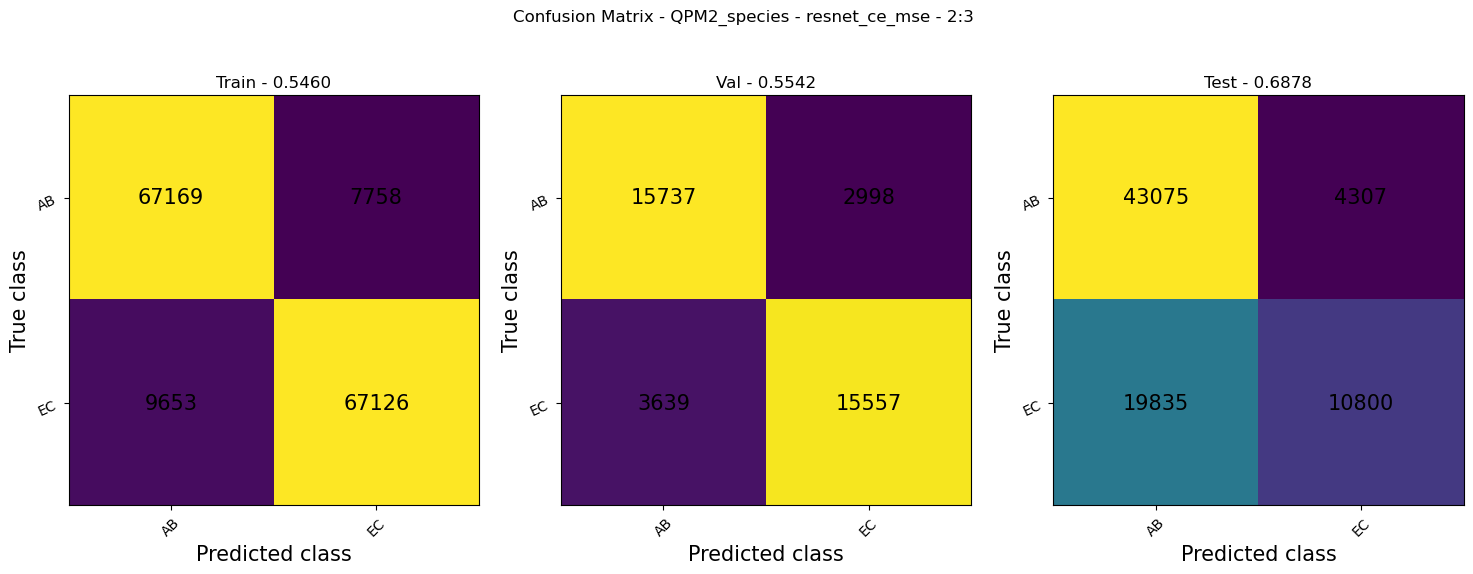

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(78017, 2) (81589, 2)
(78017, 2) (81589, 2)


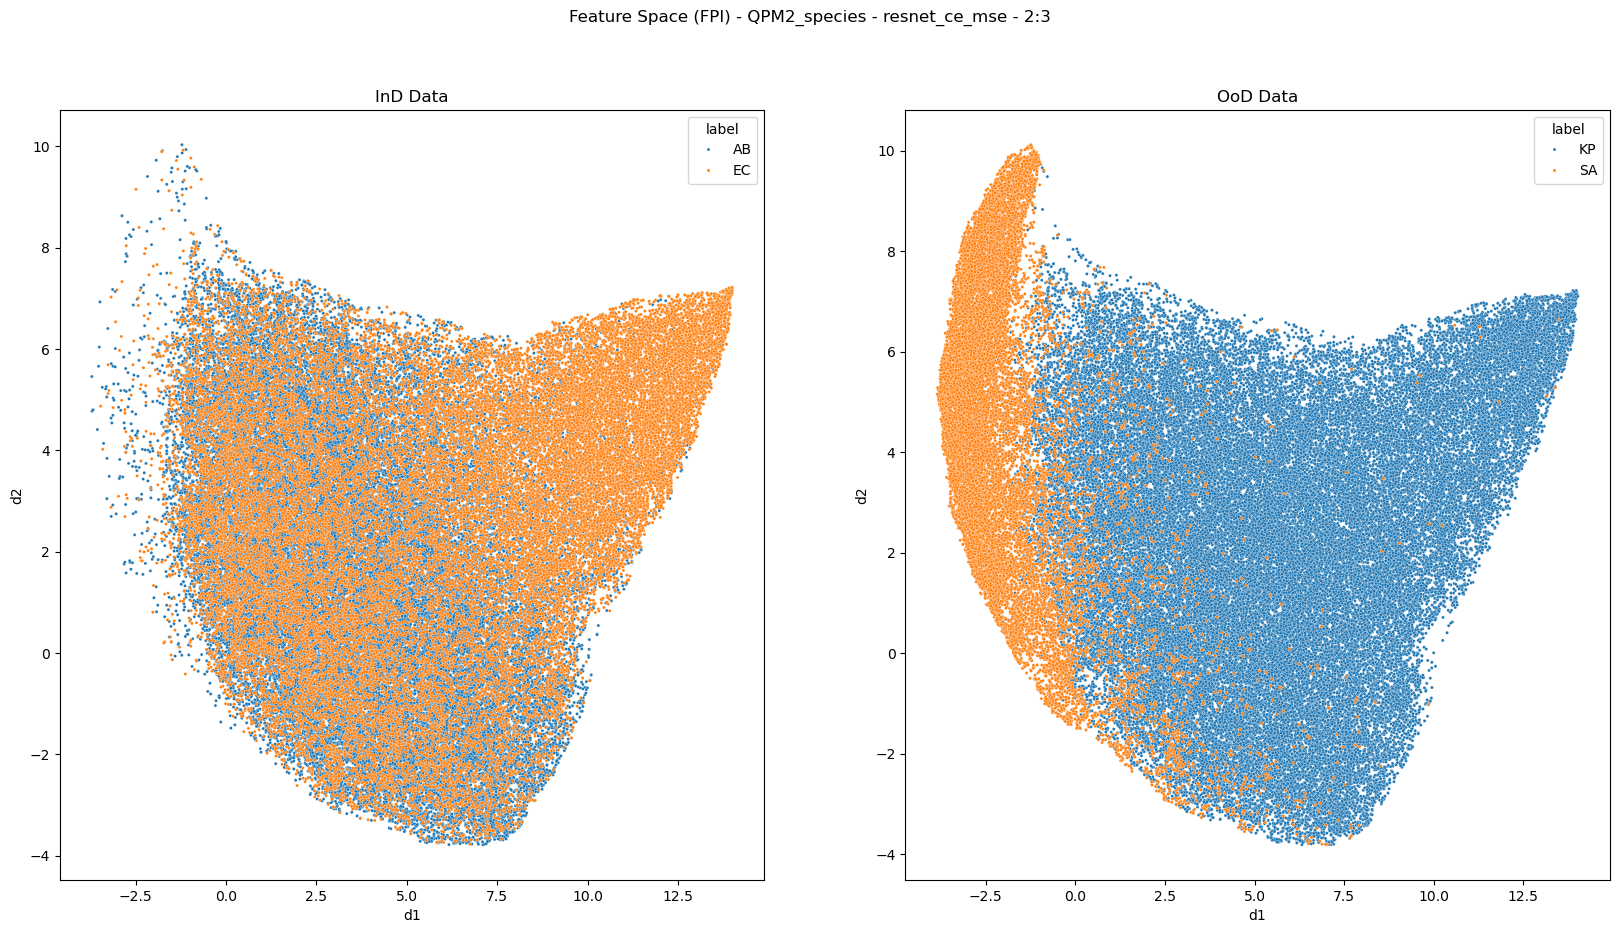

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

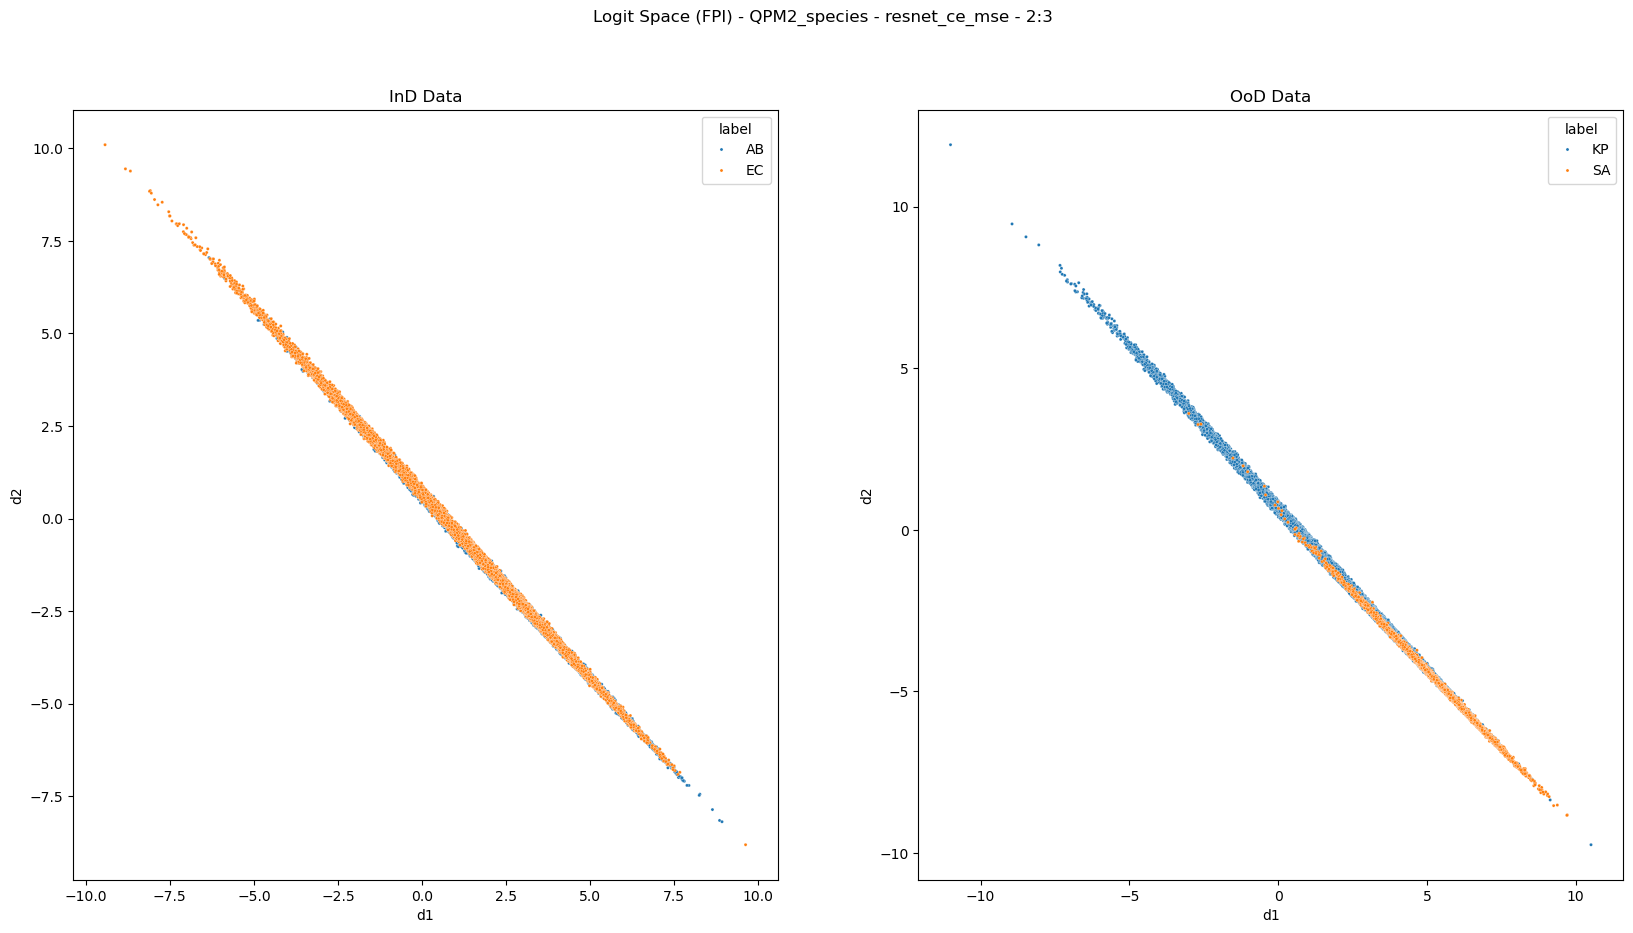

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

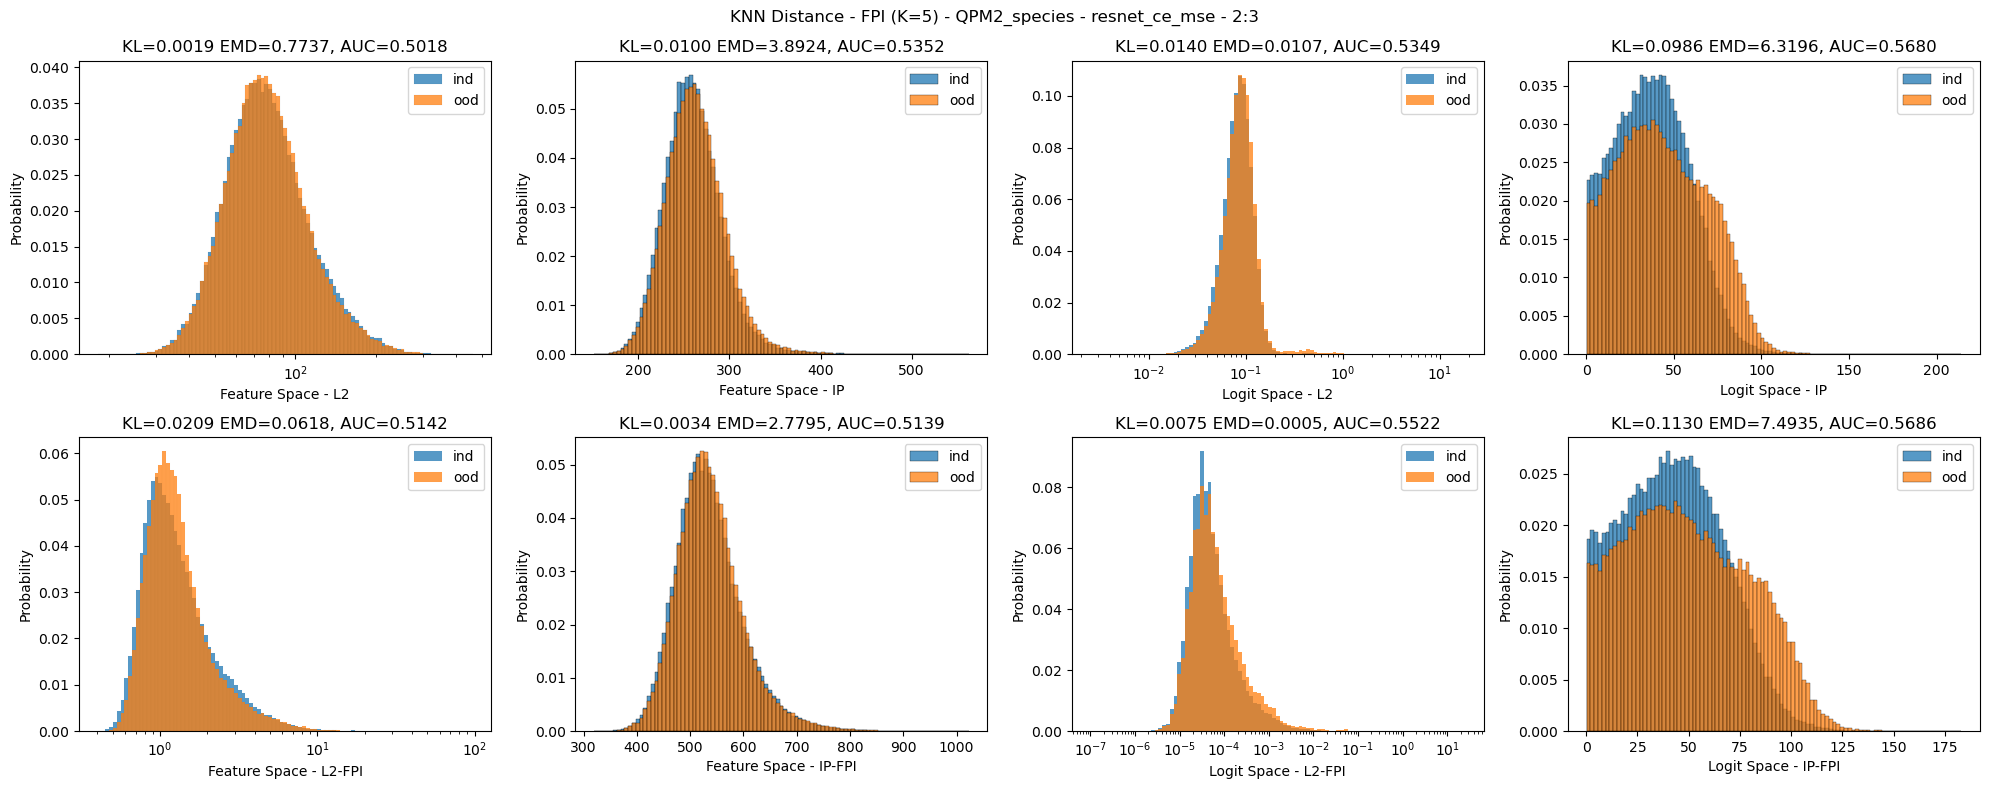

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

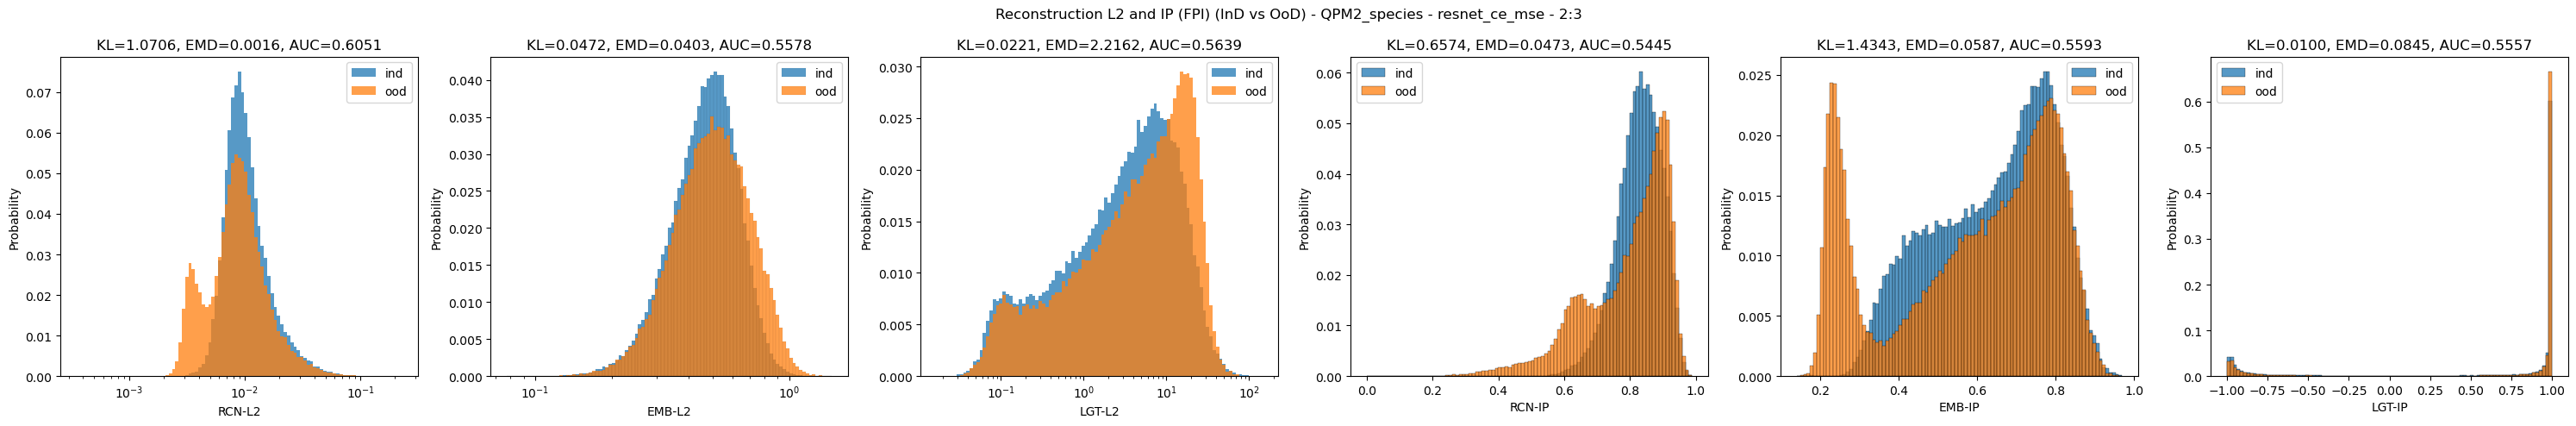

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

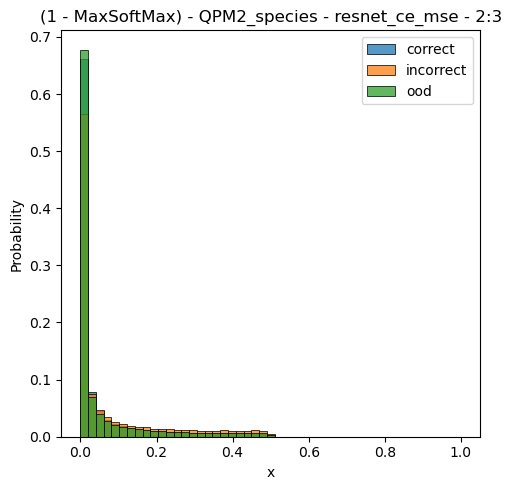

In [17]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()